In [1]:
# General
import os, time
import requests, glob, warnings, zipfile
import numpy as np
import pandas as pd
import datetime as dt
import tables as tb
from collections import OrderedDict
pd.options.display.max_columns = 24

# Matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import mpl_toolkits.mplot3d.axes3d as p3
import matplotlib.animation as animation

# Cartopy & geopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from geopy import distance

%config Completer.use_jedi = False

# Madrid

- Hourly air quality data (2001-2021): [link](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=f3c0f7d512273410VgnVCM2000000c205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
- Stations file: [link](https://datos.madrid.es/portal/site/egob/menuitem.c05c1f754a33a9fbe4b2e4b284f1a5a0/?vgnextoid=9e42c176313eb410VgnVCM1000000b205a0aRCRD&vgnextchannel=374512b9ace9f310VgnVCM100000171f5a0aRCRD&vgnextfmt=default)
- Madrid regions (municipios): [link](http://gestiona.madrid.org/nomecalles/DescargaBDTCorte.icm). Converted from ETRS89 to WGS 84 (EPSG:4326) using [this online tool](https://mygeodata.cloud/converter/).

In [2]:
folder = '../data/madrid/'

## Location of the stations

In [3]:
df_st = pd.read_csv(folder + 'other/stations.csv', sep=';', encoding='latin')
n_st, n_gas = df_st.shape[0], 8
df_st.head()

CODIGO  CODIGO_CORTO             ESTACION  \
0  28079004             4       Pza. de España   
1  28079008             8     Escuelas Aguirre   
2  28079011            11  Avda. Ramón y Cajal   
3  28079016            16         Arturo Soria   
4  28079017            17           Villaverde   

                                           DIRECCION LONGITUD_ETRS89  \
0                                    Plaza de España    3°42'43.91"O   
1                    Entre C/ Alcalá y C/ O Donell     3°40'56.22"O   
2   Avda. Ramón y Cajal  esq. C/ Príncipe de Vergara    3°40'38.50"O   
3  C/ Arturo Soria  esq. C/  Vizconde de los Asilos     3°38'21.17"O   
4                                  C/. Juan Peñalver    3°42'47.89"O   

  LATITUD_ETRS89  ALTITUD COD_TIPO        NOM_TIPO NO2  SO2   CO  ... PM2_5  \
0  40°25'25.98"N      637       UT  Urbana tráfico   X    X    X  ...   NaN   
1  40°25'17.63"N      672       UT  Urbana tráfico   X    X    X  ...     X   
2   40°27'5.29"N      708       UT  Urbana tráfico   X  NaN  NaN  ...   NaN   
3  40°26'24.20"N      695       UF    Urbana fondo   X  NaN  NaN  ...   NaN   
4  40°20'49.74"N      601       UF    Urbana fondo   X    X  NaN  ...   NaN   

    O3  BTX COD_VIA  VIA_CLASE VIA_PAR              VIA_NOMBRE  Fecha alta  \
0  NaN  NaN  273600      PLAZA      DE                  ESPAÑA  01/12/1998   
1    X    X   18900      CALLE      DE                  ALCALA  01/12/1998   
2  NaN    X  610450      CALLE     DEL     PRINCIPE DE VERGARA  01/12/1998   
3    X  NaN  798700      CALLE     DEL  VIZCONDE DE LOS ASILOS  01/12/1998   
4    X  NaN  417200      CALLE      DE           JUAN PEÑALVER  01/12/1998   

  COORDENADA_X_ETRS89 COORDENADA_Y_ETRS89  LONGITUD    LATITUD  
0         439579,3291         4475049,263 -3.712257  40.423882  
1         442117,2366         4474770,696 -3.682316  40.421553  
2         442564,0457         4478088,595 -3.677349  40.451473  
3         445786,1729         4476796,019 -3.639242  40.440046  
4         439420,7015         4466532,455 -3.713317  40.347147  

[5 rows x 25 columns]

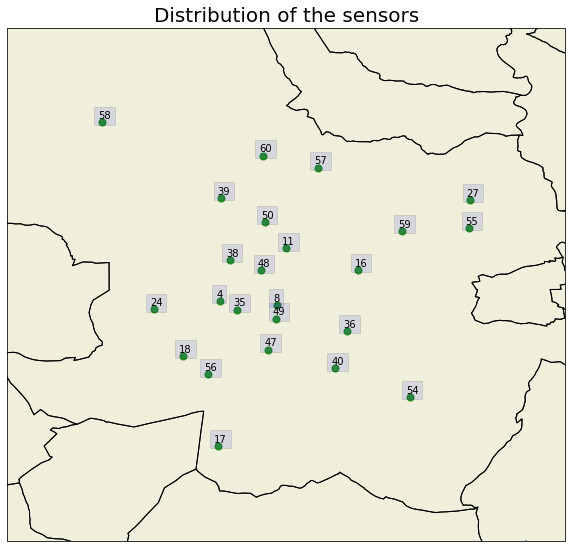

In [4]:
# Define the extent to be shown:
offset = 0.05
lon_lat_ranges = [df_st.LONGITUD.min() - offset, df_st.LONGITUD.max() + offset,
                  df_st.LATITUD.min() - offset, df_st.LATITUD.max() + offset]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.set_extent(lon_lat_ranges, crs=ccrs.PlateCarree())

fname = folder + 'other/coords/200001692.shp'
df_shp = pd.DataFrame({'poly': Reader(fname).geometries()})
for i in range(df_shp.shape[0]):
    ax.add_geometries([df_shp.iloc[i, 0]], ccrs.PlateCarree(), edgecolor='k', facecolor='none')

# Add frontiers, sea, lakes...
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.scatter(df_st.LONGITUD, df_st.LATITUD, marker='o', c='g', s=50, alpha=0.8)
ax.set_title('Distribution of the sensors', fontdict={'size': 20})
for s in range(df_st.shape[0]):
    ax.text(df_st.loc[s, 'LONGITUD'] - 0.002, df_st.loc[s, 'LATITUD'] + 0.002,
            df_st.loc[s, 'CODIGO_CORTO'], bbox=dict(facecolor='blue', alpha=0.1))
plt.savefig('./graphs/madrid_sensor_dist.pdf', bbox_inches='tight')
plt.show()

Meteorological stations:

In [5]:
df_met = pd.DataFrame(np.array([[40.4516, -3.72416],
                               [40.4119, -3.67805],
                               [40.4666, -3.55555],
                               [40.3755, -3.78611],
                               [40.2994, -3.72222],
                               [40.4483, -3.81333],
                               [40.55, -3.61666],
                               [40.5613, -3.71194],
                               [40.3116, -3.49777],
                               [40.4886, -3.44361]]), columns=['lat', 'lng'],
                index=['C. Universitaria', 'Retiro', 'Barajas', 'Cuatro Vientos',
                       'Getafe', 'Pozuelo', 'San Sebastián', 'El Goloso', 'Arganda del Rey', 'Torrejón'])
df_met

lat      lng
C. Universitaria  40.4516 -3.72416
Retiro            40.4119 -3.67805
Barajas           40.4666 -3.55555
Cuatro Vientos    40.3755 -3.78611
Getafe            40.2994 -3.72222
Pozuelo           40.4483 -3.81333
San Sebastián     40.5500 -3.61666
El Goloso         40.5613 -3.71194
Arganda del Rey   40.3116 -3.49777
Torrejón          40.4886 -3.44361

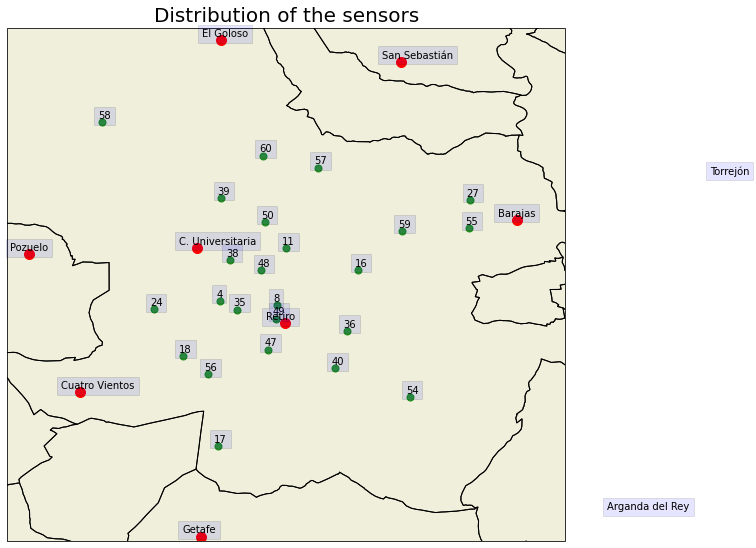

In [6]:
# Define the extent to be shown:
offset = 0.05
lon_lat_ranges = [df_st.LONGITUD.min() - offset, df_st.LONGITUD.max() + offset,
                  df_st.LATITUD.min() - offset, df_st.LATITUD.max() + offset]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.set_extent(lon_lat_ranges, crs=ccrs.PlateCarree())

fname = folder + 'other/coords/200001692.shp'
df_shp = pd.DataFrame({'poly': Reader(fname).geometries()})
for i in range(df_shp.shape[0]):
    ax.add_geometries([df_shp.iloc[i, 0]], ccrs.PlateCarree(), edgecolor='k', facecolor='none')

# Add frontiers, sea, lakes...
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.scatter(df_st.LONGITUD, df_st.LATITUD, marker='o', c='g', s=50, alpha=0.8)
ax.set_title('Distribution of the sensors', fontdict={'size': 20})
for s in range(df_st.shape[0]):
    ax.text(df_st.loc[s, 'LONGITUD'] - 0.002, df_st.loc[s, 'LATITUD'] + 0.002,
            df_st.loc[s, 'CODIGO_CORTO'], bbox=dict(facecolor='blue', alpha=0.1))
ax.scatter(df_met.lng, df_met.lat, marker='o', c='r', s=100)
for s in range(df_met.shape[0]):
    ax.text(df_met.iloc[s].lng - 0.01, df_met.iloc[s].lat + 0.002,
            df_met.iloc[s].name, bbox=dict(facecolor='blue', alpha=0.1))
plt.savefig('./graphs/madrid_sensor_dist_met.pdf', bbox_inches='tight')
plt.show()

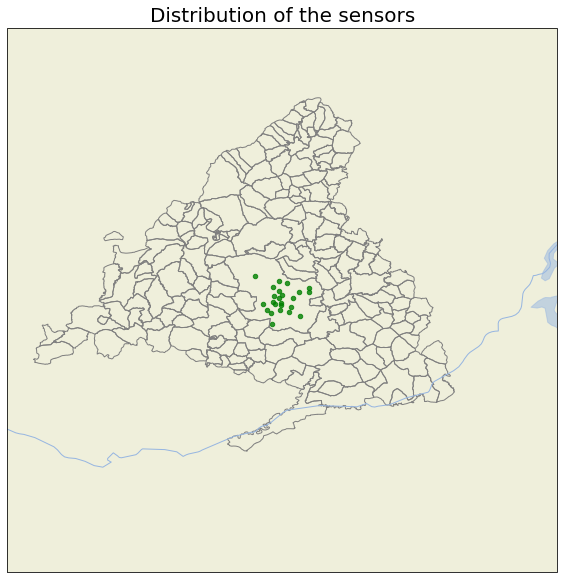

In [7]:
# Define the extent to be shown:
offset = 0.9
lon_lat_ranges = [df_st.LONGITUD.min() - offset, df_st.LONGITUD.max() + offset,
                  df_st.LATITUD.min() - offset, df_st.LATITUD.max() + offset]


fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.set_extent(lon_lat_ranges, crs=ccrs.PlateCarree())

fname = folder + 'other/coords/200001692.shp'
df_shp = pd.DataFrame({'poly': Reader(fname).geometries()})
for i in range(df_shp.shape[0]):
    ax.add_geometries([df_shp.iloc[i, 0]], ccrs.PlateCarree(), edgecolor='gray', facecolor='none')

# Add frontiers, sea, lakes...
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.scatter(df_st.LONGITUD, df_st.LATITUD, marker='o', c='g', s=20, alpha=0.8)
ax.set_title('Distribution of the sensors', fontdict={'size': 20})
plt.savefig('./graphs/madrid_sensor_dist_far.pdf', bbox_inches='tight')
plt.show()

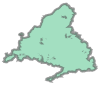

In [8]:
from shapely.ops import unary_union

unary_union(df_shp.poly)

Distance between sensors (in km):

In [9]:
df_st = pd.read_csv(folder + 'other/stations.csv', sep=';', encoding='latin')
df_locs = df_st[['CODIGO_CORTO', 'LONGITUD', 'LATITUD']].copy()
df_locs.columns = ['c', 'lng', 'lat']
df_locs.loc[:, 'c'] = df_locs.loc[:, 'c'].astype(str).str.zfill(2).copy()
df_locs.set_index('c', inplace=True)

04   08   11   16   17   18   24   27   35   36   38   39   40  \
min dist  1.1  0.8  1.9  3.4  4.3  1.8  3.2  1.6  1.1  2.3  2.0  2.9  2.3   
sensor     35   49   48   59   56   56   18   55   04   40   48   50   36   

           47   48   49   50   54   55   56   57   58   59   60  
min dist  1.9  1.9  0.8  2.0  4.7  1.6  1.8  3.3  8.3  3.4  3.3  
sensor     49   11   08   11   40   27   18   60   39   16   57

Absolute min: 0.79km
Median: 8.701km
Absolute max: 24.134km


04    08    11    16    17    18    24    27    35    36    38    39  \
04   NaN   3.3   4.9   8.3   8.5   3.9   3.9  15.8   1.1   7.6   2.5   6.0   
08   3.3   NaN   3.4   5.2   8.9   6.2   7.2  12.9   2.3   4.4   3.8   7.1   
11   4.9   3.4   NaN   4.4  12.3   8.7   8.5  11.1   4.6   6.0   3.4   4.8   
16   8.3   5.2   4.4   NaN  13.2  11.4  12.2   7.7   7.4   3.6   7.5   9.1   
17   8.5   8.9  12.3  13.2   NaN   5.7   8.9  20.6   8.1  10.1  11.0  14.6   
18   3.9   6.2   8.7  11.4   5.7   NaN   3.2  19.1   4.2   9.7   6.3   9.5   
24   3.9   7.2   8.5  12.2   8.9   3.2   NaN  19.6   4.9  11.4   5.3   7.6   
27  15.8  12.9  11.1   7.7  20.6  19.1  19.6   NaN  15.1  10.5  14.5  14.5   
35   1.1   2.3   4.6   7.4   8.1   4.2   4.9  15.1   NaN   6.5   3.0   6.6   
36   7.6   4.4   6.0   3.6  10.1   9.7  11.4  10.5   6.5   NaN   8.0  10.7   
38   2.5   3.8   3.4   7.5  11.0   6.3   5.3  14.5   3.0   8.0   NaN   3.7   
39   6.0   7.1   4.8   9.1  14.6   9.5   7.6  14.5   6.6  10.7   3.7   NaN   
40   7.8   5.0   7.6   5.9   8.2   8.9  11.1  12.6   6.7   2.3   8.9  12.0   
47   4.0   2.7   6.0   7.0   6.4   5.0   7.1  14.7   3.0   4.7   5.7   9.3   
48   3.0   2.2   1.9   5.7  10.6   6.8   6.7  12.9   2.7   6.1   2.0   4.9   
49   3.5   0.8   4.2   5.6   8.2   5.9   7.2  13.3   2.3   4.2   4.4   7.8   
50   5.3   4.9   2.0   6.2  13.4   9.2   8.3  12.1   5.4   8.0   3.0   2.9   
54  12.4   9.4  11.3   8.0  11.6  13.5  15.8  12.1  11.3   5.3  13.2  16.0   
55  15.2  12.1  10.8   6.9  19.5  18.3  19.1   1.6  14.4   9.4  14.1  14.6   
56   4.4   5.7   8.7  10.7   4.3   1.8   5.0  18.4   4.2   8.5   6.8  10.4   
57   9.7   8.4   5.1   6.5  17.3  13.6  12.7   9.1   9.6   9.7   7.5   5.9   
58  12.5  14.8  13.1  17.3  20.2  14.5  11.4  22.0  13.5  18.8  11.0   8.3   
59  11.4   8.5   6.8   3.4  16.6  14.7  15.2   4.4  10.7   6.7  10.2  10.7   
60   8.9   8.8   5.6   8.7  17.2  12.6  11.0  12.4   9.2  11.4   6.4   3.5   

      40    47    48    49    50    54    55    56    57    58    59    60  
04   7.8   4.0   3.0   3.5   5.3  12.4  15.2   4.4   9.7  12.5  11.4   8.9  
08   5.0   2.7   2.2   0.8   4.9   9.4  12.1   5.7   8.4  14.8   8.5   8.8  
11   7.6   6.0   1.9   4.2   2.0  11.3  10.8   8.7   5.1  13.1   6.8   5.6  
16   5.9   7.0   5.7   5.6   6.2   8.0   6.9  10.7   6.5  17.3   3.4   8.7  
17   8.2   6.4  10.6   8.2  13.4  11.6  19.5   4.3  17.3  20.2  16.6  17.2  
18   8.9   5.0   6.8   5.9   9.2  13.5  18.3   1.8  13.6  14.5  14.7  12.6  
24  11.1   7.1   6.7   7.2   8.3  15.8  19.1   5.0  12.7  11.4  15.2  11.0  
27  12.6  14.7  12.9  13.3  12.1  12.1   1.6  18.4   9.1  22.0   4.4  12.4  
35   6.7   3.0   2.7   2.3   5.4  11.3  14.4   4.2   9.6  13.5  10.7   9.2  
36   2.3   4.7   6.1   4.2   8.0   5.3   9.4   8.5   9.7  18.8   6.7  11.4  
38   8.9   5.7   2.0   4.4   3.0  13.2  14.1   6.8   7.5  11.0  10.2   6.4  
39  12.0   9.3   4.9   7.8   2.9  16.0  14.6  10.4   5.9   8.3  10.7   3.5  
40   NaN   4.1   7.2   4.5   9.5   4.7  11.4   7.4  11.8  19.8   9.0  13.2  
47   4.1   NaN   4.7   1.9   7.5   8.7  13.7   3.8  11.1  16.5  10.4  11.4  
48   7.2   4.7   NaN   3.0   2.9  11.4  12.4   6.9   6.9  12.7   8.5   6.7  
49   4.5   1.9   3.0   NaN   5.7   9.0  12.5   5.2   9.2  15.4   8.9   9.6  
50   9.5   7.5   2.9   5.7   NaN  13.3  12.0   9.5   4.5  11.1   8.0   3.9  
54   4.7   8.7  11.4   9.0  13.3   NaN  10.5  11.9  14.5  24.1   9.8  16.6  
55  11.4  13.7  12.4  12.5  12.0  10.5   NaN  17.5   9.5  22.3   4.0  12.8  
56   7.4   3.8   6.9   5.2   9.5  11.9  17.5   NaN  13.7  16.0  14.1  13.2  
57  11.8  11.1   6.9   9.2   4.5  14.5   9.5  13.7   NaN  12.9   6.1   3.3  
58  19.8  16.5  12.7  15.4  11.1  24.1  22.3  16.0  12.9   NaN  18.6   9.6  
59   9.0  10.4   8.5   8.9   8.0   9.8   4.0  14.1   6.1  18.6   NaN   9.2  
60  13.2  11.4   6.7   9.6   3.9  16.6  12.8  13.2   3.3   9.6   9.2   NaN

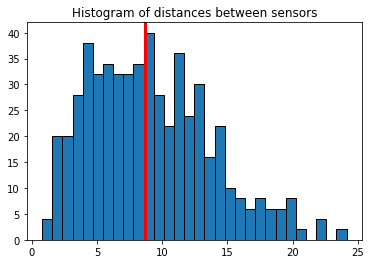

In [10]:
df_dist = pd.DataFrame()

for s1 in df_locs.index.values:
    for s2 in df_locs.index.values:
        if  s1 == s2:
            df_dist.loc[s1, s2] = np.nan
        else:
            d = distance.distance(df_locs.loc[s1], df_locs.loc[s2]).km
            df_dist.loc[s1, s2] = d
display(pd.DataFrame({'min dist': df_dist.min().round(1), 'sensor': df_dist.idxmin()}).T)
print('Absolute min: {}km'.format(df_dist.min().min().round(3)))
print('Median: {}km'.format(np.nanmedian(df_dist.values.ravel()).round(3)))
print('Absolute max: {}km'.format(df_dist.max().max().round(3)))
plt.hist(df_dist.values.ravel(), edgecolor='k', bins=30)
plt.title('Histogram of distances between sensors')
plt.axvline(np.nanmedian(df_dist.values.ravel()), color='r', linewidth=3)
df_dist.round(1)

## Gases measured (in theory)

They removed `HC`:

In [9]:
df_gas = df_st[['CODIGO_CORTO','NO2', 'SO2', 'CO', 'PM10', 'PM2_5', 'O3', 'BTX']]
df_gas.set_index('CODIGO_CORTO', inplace=True)

In [10]:
df_gas = df_gas.replace(np.nan, 0).replace('X', 1)
df_gas.loc['Coverage [%]', :] = (df_gas.sum() / n_st * 100).map(int)
df_gas.loc[:, 'Coverage [%]'] = (df_gas.sum(axis=1) / n_gas * 100).map(int)
df_gas.iloc[-1,-1] = 0
df_gas.astype(int)

NO2  SO2  CO  PM10  PM2_5  O3  BTX  Coverage [%]
CODIGO_CORTO                                                  
4               1    1   1     0      0   0    0            37
8               1    1   1     1      1   1    1            87
11              1    0   0     0      0   0    1            25
16              1    0   0     0      0   1    0            25
17              1    1   0     0      0   1    0            37
18              1    1   1     1      0   1    1            75
24              1    0   0     1      1   1    1            62
27              1    0   0     0      0   1    0            25
35              1    1   1     0      0   1    0            50
36              1    1   0     1      0   0    0            37
38              1    0   0     1      1   0    1            50
39              1    0   0     0      0   1    0            25
40              1    0   0     1      0   0    0            25
47              1    0   0     1      1   0    0            37
48              1    0   0     1      1   0    0            37
49              1    0   0     0      0   1    0            25
50              1    0   0     1      1   0    0            37
54              1    0   0     0      0   1    0            25
55              1    0   0     1      0   0    1            37
56              1    0   1     1      1   1    0            62
57              1    1   0     1      0   0    0            37
58              1    0   0     0      0   1    0            25
59              1    0   0     0      0   1    0            25
60              1    0   0     1      0   1    0            37
Coverage [%]  100   29  20    54     29  58   25             0

**Caveat!** The file `'Interprete_ficheros_ calidad_ del_ aire_global.pdf'` shows more pollutants.

The following are gases that appear in the raw data.  
In the file `'Interprete_ficheros_ calidad_ del_ aire_global.pdf'` there are 3 extra gases (37 MXY, 38 PXY, 39 OXY), and BTX is missing.

Dictionary of station codes and names:

In [11]:
#folder = '../data/madrid/'
df_st = pd.read_csv(folder + 'other/stations.csv', sep=';', encoding='latin')
sc_map = OrderedDict(zip(df_st.CODIGO_CORTO.astype(str).str.zfill(2), df_st.ESTACION))
# And the reversed dictionary
sn_map = OrderedDict({v: k for k, v in sc_map.items()})

Dictionary of variable codes and names:

In [12]:
vc_map = OrderedDict()
vc_map['01'] = 'SO2'
vc_map['06'] = 'CO'
vc_map['07'] = 'NO'
vc_map['08'] = 'NO2'
vc_map['09'] = 'PM25'
vc_map['10'] = 'PM10'
vc_map['12'] = 'NOx'
vc_map['14'] = 'O3'
vc_map['20'] = 'TOL'
vc_map['30'] = 'BEN'
vc_map['35'] = 'EBE'
vc_map['42'] = 'TCH'
vc_map['43'] = 'CH4'
vc_map['44'] = 'NMHC'
#vc_map['37'] = 'MXY' # Does not appear in the raw data
#vc_map['38'] = 'PXY' # Does not appear in the raw data
#vc_map['39'] = 'OXY' # Does not appear in the raw data
#vc_map['-1'] = 'BTX' # Does not appear in the raw data
# And the reversed dictionary
vn_map = OrderedDict({v: k for k, v in vc_map.items()})
len(vc_map)

vc_map_pretty = OrderedDict()
vc_map_pretty['01'] = 'SO$_2$'
vc_map_pretty['06'] = 'CO'
vc_map_pretty['07'] = 'NO'
vc_map_pretty['08'] = 'NO$_2$'
vc_map_pretty['09'] = 'PM$_{2.5}$'
vc_map_pretty['10'] = 'PM$_{10}$'
vc_map_pretty['12'] = 'NO$_x$'
vc_map_pretty['14'] = 'O$_3$'
vc_map_pretty['20'] = 'TOL'
vc_map_pretty['30'] = 'BEN'
vc_map_pretty['35'] = 'EBE'
vc_map_pretty['42'] = 'TCH'
vc_map_pretty['43'] = 'CH$_4$'
vc_map_pretty['44'] = 'NMHC'
len(vc_map_pretty)

14

In [13]:
months_d = dict(zip(['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'],
                    range(1, 13)))
df_v = pd.DataFrame(columns=['file', 'year', 'month'])
df_v.file = [f for f in os.listdir(folder + 'raw/csv/') if os.path.splitext(f)[1] == '.csv']    
df_v.year = ('20' + df_v.file.str[-6:-4]).map(int)
df_v.month = df_v.file.str[0:3].str.lower().map(months_d)
df_v.set_index('file', inplace=True)
df_v.sort_values(['year', 'month'], inplace=True)
raw_files = df_v.index.values

Gases measured in $\mu$g and in mg:

In [14]:
gases_in_mug = ['01', '07', '08', '09', '10', '12', '14', '20', '30', '35']
gases_in_mg = ['06', '42', '43', '44']

## Installation dates

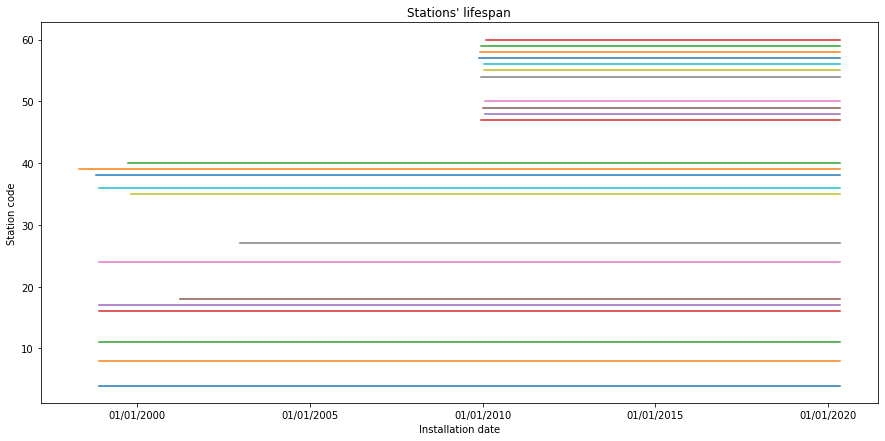

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
for r in df_st[['CODIGO_CORTO', 'Fecha alta']].iterrows():
    start = dt.datetime(*[int(x) for x in (r[1]['Fecha alta'].split('/')[::-1])])
    to = dt.datetime(2020, 5, 1)
    code = r[1]['CODIGO_CORTO']
    ax.plot([start, to], [code, code])
ax.set_title("Stations' lifespan")
ax.set_xlabel('Installation date')
ax.set_ylabel('Station code')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(5))
plt.show()

Including information from `'Interprete_ficheros_ calidad_ del_ aire_global.pdf'` reveals more stations:

In [26]:
df_life = pd.read_csv(folder + 'other/stations-lifespan.csv')

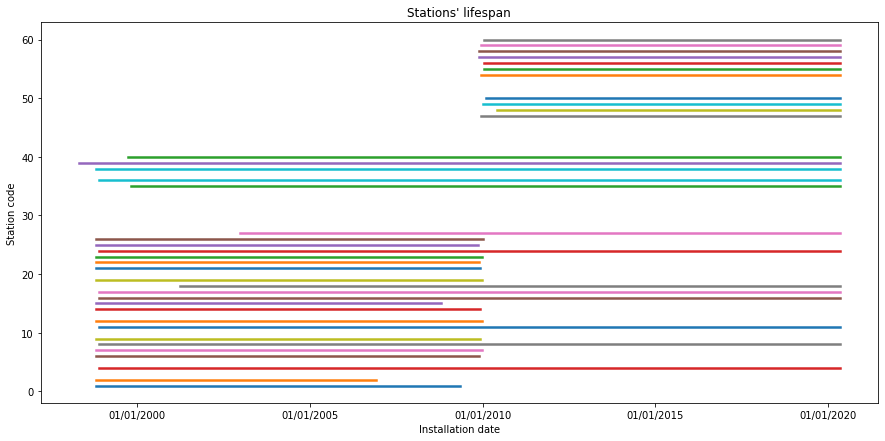

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 7)
for r in df_life[['short_code', 'up', 'down']].iterrows():
    up = dt.datetime(1998, 11, 1)
    down = dt.datetime(2020, 5, 1)
    #print(type(r[1]['up']))
    if not pd.isna(r[1]['up']):
        up = dt.datetime(*[int(x) for x in (r[1]['up'].split('/')[::-1])])
    if not pd.isna(r[1]['down']):
        down = dt.datetime(*[int(x) for x in (r[1]['down'].split('/')[::-1])])
    code = r[1]['short_code']
    ax.plot([up, down], [code, code], lw=2.5)
ax.set_title("Stations' lifespan")
ax.set_xlabel('Installation date')
ax.set_ylabel('Station code')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
ax.xaxis.set_major_locator(mdates.YearLocator(5))
plt.savefig('./graphs/madrid_lifespan.pdf', bbox_inches='tight')
plt.show()

- First period: around 27 stations.
- First period: around 24 stations.

All stations from `df_st` are included in the pdf.

In [28]:
for a in df_st.CODIGO_CORTO:
    if a not in set(df_life.short_code):
        print(a)

## Quality assessment

Some important information:
- Temporal data is expressed in local time. Regarding time changes: when there is one hour less the calculated with 23 values, and if there is one hour more one is supressed.
- H24 refers to the last hour of the day, and it is calculated as the average of the six 10-minute recordings from 23h to 24h.

### Check missing files

In [30]:
years = np.arange(2001, 2023)
n_years = years.shape[0]

files = os.listdir(folder + 'raw/csv')
    
for year in years:
    end = str(year)[-2:] + '.csv'
    l = [f for f in files if end in f]
    if len(l) != 12:
        print(len(l), '->', l)

4 -> ['mar_mo22.csv', 'ene_mo22.csv', 'abr_mo22.csv', 'feb_mo22.csv']


In [31]:
(n_years - 1) * 12 + 4

256

In [32]:
!ls ../data/madrid/raw/csv/*.csv | wc -l

256


### Check one file

In [35]:
df = pd.read_csv(folder + 'raw/csv/sep_mo01.csv', sep=';')#widths=widths, names=col_names)
df.head()

PROVINCIA  MUNICIPIO  ESTACION  MAGNITUD PUNTO_MUESTREO   ANO  MES  DIA  \
0         28         79         4         1  28079004_1_38  2001    9    1   
1         28         79         4         1  28079004_1_38  2001    9    2   
2         28         79         4         1  28079004_1_38  2001    9    3   
3         28         79         4         1  28079004_1_38  2001    9    4   
4         28         79         4         1  28079004_1_38  2001    9    5   

    H01 V01  H02 V02  ...  H19 V19  H20 V20  H21 V21   H22 V22   H23 V23  \
0   5.0   V  5.0   V  ...  7.0   V  7.0   V  7.0   V   8.0   V   6.0   V   
1   5.0   V  5.0   V  ...  6.0   V  5.0   V  6.0   V  11.0   V  20.0   V   
2  13.0   V  8.0   V  ...  7.0   V  7.0   V  7.0   V   7.0   V   8.0   V   
3   8.0   V  7.0   V  ...  7.0   V  7.0   V  8.0   V   9.0   V   9.0   V   
4   7.0   V  7.0   V  ...  7.0   V  8.0   V  8.0   V   8.0   V   8.0   V   

    H24 V24  
0   5.0   V  
1  18.0   V  
2   9.0   V  
3   8.0   V  
4   7.0   V  

[5 rows x 56 columns]

In [36]:
df.MAGNITUD.unique()

array([ 1,  6,  7,  8, 12, 14, 10, 20, 30, 35, 42, 43, 44])

In [37]:
df.ESTACION.unique()

array([ 4, 11, 16, 18, 24, 35, 36, 38, 39, 40])

In [38]:
x_labs = ['H{:02}'.format(i) for i in range (1, 25)]
print(x_labs)

['H01', 'H02', 'H03', 'H04', 'H05', 'H06', 'H07', 'H08', 'H09', 'H10', 'H11', 'H12', 'H13', 'H14', 'H15', 'H16', 'H17', 'H18', 'H19', 'H20', 'H21', 'H22', 'H23', 'H24']


Mean value per station [79. 33. 50. 35. 45. 71. 47. 60. 48. 44.]
Mean value per station [ 8. 10. 12. 12.  8. 20.  4.]


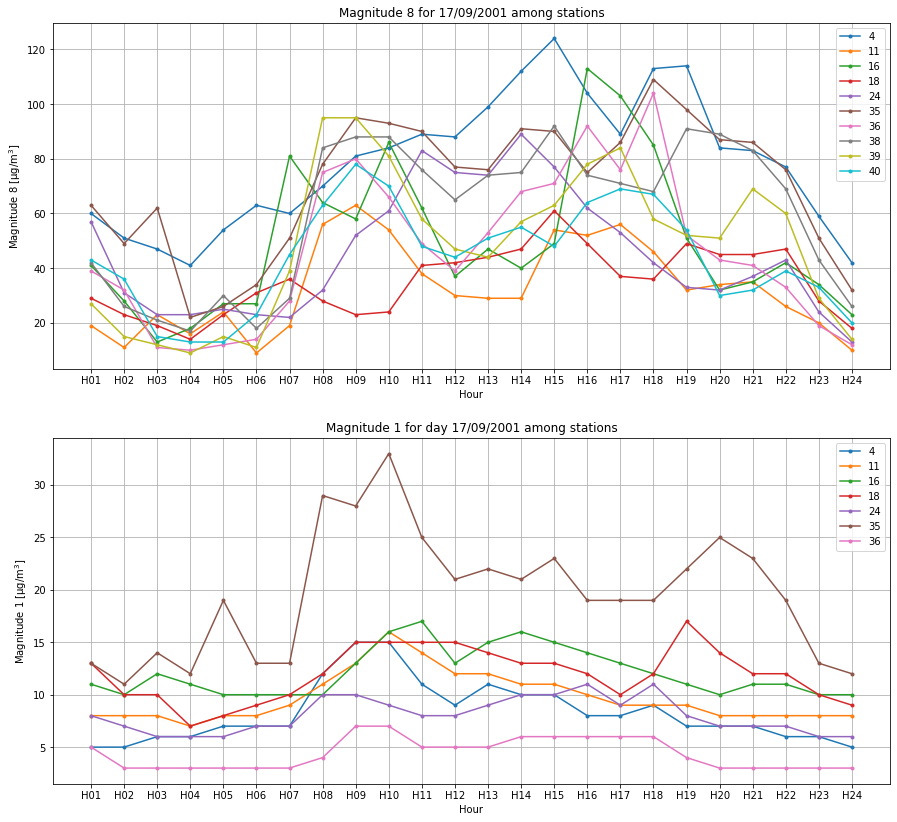

In [39]:
fig, axs = plt.subplots(2, 1)
fig.set_size_inches(15, 14)

ax = axs[0]
day, mag = 17, 8
mask = (df.DIA == day) & (df.MAGNITUD == mag)
ax.plot(x_labs, df.loc[mask, 'H01':'H24':2].T, '.-')
ax.legend(df.ESTACION.unique(), loc='upper right')
ax.set_title('Magnitude {} for {}/09/2001 among stations'.format(mag, day))
ax.set_xlabel('Hour')
ax.set_ylabel('Magnitude {} [μg/m$^3$]'.format(mag))
ax.grid()
print('Mean value per station', df.loc[mask, 'H01':'H24':2].T.mean().round().values)

ax = axs[1]
day, mag = 17, 1
mask = (df.DIA == day) & (df.MAGNITUD == mag)
ax.plot(x_labs, df.loc[mask, 'H01':'H24':2].T, '.-')
ax.legend(df.ESTACION.unique(), loc='upper right')
ax.set_title('Magnitude {} for day {}/09/2001 among stations'.format(mag, day))
ax.set_xlabel('Hour')
ax.set_ylabel('Magnitude {} [μg/m$^3$]'.format(mag))
ax.grid()
print('Mean value per station', df.loc[mask, 'H01':'H24':2].T.mean().round().values)

#plt.savefig('./graphs/madrid_ts.pdf', bbox_inches='tight')
plt.show()

### Full assessment

Size of raw data:

In [40]:
!find ../data/madrid/raw/csv/ -type f -name '*.csv' -exec du -ch {} + | grep total$

203M	total


Number of months:

In [42]:
!ls -l ../data/madrid/raw/csv/*.csv | wc -l

256


In [43]:
# Number of months
21 * 12 + 4

256

In [44]:
months_d = dict(zip(['ene', 'feb', 'mar', 'abr', 'may', 'jun', 'jul', 'ago', 'sep', 'oct', 'nov', 'dic'],
                    range(1, 13)))

In [46]:
df_v = pd.DataFrame(columns=['file', 'year', 'month', 'valid', 'total', 'percentage', 'unique st', 'unique mag'])
df_v.file = [f for f in os.listdir(folder + 'raw/csv') if os.path.splitext(f)[1] == '.csv']
df_v.year = ('20' + df_v.file.str[-6:-4]).map(int)
df_v.month = df_v.file.str[0:3].str.lower().map(months_d)
df_v.set_index('file', inplace=True)
df_v.sort_values(['year', 'month'], inplace=True)
df_v.head()

year  month valid total percentage unique st unique mag
file                                                                 
ene_mo01.csv  2001      1   NaN   NaN        NaN       NaN        NaN
feb_mo01.csv  2001      2   NaN   NaN        NaN       NaN        NaN
mar_mo01.csv  2001      3   NaN   NaN        NaN       NaN        NaN
abr_mo01.csv  2001      4   NaN   NaN        NaN       NaN        NaN
may_mo01.csv  2001      5   NaN   NaN        NaN       NaN        NaN

In [47]:
tic = time.time()
v_set = set()
s_set = set()
g_set = set()
for f in df_v.index:
  #  if df_v.loc[f, 'year'] <= 2016 or (df_v.loc[f, 'year'] == 2017 and df_v.loc[f, 'month'] <= 9):
  #      df = pd.read_fwf(os.path.join('./data/madrid/raw/txt', f), widths=widths, names=col_names)
  #  else:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')#,  names=col_names)
    df_v.loc[f, 'valid'] = (df.loc[:, 'V01'::2] == 'V').sum().sum()
    df_v.loc[f, 'total'] = df.shape[0] * 24
    df_v.loc[f, 'unique st'] = df.loc[:, 'ESTACION'].nunique()
    df_v.loc[f, 'unique mag'] = df.loc[:, 'MAGNITUD'].nunique()
    #df_v.loc[f, 'row n'] = df.loc[:, 'MAGNITUD'].nunique() * df.DIA.max() == df.shape[0]
    v_set.update(np.unique(df.loc[:, 'V01'::2].values.ravel()))
    s_set.update(np.unique(df.loc[:, 'ESTACION'].values))
    g_set.update(np.unique(df.loc[:, 'MAGNITUD'].values))
print(v_set)
print('The set of stations has', len(s_set), 'elements. Is it equal? ', s_set ==  set(df_st.CODIGO_CORTO))
print('The set of gases has', len(g_set), 'elements. Gases:', g_set)
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

{'N', 'V'}
The set of stations has 24 elements. Is it equal?  True
The set of gases has 14 elements. Gases: {1, 35, 6, 7, 8, 9, 10, 42, 12, 43, 14, 44, 20, 30}
It took 00:00:21 in total


In [48]:
df_v.loc['total'] = ['', '', df_v.valid.sum(), df_v.total.sum(), np.nan, '', '']
df_v.percentage = df_v.valid / df_v.total * 100
print(df_v.percentage.min(), df_v.percentage.median(), df_v.percentage.max())
df_v.to_csv(folder + 'other/stats_per_month.csv')
df_v

94.74590358584659 99.15082247383037 99.87849922239502


year month     valid     total percentage unique st unique mag
file                                                                        
ene_mo01.csv  2001     1     54915     55056  99.743897        12         13
feb_mo01.csv  2001     2     49086     49224  99.719649        12         13
mar_mo01.csv  2001     3     51559     52344  98.500306        12         13
abr_mo01.csv  2001     4     49198     49896  98.601090        12         13
may_mo01.csv  2001     5     51256     51336  99.844164        11         13
...            ...   ...       ...       ...        ...       ...        ...
ene_mo22.csv  2022     1     93370     95784  97.479746        23         11
feb_mo22.csv  2022     2     85045     86688  98.104697        23         11
mar_mo22.csv  2022     3     94340     96192  98.074684        24         11
abr_mo22.csv  2022     4     94595     96264  98.266226        24         11
total                     22048309  22276128  98.977295                     

[257 rows x 7 columns]

<ipython-input-51-e6ff7e2c4783>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=90)


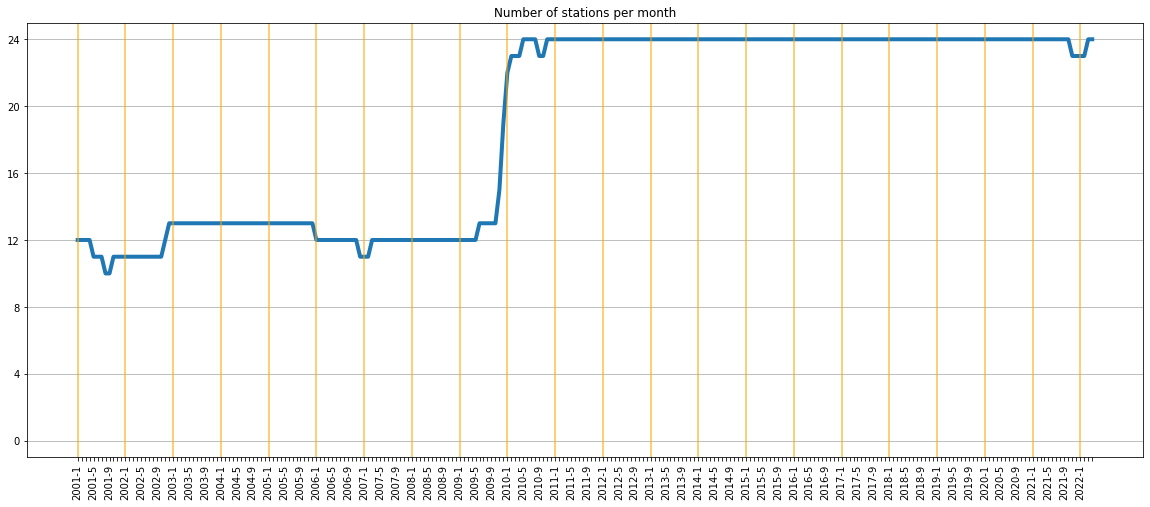

In [51]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
ax.plot(df_v.iloc[:-1, -2], lw=4)
ax.set_title('Number of stations per month')
xticks = [''] * 256
aux = (df_v.year.astype(str) + '-' + df_v.month.astype(str)).values
for i in range(len(xticks)):
    if i % 4 == 0:
        xticks[i] = aux[i]
    if i % 12 == 0:
        ax.axvline(x=i, color='orange', alpha=0.7)
ax.grid(axis='y')
ax.set_xticklabels(xticks, rotation=90)
ax.set_ylim((-1, 25))
ax.yaxis.set_major_locator(mticker.FixedLocator(range(0,25,4)))
plt.show()

<ipython-input-52-5d427823417b>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticks, rotation=90)


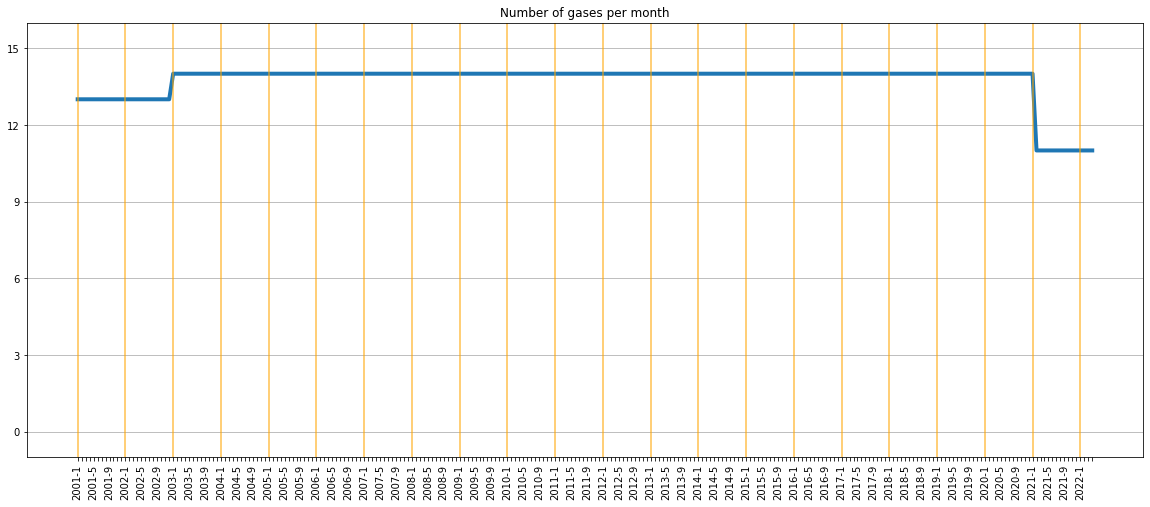

In [52]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
ax.plot(df_v.iloc[:-1, -1], lw=4)
ax.set_title('Number of gases per month')
xticks = [''] * 256
aux = (df_v.year.astype(str) + '-' + df_v.month.astype(str)).values
for i in range(len(xticks)):
    if i % 4 == 0:
        xticks[i] = aux[i]
    if i % 12 == 0:
        ax.axvline(x=i, color='orange', alpha=0.7)
ax.grid(axis='y')
ax.set_xticklabels(xticks, rotation=90)
ax.set_ylim((-1, 16))
ax.yaxis.set_major_locator(mticker.FixedLocator(range(0,17,3)))
plt.show()

## Visualize distributions of gases

### Gases

In [68]:
tic = time.time()
gases = {'{:02}'.format(g): np.array([]) for g in g_set}
for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for g in g_set:
        aux = df.loc[df.MAGNITUD == g, 'H01':'H24':2].values.ravel()
        mask = df.loc[df.MAGNITUD == g, 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
        if len(mask) == 0: continue
        aux = aux[mask]
        vc = '{:02}'.format(g)
        gases[vc] = np.concatenate((gases[vc], aux))
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:00:27 in total


We split CO, TCH, CH4 and NMCH into a different plot because they are measured in mg/m³:

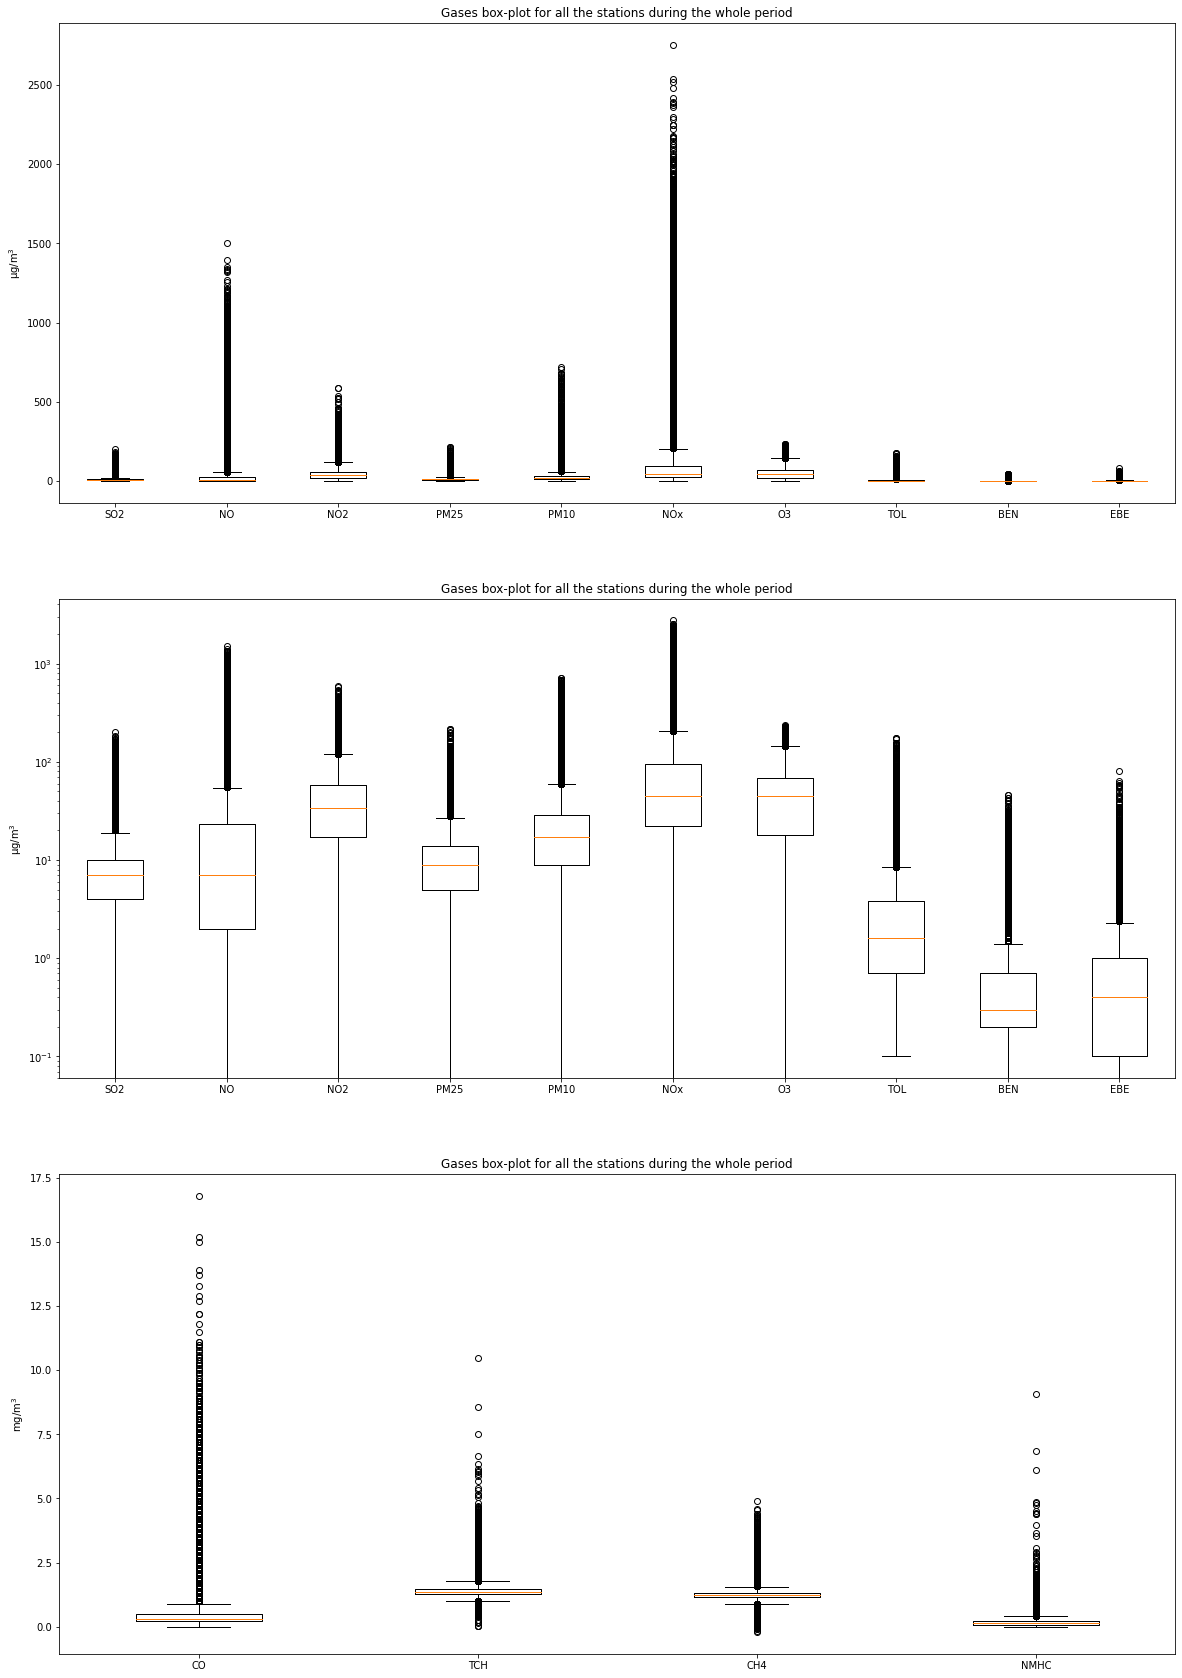

In [70]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(20, 30)
axs = axs.ravel()

axs[0].boxplot([gases[g] for g in gases_in_mug])
axs[0].set_title('Gases box-plot for all the stations during the whole period')
axs[0].set_xticklabels([vc_map[g] for g in gases_in_mug])
axs[0].set_ylabel('μg/m$^3$')

axs[1].boxplot([gases[g] for g in gases_in_mug])
axs[1].set_title('Gases box-plot for all the stations during the whole period')
axs[1].set_xticklabels([vc_map[g] for g in gases_in_mug])
axs[1].set_ylabel('μg/m$^3$')
axs[1].set_yscale('log')

axs[2].boxplot([gases[g] for g in gases_in_mg])
axs[2].set_title('Gases box-plot for all the stations during the whole period')
axs[2].set_xticklabels([vc_map[g] for g in gases_in_mg])
axs[2].set_ylabel('mg/m$^3$')

plt.savefig('./graphs/madrid_gases_spread.png', bbox_inches='tight')
plt.show()

In [73]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases.keys())
aux.index.set_names(['code'], inplace=True)
for k in gases.keys():
    aux.loc[k, 'min'] = gases[k].min()
    aux.loc[k, 'mean'] = gases[k].mean()
    aux.loc[k, 'median'] = np.median(gases[k])
    aux.loc[k, 'max'] = gases[k].max()
    aux.loc[k, 'std'] = gases[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux.sort_values('code', inplace=True)
aux = aux[['code', 'gas', 'min', 'mean', 'median', 'max', 'std']]
aux.to_csv('./variables-stats/madrid_gases.csv', index=False)
aux

code   gas   min       mean median      max         std
0    01   SO2  0.00   8.531437   7.00   199.00    7.399099
2    06    CO  0.00   0.425366   0.30    16.80    0.385224
3    07    NO  0.00  25.808452   7.00  1502.00   54.883410
4    08   NO2  0.00  41.121209  34.00   586.00   31.152513
5    09  PM25  0.00  11.112877   9.00   215.00    8.930240
6    10  PM10  0.00  22.489369  17.00   721.00   21.026431
8    12   NOx  0.00  80.683271  45.00  2755.00  108.019257
10   14    O3  0.00  46.813639  44.89   235.70   32.713721
12   20   TOL  0.10   2.987406   1.60   174.20    4.255430
13   30   BEN  0.00   0.662704   0.30    45.40    0.984969
1    35   EBE  0.00   0.711039   0.40    81.50    1.095621
7    42   TCH  0.03   1.406655   1.36    10.48    0.218668
9    43   CH4 -0.21   1.242590   1.22     4.91    0.188761
11   44  NMHC  0.00   0.165824   0.13     9.07    0.136565

### Gases from 2010

In [75]:
tic = time.time()
gases = {'{:02}'.format(g): np.array([]) for g in g_set}
for f in df_v.index[:-1]:
    if df_v.loc[f, 'year'] < 2010:
        continue
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for g in g_set:
        aux = df.loc[df.MAGNITUD == g, 'H01':'H24':2].values.ravel()
        mask = df.loc[df.MAGNITUD == g, 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
        if len(mask) == 0: continue
        aux = aux[mask]
        vc = '{:02}'.format(g)
        gases[vc] = np.concatenate((gases[vc], aux))
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:00:16 in total


We split CO, TCH, CH4 and NMCH into a different plot because they are measured in mg/m³:

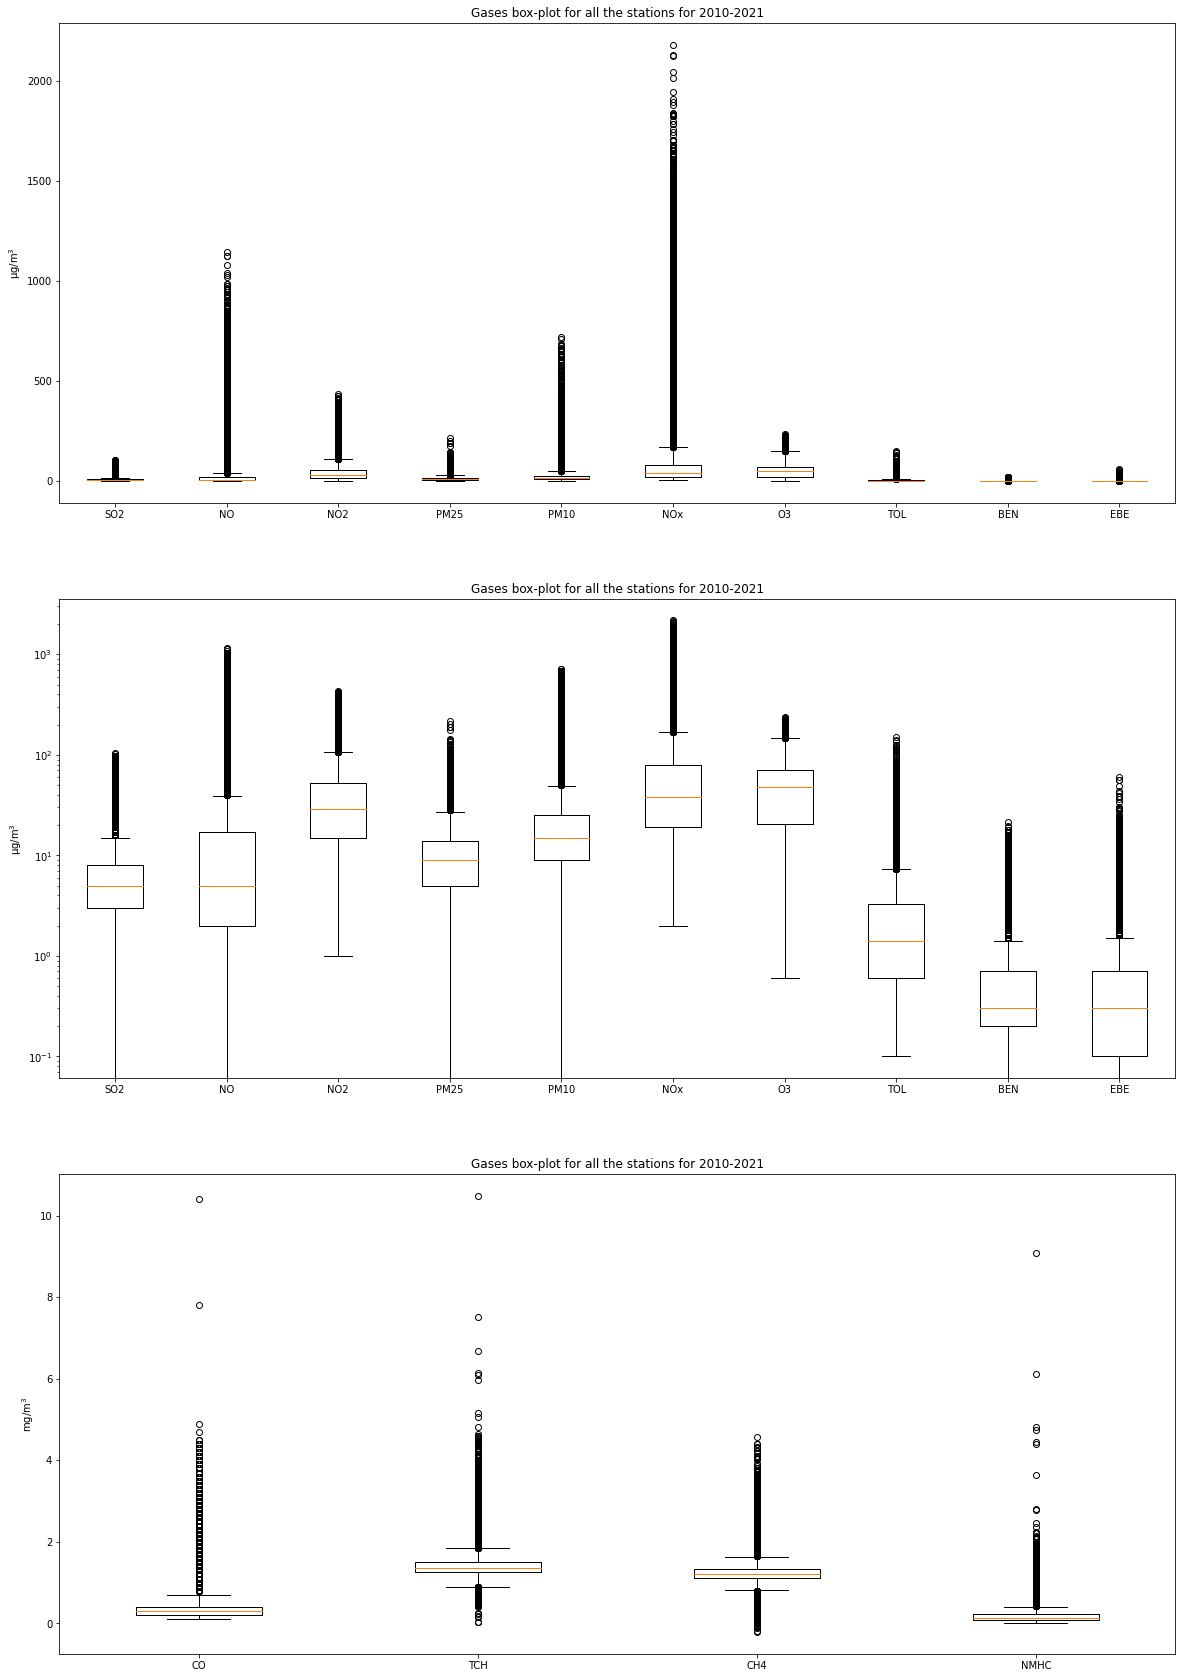

In [84]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(20, 30)
axs = axs.ravel()

axs[0].boxplot([gases[g] for g in gases_in_mug])
axs[0].set_title('Gases box-plot for all the stations for 2010-2021')
axs[0].set_xticklabels([vc_map[g] for g in gases_in_mug])
axs[0].set_ylabel('μg/m$^3$')

axs[1].boxplot([gases[g] for g in gases_in_mug])
axs[1].set_title('Gases box-plot for all the stations for 2010-2021')
axs[1].set_xticklabels([vc_map[g] for g in gases_in_mug])
axs[1].set_ylabel('μg/m$^3$')
axs[1].set_yscale('log')

axs[2].boxplot([gases[g] for g in gases_in_mg])
axs[2].set_title('Gases box-plot for all the stations for 2010-2021')
axs[2].set_xticklabels([vc_map[g] for g in gases_in_mg])
axs[2].set_ylabel('mg/m$^3$')

plt.savefig('./graphs/madrid_gases_spread_2010_2022.png', bbox_inches='tight')
plt.show()

In [85]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases.keys())
aux.index.set_names(['code'], inplace=True)
for k in gases.keys():
    aux.loc[k, 'min'] = gases[k].min()
    aux.loc[k, 'mean'] = gases[k].mean()
    aux.loc[k, 'median'] = np.median(gases[k])
    aux.loc[k, 'max'] = gases[k].max()
    aux.loc[k, 'std'] = gases[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux = aux[['code', 'gas', 'min', 'mean', 'median', 'max', 'std']]
aux.sort_values('code', inplace=True)
aux.to_csv('./variables-stats/madrid_gases_2010_2022.csv', index=False)
aux

code   gas   min       mean median      max        std
0    01   SO2  0.00   6.503755   5.00   104.00   4.801001
2    06    CO  0.10   0.347756   0.30    10.40   0.243974
3    07    NO  0.00  20.265659   5.00  1146.00  44.893749
4    08   NO2  1.00  37.047018  29.00   435.00  29.458026
5    09  PM25  0.00  10.472456   9.00   215.00   8.092433
6    10  PM10  0.00  19.662163  15.00   721.00  18.065001
8    12   NOx  2.00  68.096443  38.00  2180.00  92.500127
10   14    O3  0.60  48.954868  48.05   235.70  32.929233
12   20   TOL  0.10   2.527277   1.40   149.60   3.390069
13   30   BEN  0.00   0.610656   0.30    21.40   0.781898
1    35   EBE  0.00   0.605939   0.30    60.80   0.975721
7    42   TCH  0.03   1.409316   1.36    10.48   0.233532
9    43   CH4 -0.21   1.240192   1.21     4.56   0.208781
11   44  NMHC  0.00   0.170196   0.14     9.07   0.139685

### Gases per station

In [88]:
tic = time.time()
gases = {('{:02}'.format(g), '{:02}'.format(st)): np.array([]) for g in g_set for st in s_set}
for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for st in s_set:
        for g in g_set:
            aux = df.loc[(df.MAGNITUD == g) & (df.ESTACION == st), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == g) & (df.ESTACION == st), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            vc, sc = '{:02}'.format(g), '{:02}'.format(st)
            gases[(vc, sc)] = np.concatenate((gases[vc, sc], aux))
for k in list(gases.keys()):
    if len(gases[k]) == 0:
        gases.pop(k)
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:04:39 in total


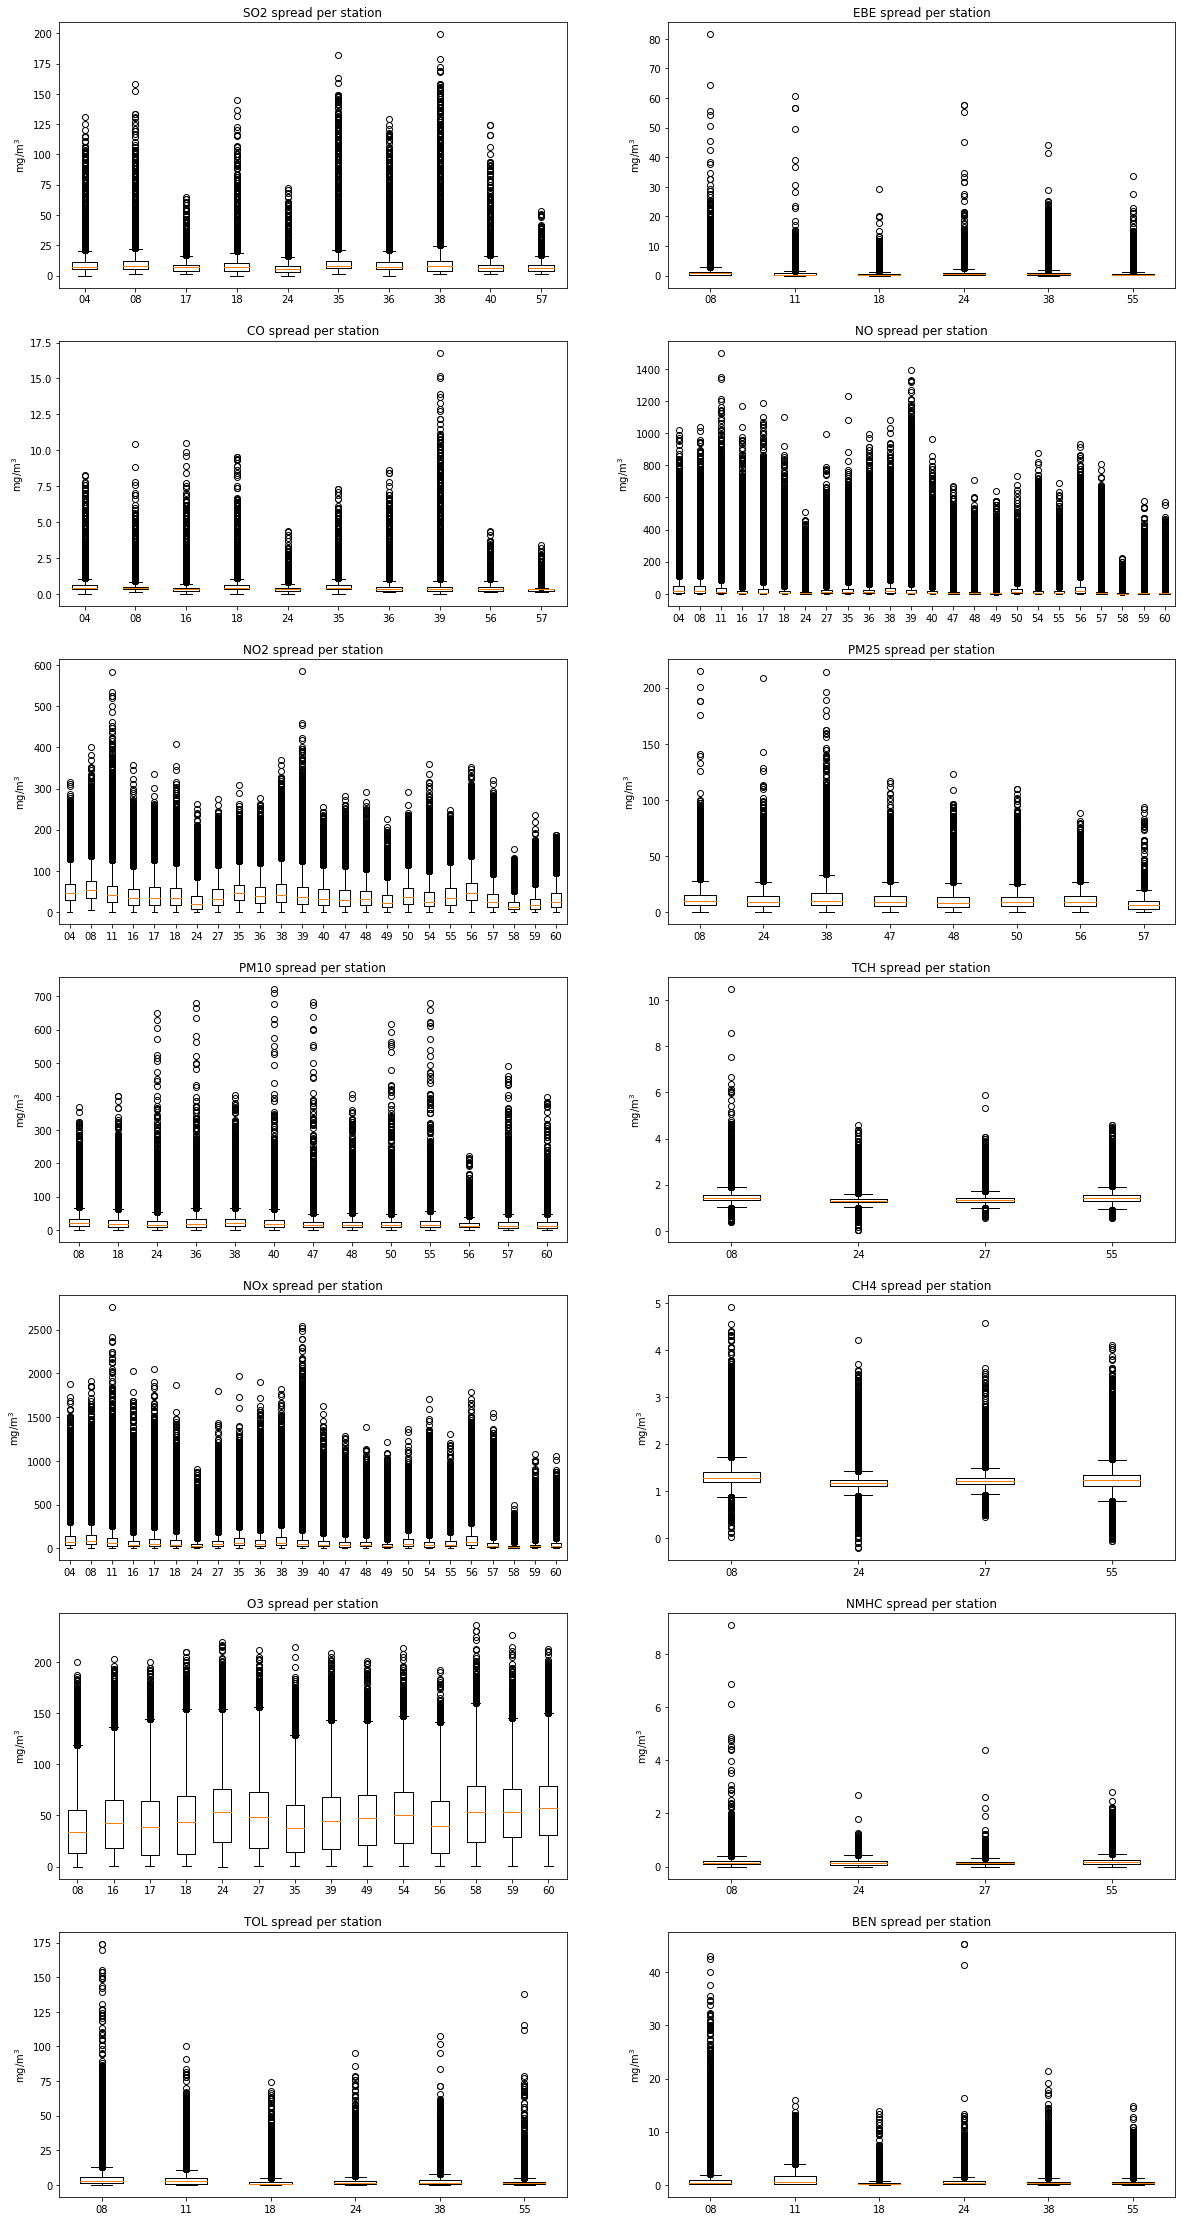

In [89]:
fig, axs = plt.subplots(7, 2)
fig.set_size_inches(20, 40)
axs = axs.ravel()
for idx, g in enumerate(g_set):
    vc = '{:02}'.format(g)
    l = list()
    labels = list()
    for st in s_set:
        sc = '{:02}'.format(st)
        if (vc, sc) in gases.keys():
            l.append(gases[(vc, sc)])
            labels.append(sc)
    axs[idx].boxplot(l)
    axs[idx].set_xticklabels(labels)
    axs[idx].set_title(vc_map[vc] + ' spread per station')
    axs[idx].set_ylabel('μg/m$^3$' if g in gases_in_mug else 'mg/m$^3$')
plt.savefig('./graphs/madrid_gases_per_station.png', bbox_inches='tight')
plt.show()

In [91]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases.keys())
aux.index.set_names(['code', 'station'], inplace=True)
for k in gases.keys():
    aux.loc[k, 'min'] = gases[k].min()
    aux.loc[k, 'mean'] = gases[k].mean()
    aux.loc[k, 'median'] = np.median(gases[k])
    aux.loc[k, 'max'] = gases[k].max()
    aux.loc[k, 'std'] = gases[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux = aux[['code', 'gas', 'station', 'min', 'mean', 'median', 'max', 'std']]
aux.sort_values(['code', 'station'], inplace=True)
aux.to_csv('./variables-stats/madrid_gases_per_station.csv', index=False)
aux

code   gas station   min      mean median     max       std
0     01   SO2      04  0.00  9.152458   7.00  131.00  7.214585
1     01   SO2      08  1.00  9.900105   8.00  158.00  8.272572
2     01   SO2      17  1.00  7.363919   7.00   65.00  4.367184
3     01   SO2      18  0.00  7.875275   7.00  145.00  6.029490
4     01   SO2      24  0.00  5.666538   5.00   72.00  3.746220
..   ...   ...     ...   ...       ...    ...     ...       ...
126   43   CH4      55 -0.06  1.237189   1.24    4.11  0.229524
141   44  NMHC      08  0.00  0.164576   0.14    9.07  0.137965
142   44  NMHC      24  0.00  0.153264   0.12    2.70  0.112761
143   44  NMHC      27  0.00  0.142331   0.13    4.40  0.083479
144   44  NMHC      55  0.00  0.215045   0.16    2.80  0.194346

[157 rows x 8 columns]

### Gas per period

In [156]:
import calendar

In [198]:
tic = time.time()
gases_h = {('{:02}'.format(g), h): np.array([]) for g in g_set for h in range(24)}
gases_w = {('{:02}'.format(g), w): np.array([]) for g in g_set for w in list(calendar.day_abbr)}
gases_m = {('{:02}'.format(g), m): np.array([]) for g in g_set for m in list(calendar.month_abbr[1:])}
gases_y = {('{:02}'.format(g), y): np.array([]) for g in g_set for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for g in g_set:
        vc = '{:02}'.format(g)
        for h in range(24):
            aux = df.loc[(df.MAGNITUD == g), 'H{:02}'.format(h+1)].values.ravel()
            mask = df.loc[(df.MAGNITUD == g), 'V{:02}'.format(h+1)].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            gases_h[(vc, h)] = np.concatenate((gases_h[vc, h], aux))
        for id_w, w in enumerate(list(calendar.day_abbr)):
            df['weekday'] = df[['ANO', 'MES', 'DIA']].apply(lambda x: calendar.weekday(*x), axis=1)
            aux = df.loc[(df.MAGNITUD == g) & (df.weekday == id_w), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == g) & (df.weekday == id_w), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            gases_w[(vc, w)] = np.concatenate((gases_w[vc, w], aux))
        for id_m, m in enumerate(list(calendar.month_abbr[1:])):
            aux = df.loc[(df.MAGNITUD == g) & (df.MES == id_m+1), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == g) & (df.MES == id_m+1), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            gases_m[(vc, m)] = np.concatenate((gases_m[vc, m], aux))
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == g) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == g) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            gases_y[(vc, y)] = np.concatenate((gases_y[vc, y], aux))

for k in list(gases_h.keys()):
    if len(gases_h[k]) == 0:
        gases_h.pop(k)
for k in list(gases_w.keys()):
    if len(gases_w[k]) == 0:
        gases_w.pop(k)
for k in list(gases_m.keys()):
    if len(gases_m[k]) == 0:
        gases_m.pop(k)
for k in list(gases_y.keys()):
    if len(gases_y[k]) == 0:
        gases_y.pop(k)
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:24:19 in total


**Per hour:**

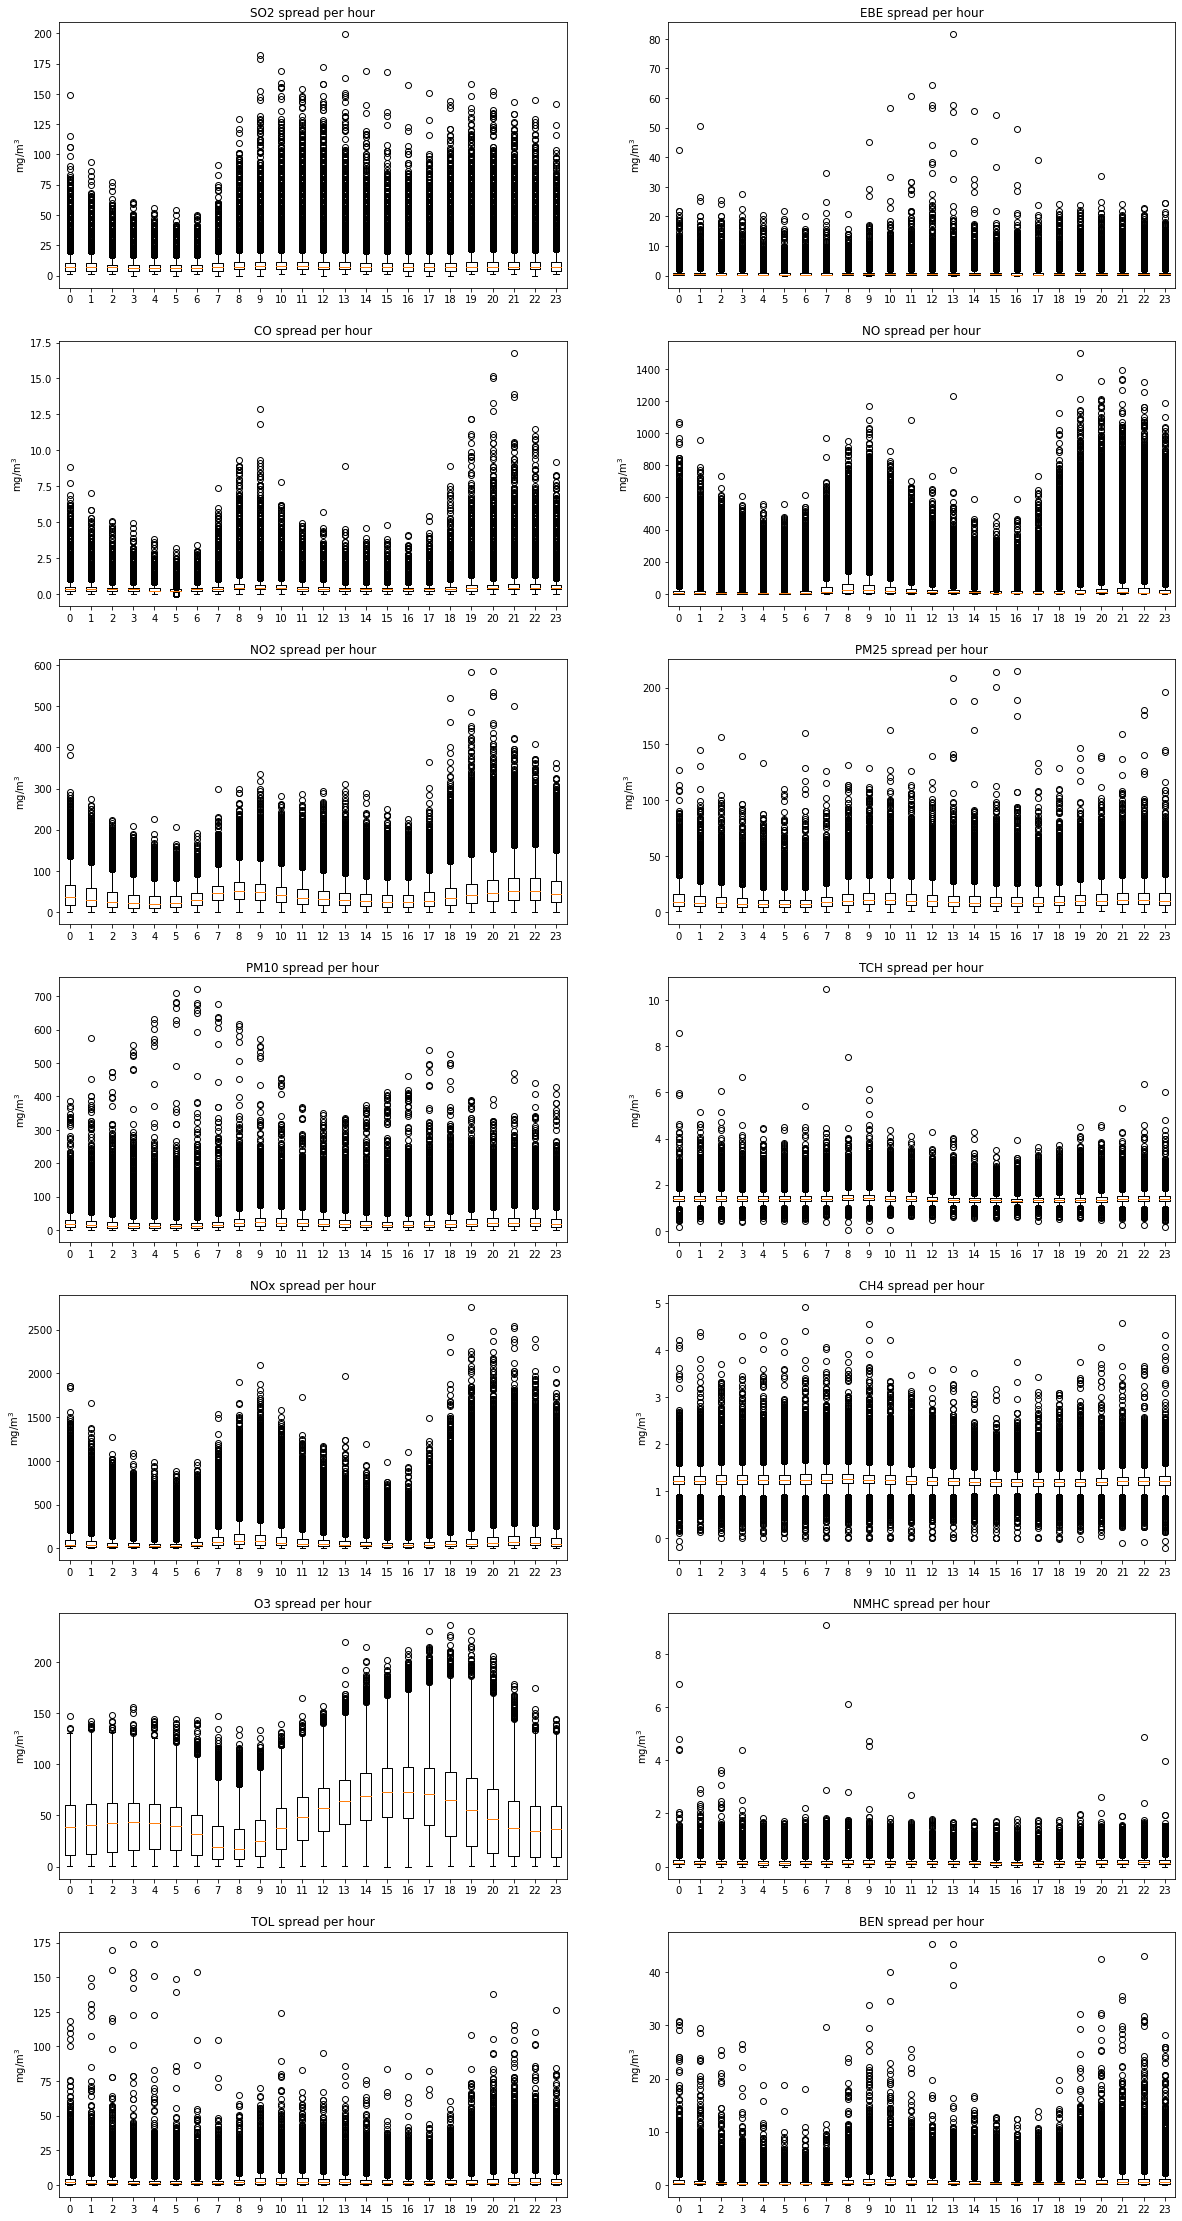

In [199]:
fig, axs = plt.subplots(7, 2)
fig.set_size_inches(20, 40)
axs = axs.ravel()
for idx, g in enumerate(g_set):
    vc = '{:02}'.format(g)
    l = list()
    labels = list()
    for h in range(24):
        if (vc, h) in gases_h.keys():
            l.append(gases_h[(vc, h)])
            labels.append(h)
    axs[idx].boxplot(l)
    axs[idx].set_xticklabels(labels)
    axs[idx].set_title(vc_map[vc] + ' spread per hour')
    axs[idx].set_ylabel('μg/m$^3$' if g in gases_in_mug else 'mg/m$^3$')
plt.savefig('./graphs/madrid_gases_per_hour.png', bbox_inches='tight')
plt.show()

In [200]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases_h.keys())
aux.index.set_names(['code', 'hour'], inplace=True)
for k in gases_h.keys():
    aux.loc[k, 'min'] = gases_h[k].min()
    aux.loc[k, 'mean'] = gases_h[k].mean()
    aux.loc[k, 'median'] = np.median(gases_h[k])
    aux.loc[k, 'max'] = gases_h[k].max()
    aux.loc[k, 'std'] = gases_h[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux = aux[['code', 'gas', 'hour', 'min', 'mean', 'median', 'max', 'std']]
aux.sort_values(['code', 'hour'], inplace=True)
aux.to_csv('./variables-stats/madrid_gases_per_hour.csv', index=False)
aux

code   gas  hour  min      mean median     max       std
0     01   SO2     0  1.0  8.222060   7.00  149.00  6.218175
1     01   SO2     1  1.0  7.712695   7.00   94.00  5.340787
2     01   SO2     2  1.0  7.300922   7.00   77.00  4.722793
3     01   SO2     3  0.0  6.998472   6.00   61.00  4.292661
4     01   SO2     4  1.0  6.776493   6.00   56.00  4.018634
..   ...   ...   ...  ...       ...    ...     ...       ...
283   44  NMHC    19  0.0  0.170440   0.14    1.97  0.138026
284   44  NMHC    20  0.0  0.180234   0.14    2.62  0.145053
285   44  NMHC    21  0.0  0.187936   0.15    1.91  0.147750
286   44  NMHC    22  0.0  0.190627   0.16    4.88  0.153496
287   44  NMHC    23  0.0  0.184352   0.15    3.98  0.148783

[336 rows x 8 columns]

**Per weekday:**

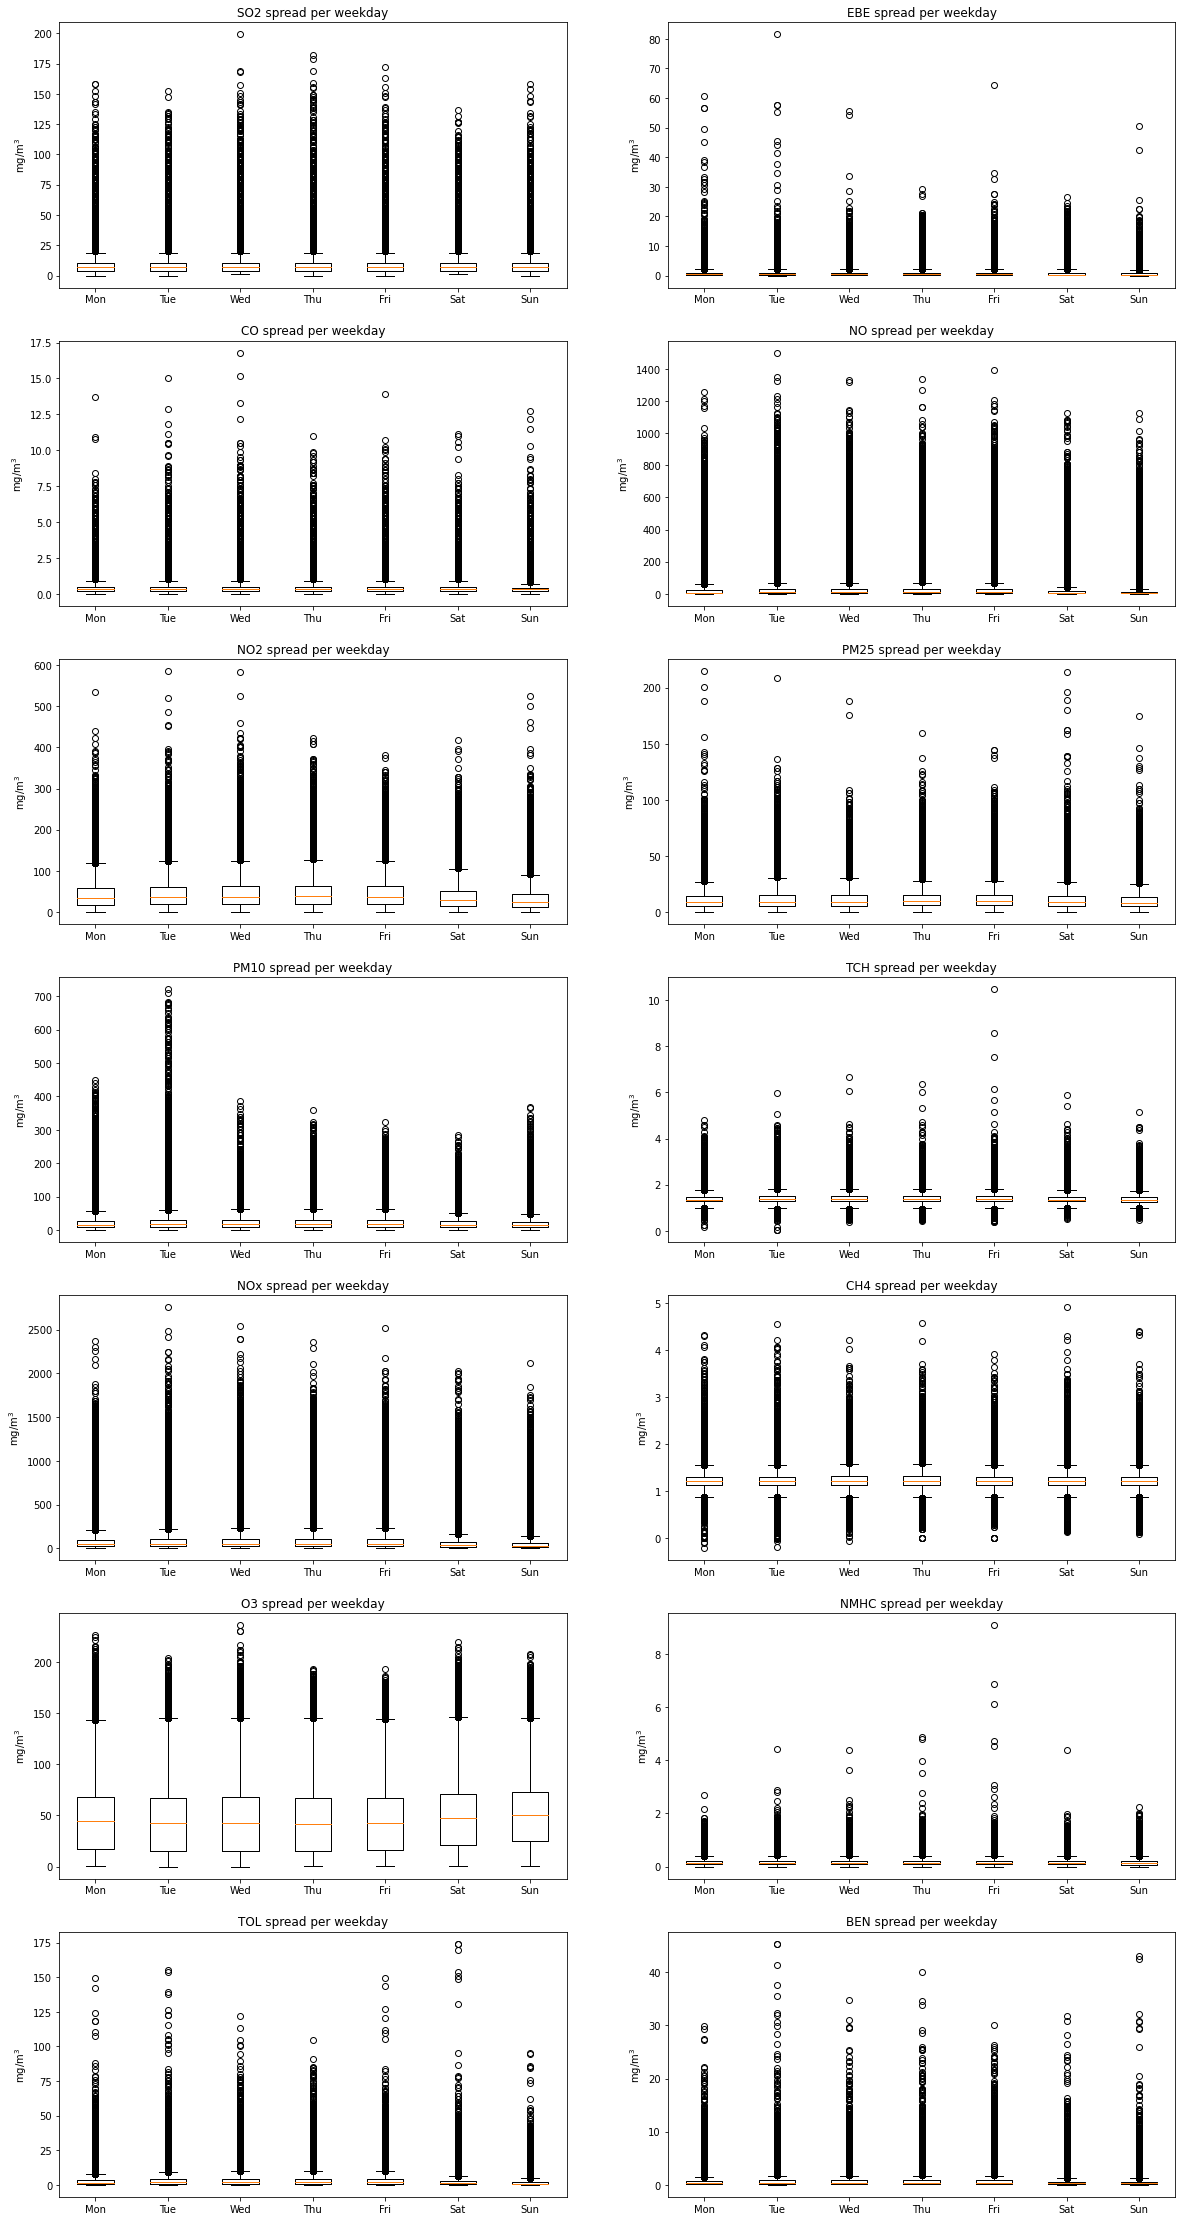

In [201]:
fig, axs = plt.subplots(7, 2)
fig.set_size_inches(20, 40)
axs = axs.ravel()
for idx, g in enumerate(g_set):
    vc = '{:02}'.format(g)
    l = list()
    labels = list()
    for w in list(calendar.day_abbr):
        if (vc, w) in gases_w.keys():
            l.append(gases_w[(vc, w)])
            labels.append(w)
    axs[idx].boxplot(l)
    axs[idx].set_xticklabels(labels)
    axs[idx].set_title(vc_map[vc] + ' spread per weekday')
    axs[idx].set_ylabel('μg/m$^3$' if g in gases_in_mug else 'mg/m$^3$')
plt.savefig('./graphs/madrid_gases_per_weekday.png', bbox_inches='tight')
plt.show()

In [202]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases_w.keys())
aux.index.set_names(['code', 'weekday'], inplace=True)
for k in gases_w.keys():
    aux.loc[k, 'min'] = gases_w[k].min()
    aux.loc[k, 'mean'] = gases_w[k].mean()
    aux.loc[k, 'median'] = np.median(gases_w[k])
    aux.loc[k, 'max'] = gases_w[k].max()
    aux.loc[k, 'std'] = gases_w[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux['weekdayId'] = aux.weekday.replace(dict(zip(calendar.day_abbr, range(7))))
aux = aux[['code', 'gas', 'weekday', 'weekdayId', 'min', 'mean', 'median', 'max', 'std']]
aux.sort_values(['code', 'weekdayId'], inplace=True)
aux.to_csv('./variables-stats/madrid_gases_per_weekday.csv', index=False)
aux

code   gas weekday  weekdayId  min      mean median     max       std
0    01   SO2     Mon          0  0.0  8.541791   7.00  158.00  7.468335
1    01   SO2     Tue          1  0.0  8.671084   7.00  152.00  7.415289
2    01   SO2     Wed          2  1.0  8.705661   7.00  199.00  7.588999
3    01   SO2     Thu          3  0.0  8.736972   7.00  182.00  7.580392
4    01   SO2     Fri          4  0.0  8.819669   7.00  172.00  7.822854
..  ...   ...     ...        ...  ...       ...    ...     ...       ...
79   44  NMHC     Wed          2  0.0  0.171000   0.14    4.40  0.138606
80   44  NMHC     Thu          3  0.0  0.171443   0.14    4.88  0.139678
81   44  NMHC     Fri          4  0.0  0.171708   0.14    9.07  0.147193
82   44  NMHC     Sat          5  0.0  0.159638   0.13    4.40  0.131699
83   44  NMHC     Sun          6  0.0  0.153203   0.12    2.23  0.127648

[98 rows x 9 columns]

**Per month:**

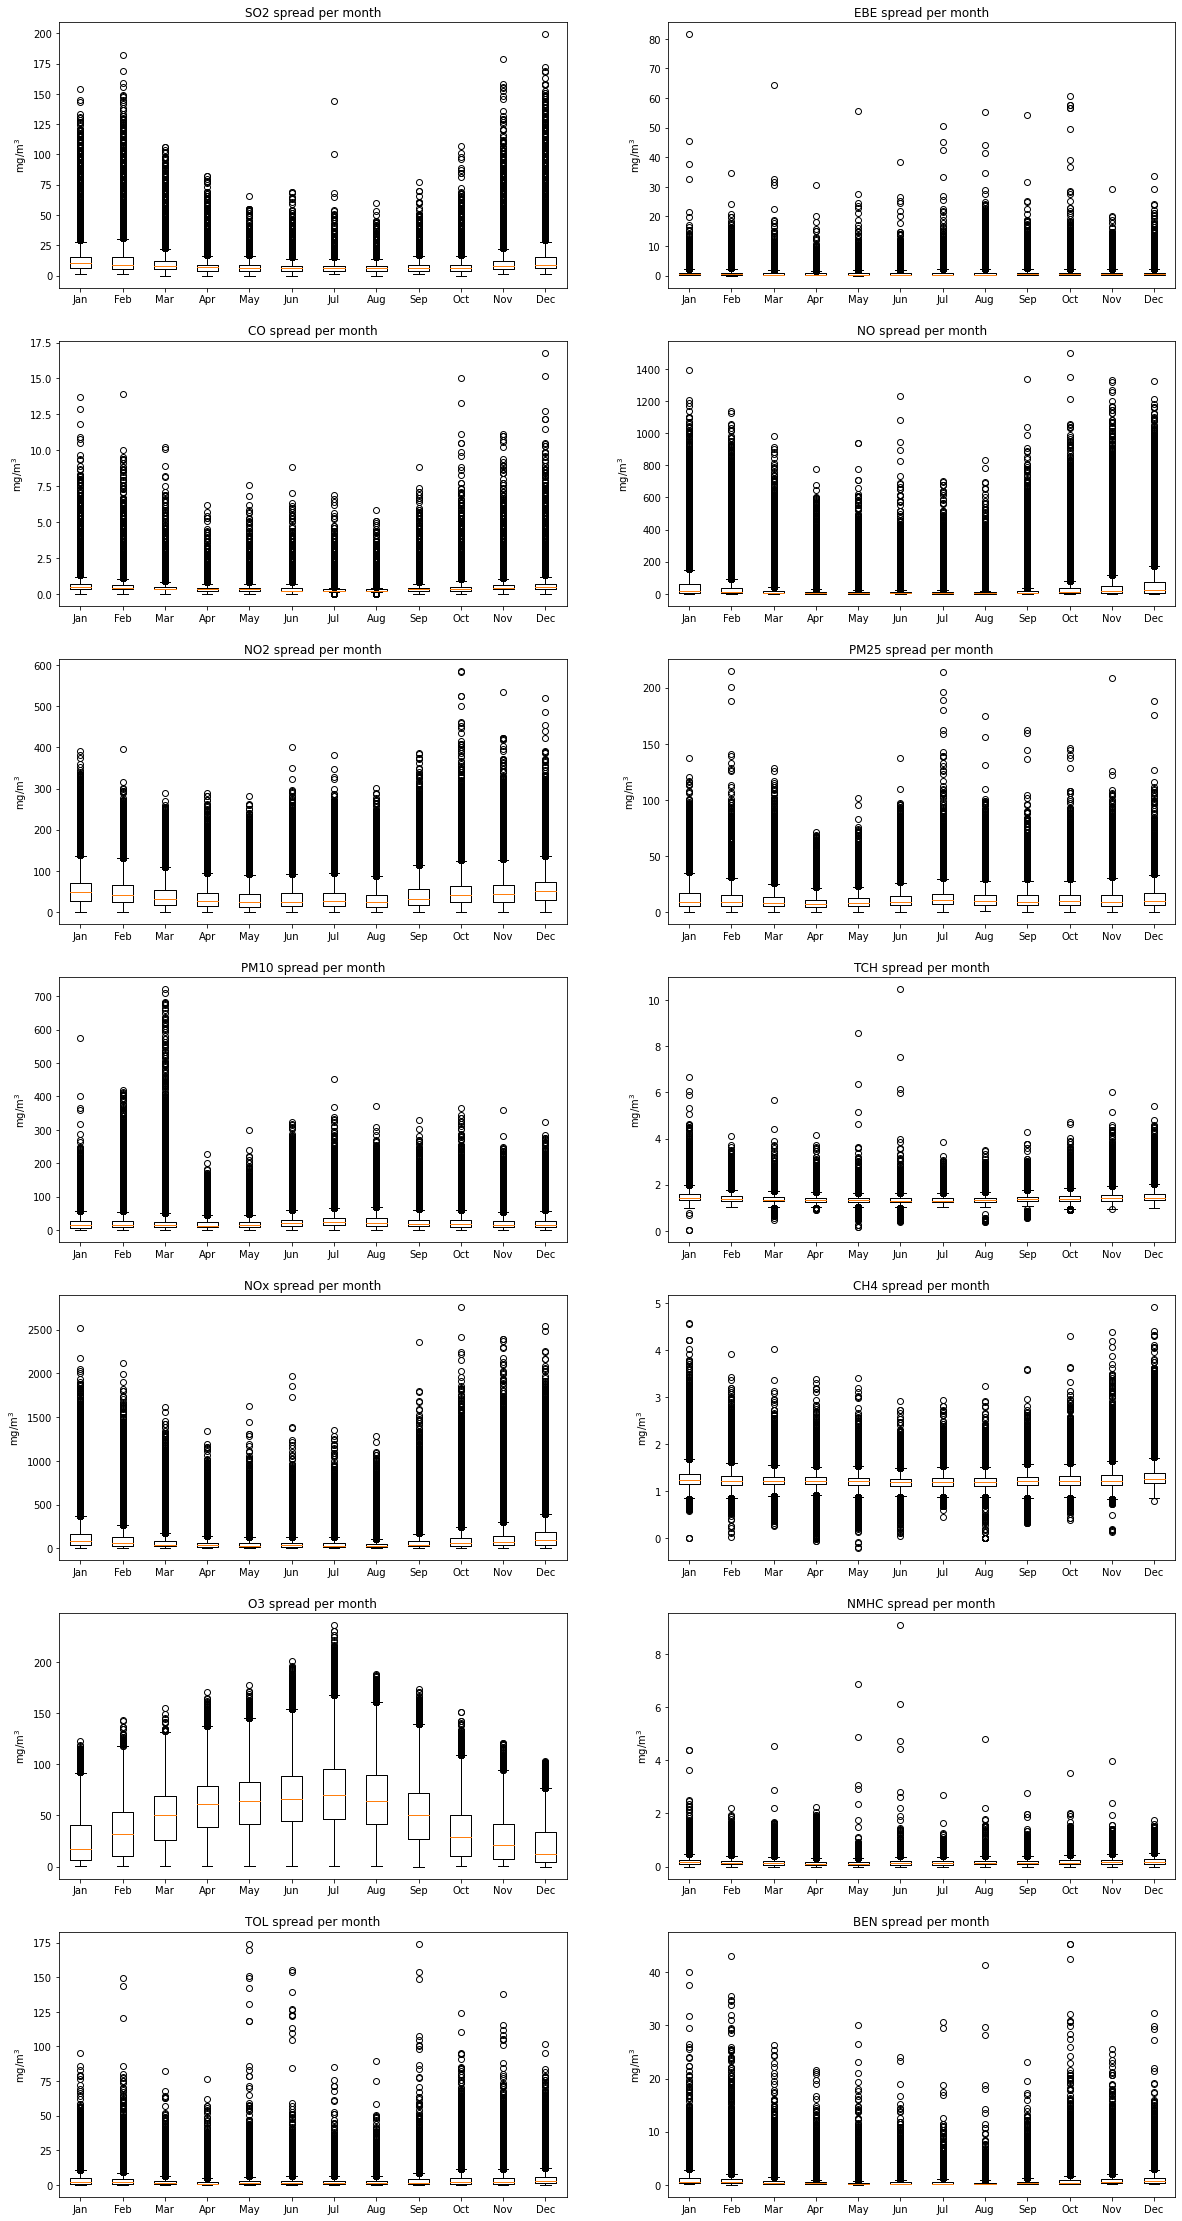

In [203]:
fig, axs = plt.subplots(7, 2)
fig.set_size_inches(20, 40)
axs = axs.ravel()
for idx, g in enumerate(g_set):
    vc = '{:02}'.format(g)
    l = list()
    labels = list()
    for id_m, m in enumerate(list(calendar.month_abbr[1:])):
        if (vc, m) in gases_m.keys():
            l.append(gases_m[(vc, m)])
            labels.append(m)
    axs[idx].boxplot(l)
    axs[idx].set_xticklabels(labels)
    axs[idx].set_title(vc_map[vc] + ' spread per month')
    axs[idx].set_ylabel('μg/m$^3$' if g in gases_in_mug else 'mg/m$^3$')
plt.savefig('./graphs/madrid_gases_per_month.png', bbox_inches='tight')
plt.show()

In [204]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases_m.keys())
aux.index.set_names(['code', 'month'], inplace=True)
for k in gases_m.keys():
    aux.loc[k, 'min'] = gases_m[k].min()
    aux.loc[k, 'mean'] = gases_m[k].mean()
    aux.loc[k, 'median'] = np.median(gases_m[k])
    aux.loc[k, 'max'] = gases_m[k].max()
    aux.loc[k, 'std'] = gases_m[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux['monthId'] = aux.month.replace(dict(zip(calendar.month_abbr[1:], range(12))))
aux = aux[['code', 'gas', 'month', 'monthId', 'min', 'mean', 'median', 'max', 'std']]
aux.sort_values(['code', 'monthId'], inplace=True)
aux.to_csv('./variables-stats/madrid_gases_per_month.csv', index=False)
aux

code   gas month  monthId  min       mean median     max        std
0     01   SO2   Jan        0  1.0  12.462789  10.00  154.00  10.820026
1     01   SO2   Feb        1  1.0  11.681367   9.00  182.00  10.331151
2     01   SO2   Mar        2  0.0   9.418750   8.00  106.00   7.164694
3     01   SO2   Apr        3  0.0   7.132822   7.00   82.00   4.723276
4     01   SO2   May        4  0.0   6.478511   6.00   66.00   3.740674
..   ...   ...   ...      ...  ...        ...    ...     ...        ...
139   44  NMHC   Aug        7  0.0   0.150434   0.12    4.81   0.114528
140   44  NMHC   Sep        8  0.0   0.170027   0.14    2.77   0.129022
141   44  NMHC   Oct        9  0.0   0.183406   0.15    3.53   0.137453
142   44  NMHC   Nov       10  0.0   0.200714   0.17    3.98   0.139145
143   44  NMHC   Dec       11  0.0   0.206888   0.17    1.76   0.143430

[168 rows x 9 columns]

**Per year:**

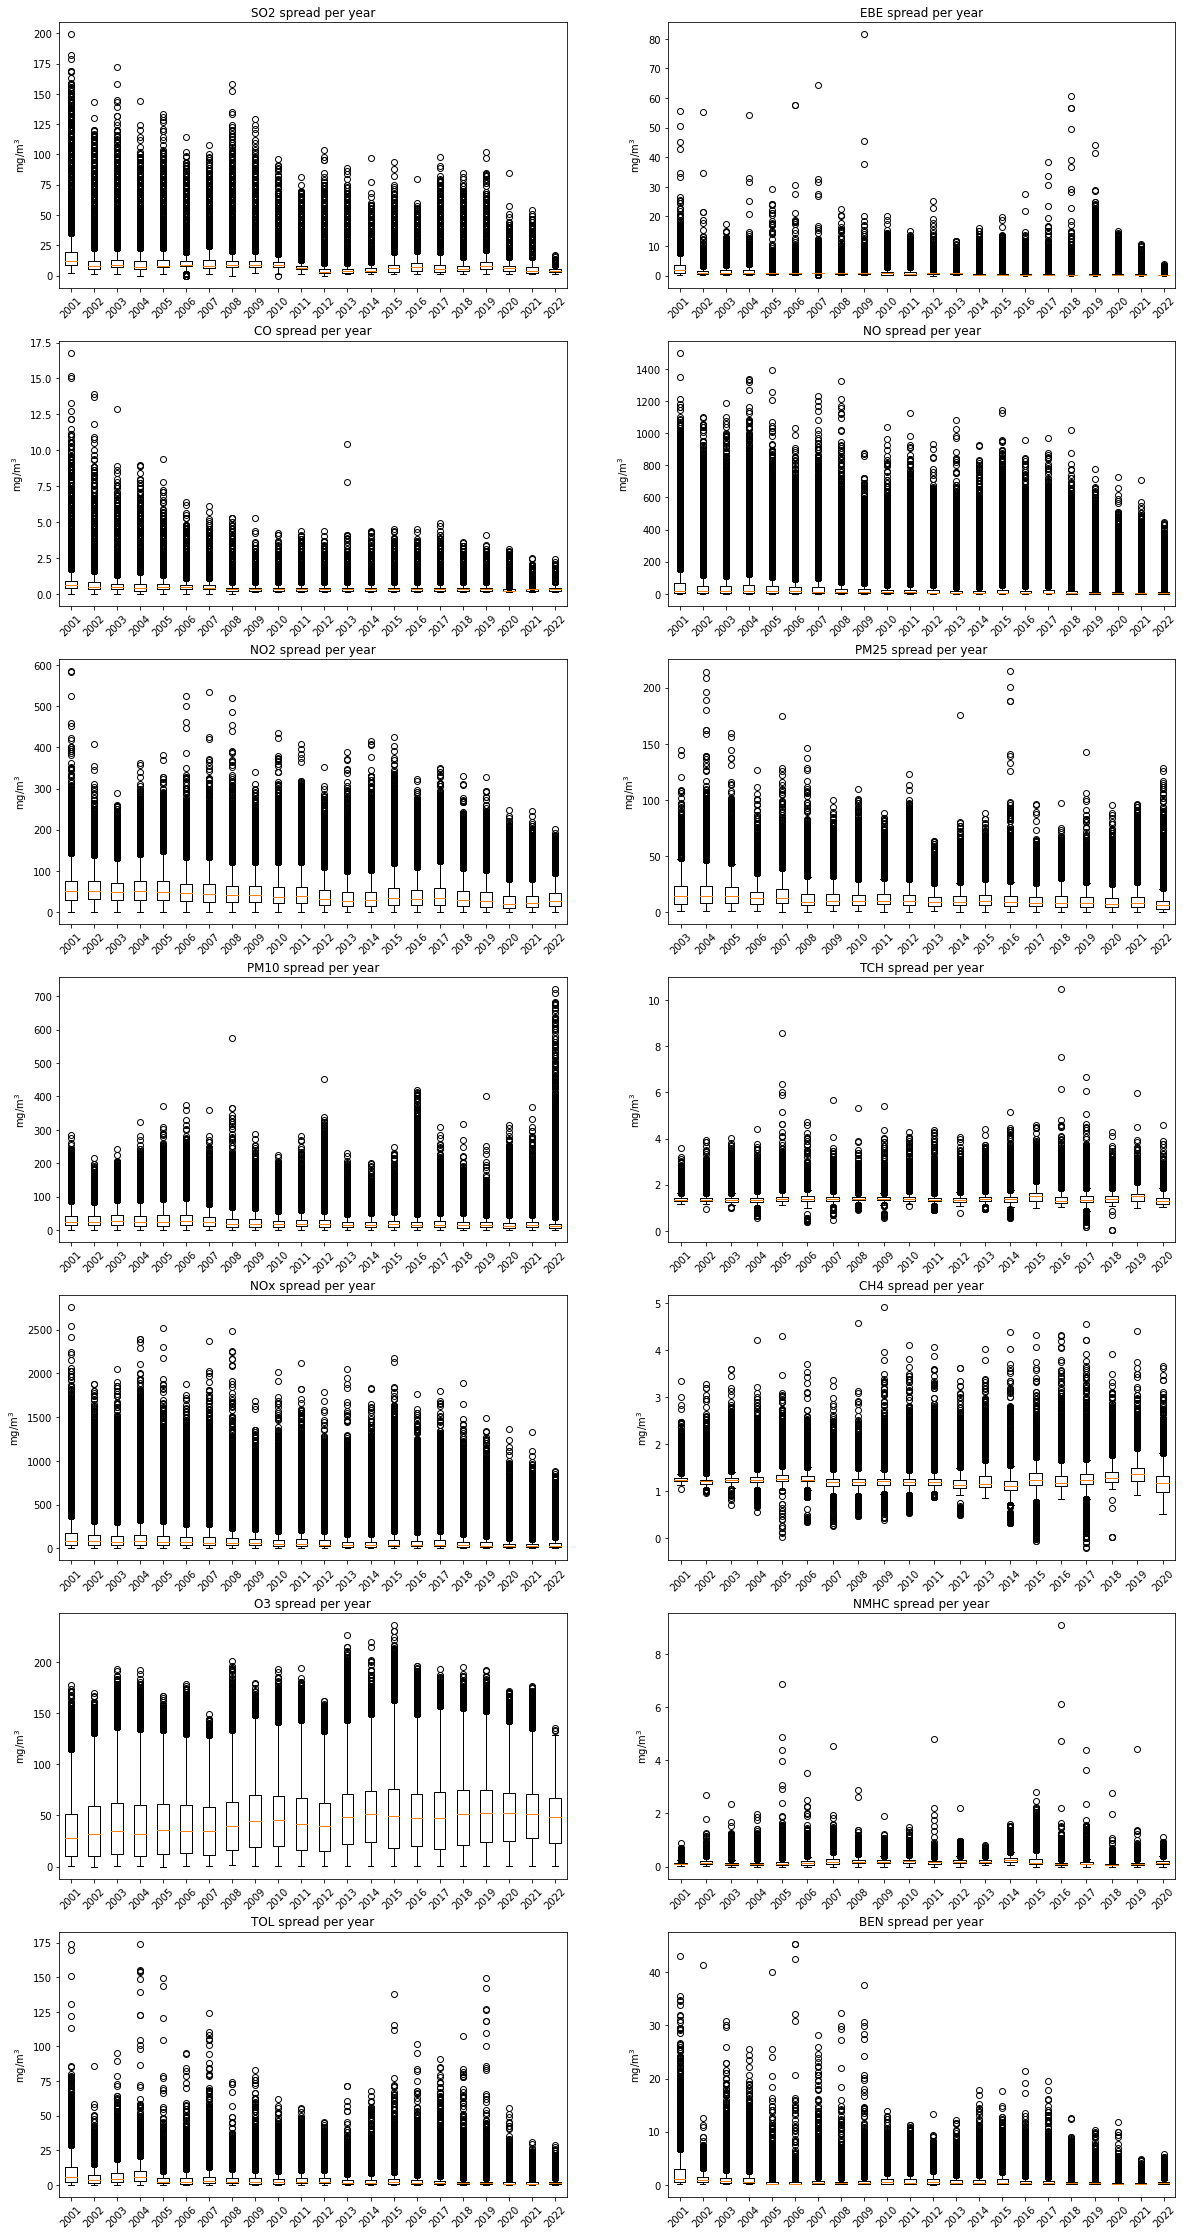

In [205]:
fig, axs = plt.subplots(7, 2)
fig.set_size_inches(20, 40)
axs = axs.ravel()
for idx, g in enumerate(g_set):
    vc = '{:02}'.format(g)
    l = list()
    labels = list()
    for y in range(2001, 2023):
        if (vc, y) in gases_y.keys():
            l.append(gases_y[(vc, y)])
            labels.append(y)
    axs[idx].boxplot(l)
    axs[idx].set_xticklabels(labels, rotation=45)
    axs[idx].set_title(vc_map[vc] + ' spread per year')
    axs[idx].set_ylabel('μg/m$^3$' if g in gases_in_mug else 'mg/m$^3$')
plt.savefig('./graphs/madrid_gases_per_year.png', bbox_inches='tight')
plt.show()

In [206]:
aux = pd.DataFrame(columns=['min', 'mean', 'median', 'max', 'std'], index=gases_y.keys())
aux.index.set_names(['code', 'year'], inplace=True)
for k in gases_y.keys():
    aux.loc[k, 'min'] = gases_y[k].min()
    aux.loc[k, 'mean'] = gases_y[k].mean()
    aux.loc[k, 'median'] = np.median(gases_y[k])
    aux.loc[k, 'max'] = gases_y[k].max()
    aux.loc[k, 'std'] = gases_y[k].std()
aux.reset_index(inplace=True)
aux['gas'] = aux.code.replace(vc_map)
aux = aux[['code', 'gas', 'year', 'min', 'mean', 'median', 'max', 'std']]
aux.sort_values(['code', 'year'], inplace=True)
aux.to_csv('./variables-stats/madrid_gases_per_year.csv', index=False)
aux

code   gas  year  min       mean median     max        std
0     01   SO2  2001  2.0  16.704335  12.00  199.00  14.344960
1     01   SO2  2002  1.0  10.556847   8.00  143.00   9.415634
2     01   SO2  2003  1.0  11.606610   9.00  172.00   8.919717
3     01   SO2  2004  0.0  10.464251   7.00  144.00   8.847285
4     01   SO2  2005  1.0  11.344793   8.00  133.00   8.564909
..   ...   ...   ...  ...        ...    ...     ...        ...
251   44  NMHC  2016  0.0   0.124340   0.11    9.07   0.117451
252   44  NMHC  2017  0.0   0.127865   0.11    4.40   0.094630
253   44  NMHC  2018  0.0   0.074967   0.06    2.77   0.059541
254   44  NMHC  2019  0.0   0.110609   0.09    4.44   0.086757
255   44  NMHC  2020  0.0   0.153812   0.13    1.12   0.102168

[300 rows x 8 columns]

## Stats of the gases 2010-2019

In [12]:
import sys
sys.path.append('../src/')
import learner

l = learner.DeepLearner()

In [13]:
vc_map = l.vc_map
gases_in_mug = l.gases_in_mug

### Average gases per hour (whole)

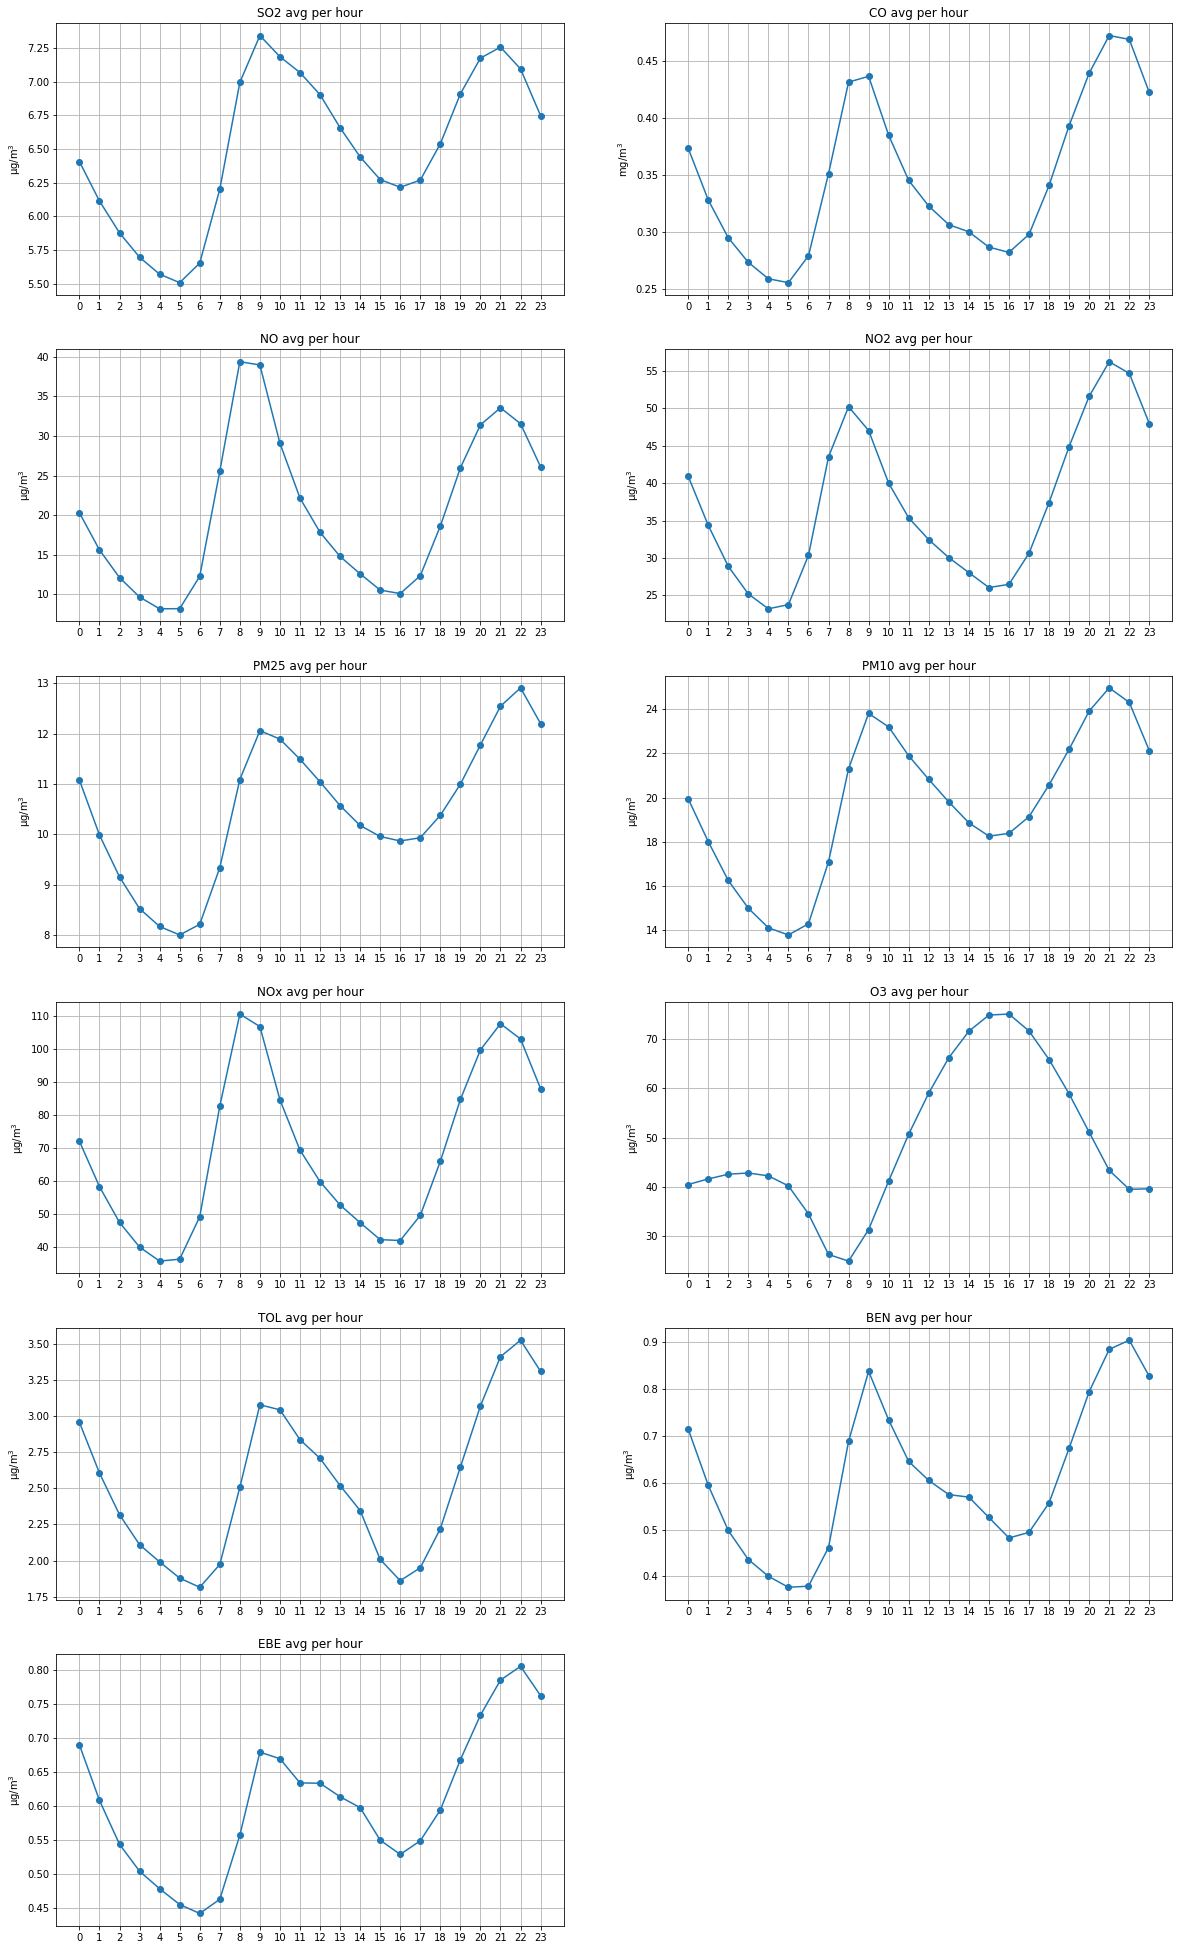

In [14]:
out_path = '../data/madrid/clean/01h_flat_raw.h5'

fig, axs = plt.subplots(6, 2)
fig.set_size_inches(20, 35)
axs = axs.ravel()

with tb.open_file(out_path, mode='r') as h5_file:
    for idx, vc in enumerate(vc_map.keys()):
        n = '/v{}'.format(vc)
        if n not in h5_file.root:
            continue
        li = []
        arr = h5_file.root[n][:]
        for h in range(24):
            li.append(np.nanmean(arr[h::24, 1:].ravel()))
        axs[idx].plot(li, '-o')
        axs[idx].xaxis.set_major_locator(mticker.FixedLocator(np.arange(24)))
        axs[idx].set_title(vc_map[vc] + ' avg per hour')
        axs[idx].set_ylabel('μg/m$^3$' if vc in gases_in_mug else 'mg/m$^3$')
        axs[idx].grid()
    axs[11].set_axis_off()
#plt.savefig('./graphs/madrid_gases_per_hour.pdf', bbox_inches='tight')
plt.show()

### Average gases per hour (2010-2019)

In [ ]:
fin = l._DeepLearner__datetime_to_idx(dt.datetime(2020, 1, 1))

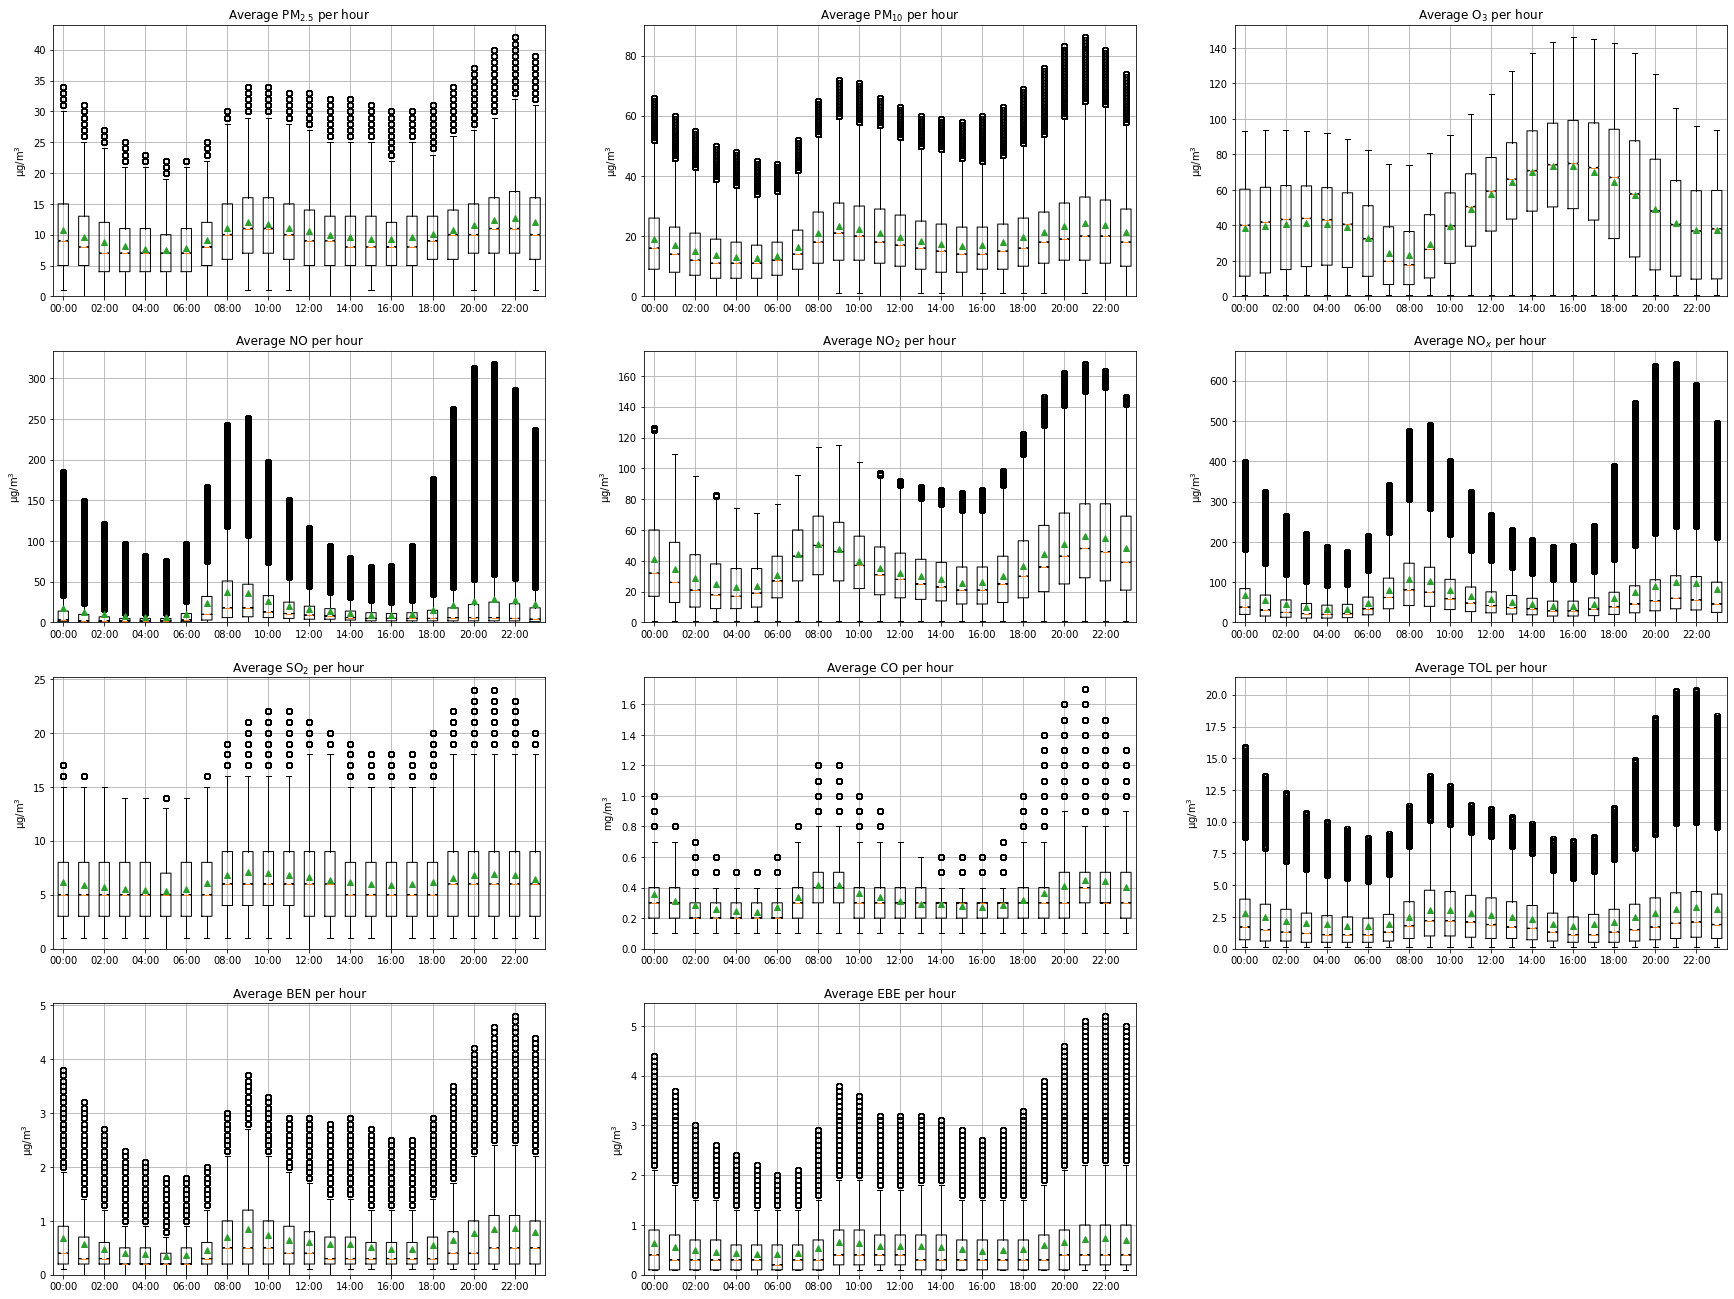

In [197]:
out_path = '../data/madrid/clean/01h_flat_raw.h5'

fig, axs = plt.subplots(4, 3)
fig.set_size_inches(30, 23)
axs = axs.ravel()

with tb.open_file(out_path, mode='r') as h5_file:
    for idx, vc in enumerate(['09', '10', '14', '07', '08', '12', '01', '06', '20', '30', '35']):
        n = '/v{}'.format(vc)
        if n not in h5_file.root:
            continue
        li = []
        arr = h5_file.root[n][:fin]
        for h in range(24):
            aux = arr[h::24, 1:].ravel()
            aux = aux[~np.isnan(aux)]
            p = 2
            #low = np.percentile(aux, p)
            high = np.percentile(aux, 100 - p)
            #li.append(aux[(aux > low) & (aux < high)])
            li.append(aux[(aux < high)])
        axs[idx].boxplot(li, '-o', showmeans=True)
        axs[idx].xaxis.set_major_locator(mticker.FixedLocator(np.arange(1, 25, 2)))
        axs[idx].set_xticklabels(['{:02}:00'.format(h) for h in range(0, 24, 2)])
        axs[idx].set_title('Average {} per hour'.format(l.vc_map_pretty[vc]))
        axs[idx].set_ylabel('μg/m$^3$' if vc in gases_in_mug else 'mg/m$^3$')
        axs[idx].set_ylim(bottom=0)
        axs[idx].grid()
        #axs[idx].set_yscale('log')
        #break
    axs[11].set_axis_off()
plt.savefig('./graphs/madrid_gases_per_hour_bp.png', bbox_inches='tight', dpi=200)
plt.show()

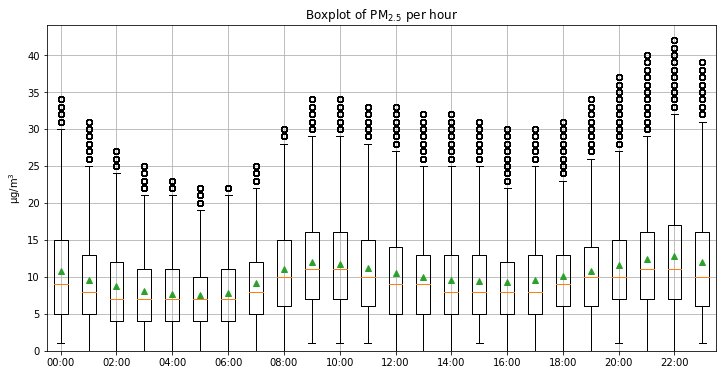

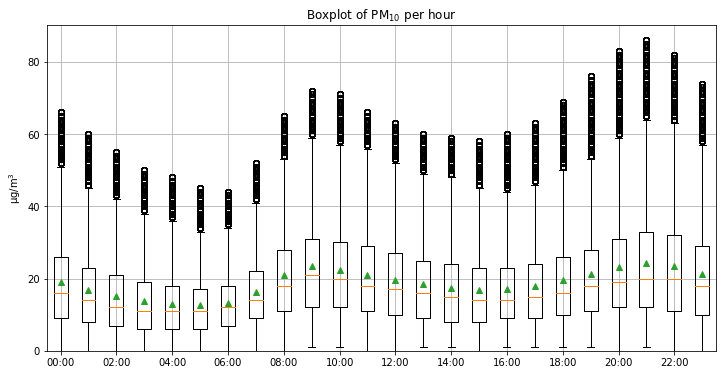

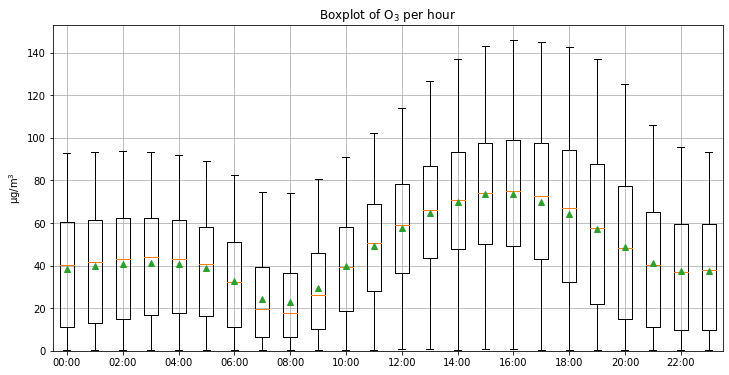

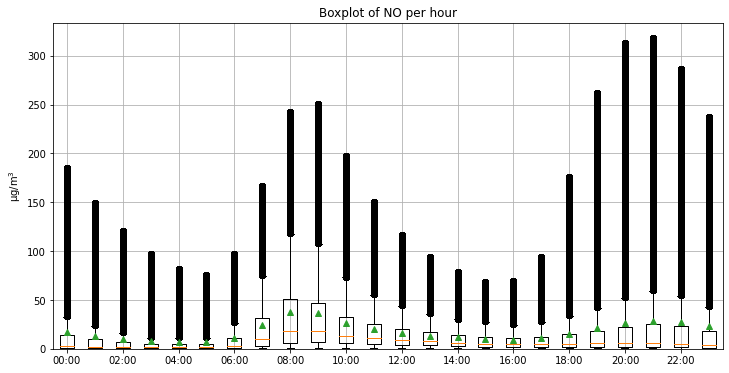

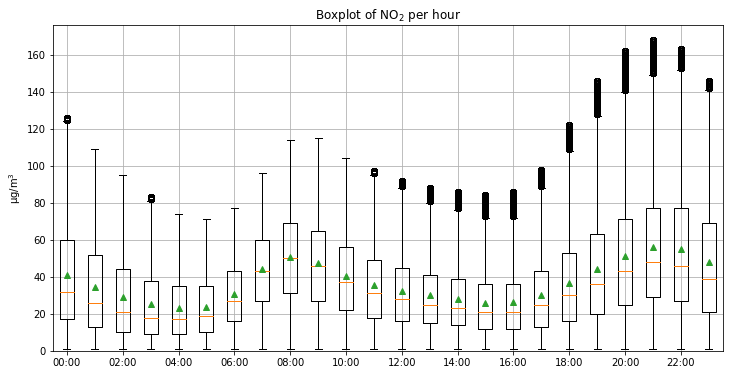

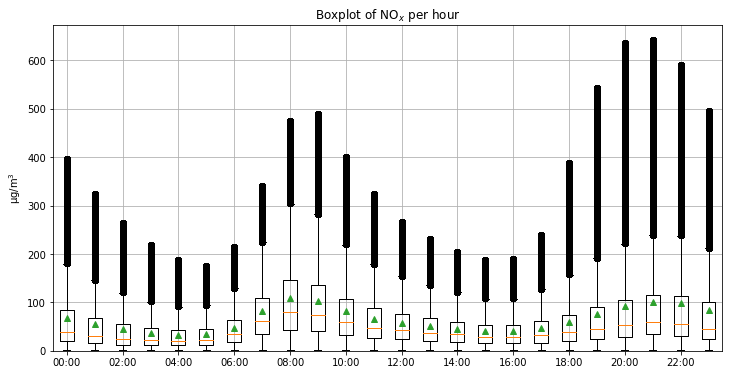

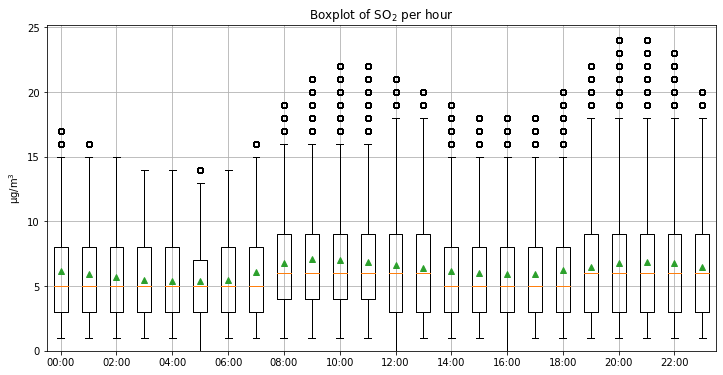

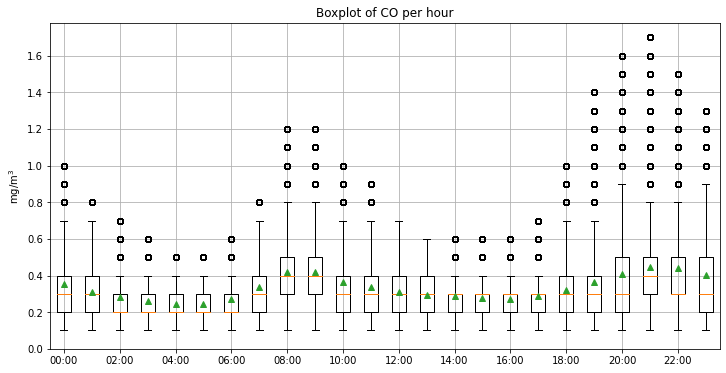

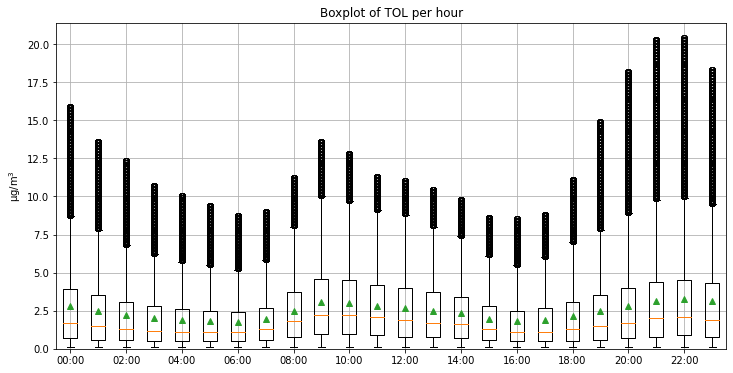

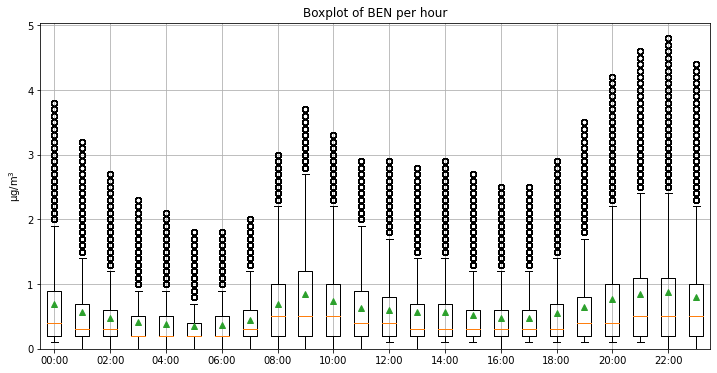

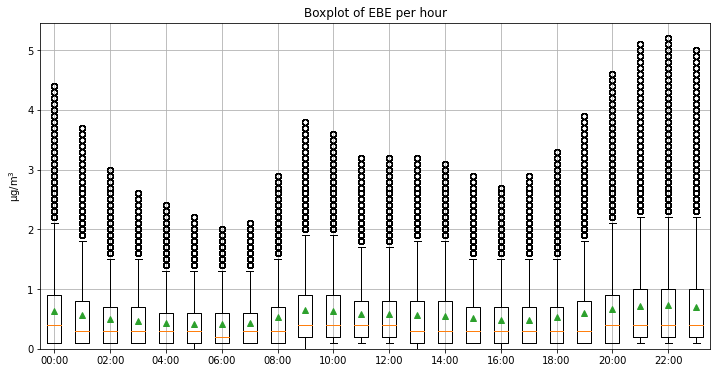

In [224]:
out_path = '../data/madrid/clean/01h_flat_raw.h5'

with tb.open_file(out_path, mode='r') as h5_file:
    for idx, vc in enumerate(['09', '10', '14', '07', '08', '12', '01', '06', '20', '30', '35']):
        fig, ax = plt.subplots()
        fig.set_size_inches(12, 6)
        n = '/v{}'.format(vc)
        if n not in h5_file.root:
            continue
        li = []
        arr = h5_file.root[n][:fin]
        for h in range(24):
            aux = arr[h::24, 1:].ravel()
            aux = aux[~np.isnan(aux)]
            p = 2
            #low = np.percentile(aux, p)
            high = np.percentile(aux, 100 - p)
            #li.append(aux[(aux > low) & (aux < high)])
            li.append(aux[(aux < high)])
        ax.boxplot(li, showmeans=True)
        ax.xaxis.set_major_locator(mticker.FixedLocator(np.arange(1, 25, 2)))
        ax.set_xticklabels(['{:02}:00'.format(h) for h in range(0, 24, 2)])
        ax.set_title('Boxplot of {} per hour'.format(l.vc_map_pretty[vc]))
        ax.set_ylabel('μg/m$^3$' if vc in gases_in_mug else 'mg/m$^3$')
        ax.set_ylim(bottom=0)
        ax.grid()
        #axs[idx].set_yscale('log')
        #break
    #axs[11].set_axis_off()
        plt.savefig('./graphs/madrid_gases_per_hour_bp_{}.png'.format(l.vc_map[vc]), bbox_inches='tight', dpi=100)
        #break
#plt.show()

### Stats table (2010-2019)

In [83]:
fin = l._DeepLearner__datetime_to_idx(dt.datetime(2020, 1, 1))

In [178]:
out_path = '../data/madrid/clean/01h_flat_raw.h5'

df = pd.DataFrame(columns=['count', 'min sensors', 'median sensors', 'max sensors', 'mean', 'std',
                           'min', '25%', '50%', '75%', 'max'], index=l.vn_map.keys())
df.index.set_names(['pollutant'], inplace=True)

with tb.open_file(out_path, mode='r') as h5_file:
    for idx, vc in enumerate(vc_map.keys()):
        n = '/v{}'.format(vc)
        if n not in h5_file.root:
            continue
        li = []
        arr_or = h5_file.root[n][:fin, 1:]
        arr = arr_or[~np.isnan(arr_or)].ravel().copy()
        p = 2
        #low = np.percentile(aux, p)
        high = np.percentile(arr, 100 - p)
        #li.append(aux[(aux > low) & (aux < high)])
        arr = arr[(arr < high)]
        # add to table
        #display(df.loc[l.vc_map[vc]])
        df.loc[l.vc_map[vc], 'count'] = arr.shape[0]
        df.loc[l.vc_map[vc], 'min sensors'] = (~np.isnan(arr_or[~np.isnan(arr_or).all(axis=1)])).sum(axis=1).min()
        df.loc[l.vc_map[vc], 'median sensors'] = int(np.median((~np.isnan(arr_or[~np.isnan(arr_or).all(axis=1)])).sum(axis=1)))
        df.loc[l.vc_map[vc], 'max sensors'] = (~np.isnan(arr_or)).sum(axis=1).max()
        df.loc[l.vc_map[vc], 'mean'] = arr.mean().round(2)
        df.loc[l.vc_map[vc], 'std'] = arr.std().round(2)
        df.loc[l.vc_map[vc], 'min'] = arr.min()
        df.loc[l.vc_map[vc], '25%'] = np.percentile(arr, 25)
        df.loc[l.vc_map[vc], '50%'] = np.percentile(arr, 50)
        df.loc[l.vc_map[vc], '75%'] = np.percentile(arr, 75)
        df.loc[l.vc_map[vc], 'max'] = arr.max()
df.reset_index(inplace=True)
df = df.loc[[4, 5, 7, 2, 3, 6, 0, 1, 8, 9, 10], :]
df.to_csv('./variables-stats/gases_stats_2010_2019.csv', index=False)
df

pollutant    count min sensors median sensors max sensors   mean    std  \
4       PM25   497512           1              6           7  10.10   6.41   
5       PM10  1012481           1             12          13  18.62  12.95   
7         O3  1187574          10             14          14  46.83  31.19   
2         NO  2037902          17             24          24  17.12  28.41   
3        NO2  2037535          17             24          24  36.71  25.73   
6        NOx  2037818          17             24          24  63.23  65.01   
0        SO2   847376           6             10          10   6.25   3.83   
1         CO   846442           6             10          10   0.33   0.17   
8        TOL   493950           2              6           6   2.41   2.39   
9        BEN   495486           2              6           6   0.59   0.61   
10       EBE   494176           2              6           6   0.55   0.58   

    min    25%    50%    75%    max  
4   0.0   5.00   9.00  14.00   32.0  
5   0.0   9.00  16.00  25.00   66.0  
7   0.6  18.96  46.27  69.65  123.7  
2   0.0   2.00   6.00  18.00  178.0  
3   1.0  16.00  31.00  52.00  119.0  
6   2.0  20.00  40.00  81.00  380.0  
0   0.0   3.00   5.00   8.00   19.0  
1   0.1   0.20   0.30   0.40    1.0  
8   0.1   0.70   1.50   3.50   12.5  
9   0.0   0.20   0.40   0.70    3.2  
10  0.0   0.10   0.30   0.80    3.4

## Evolution over time

Plaza España:

In [117]:
tic = time.time()
gases = {('{:02}'.format(g), y): np.array([]) for g in [1, 8, 6] for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for g in [1, 8, 6]:
        vc = '{:02}'.format(g)
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == g) & (df.ESTACION == 4) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == g) & (df.ESTACION == 4) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]    
            gases[(vc, y)] = np.concatenate((gases[vc, y], aux))
        
for k in list(gases.keys()):
    if len(gases[k]) == 0:
        gases.pop(k)
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:00:54 in total


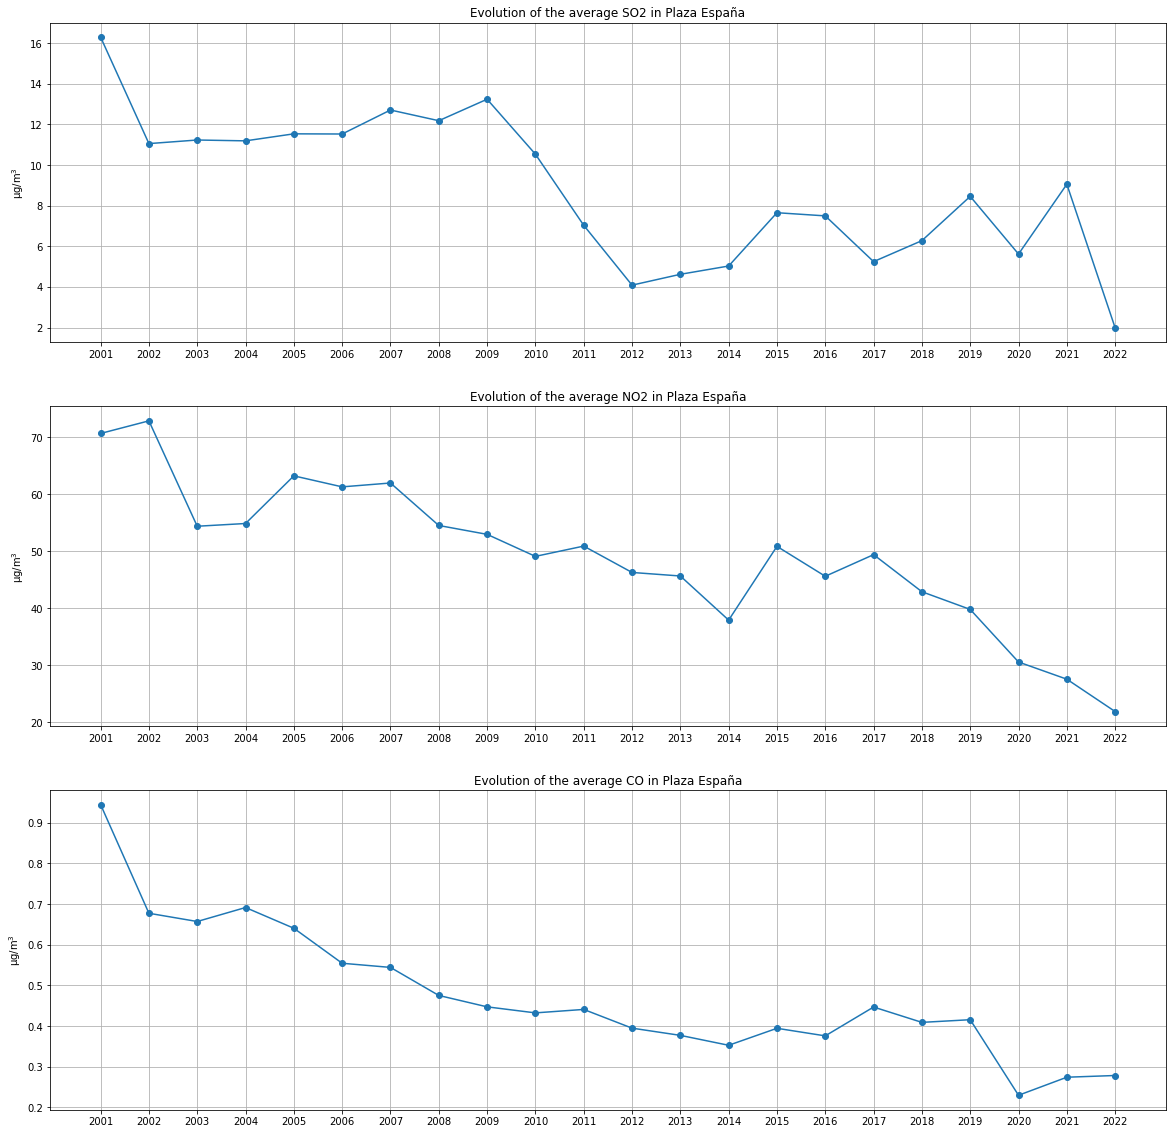

In [118]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(20, 20)
axs = axs.ravel()

for idx, g in enumerate([1, 8, 6]):
    axs[idx].plot([gases[('{:02}'.format(g), y)].mean() for y in range(2001, 2023)], 'o-')
    axs[idx].set_title('Evolution of the average {} in Plaza España'.format(vc_map['{:02}'.format(g)]))
    axs[idx].xaxis.set_major_locator(mticker.FixedLocator(range(0,22)))
    axs[idx].set_xticklabels(range(2001, 2023))
    axs[idx].set_ylabel('μg/m$^3$')
    axs[idx].grid()

plt.savefig('./graphs/madrid_evolution_plEspana.png', bbox_inches='tight')
plt.show()

Escuelas Aguirre:

In [120]:
tic = time.time()
gases = {('{:02}'.format(g), y): np.array([]) for g in [1, 8, 6] for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for g in [1, 8, 6]:
        vc = '{:02}'.format(g)
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == g) & (df.ESTACION == 8) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == g) & (df.ESTACION == 8) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            gases[(vc, y)] = np.concatenate((gases[vc, y], aux))
        
for k in list(gases.keys()):
    if len(gases[k]) == 0:
        gases.pop(k)
print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

It took 00:00:54 in total


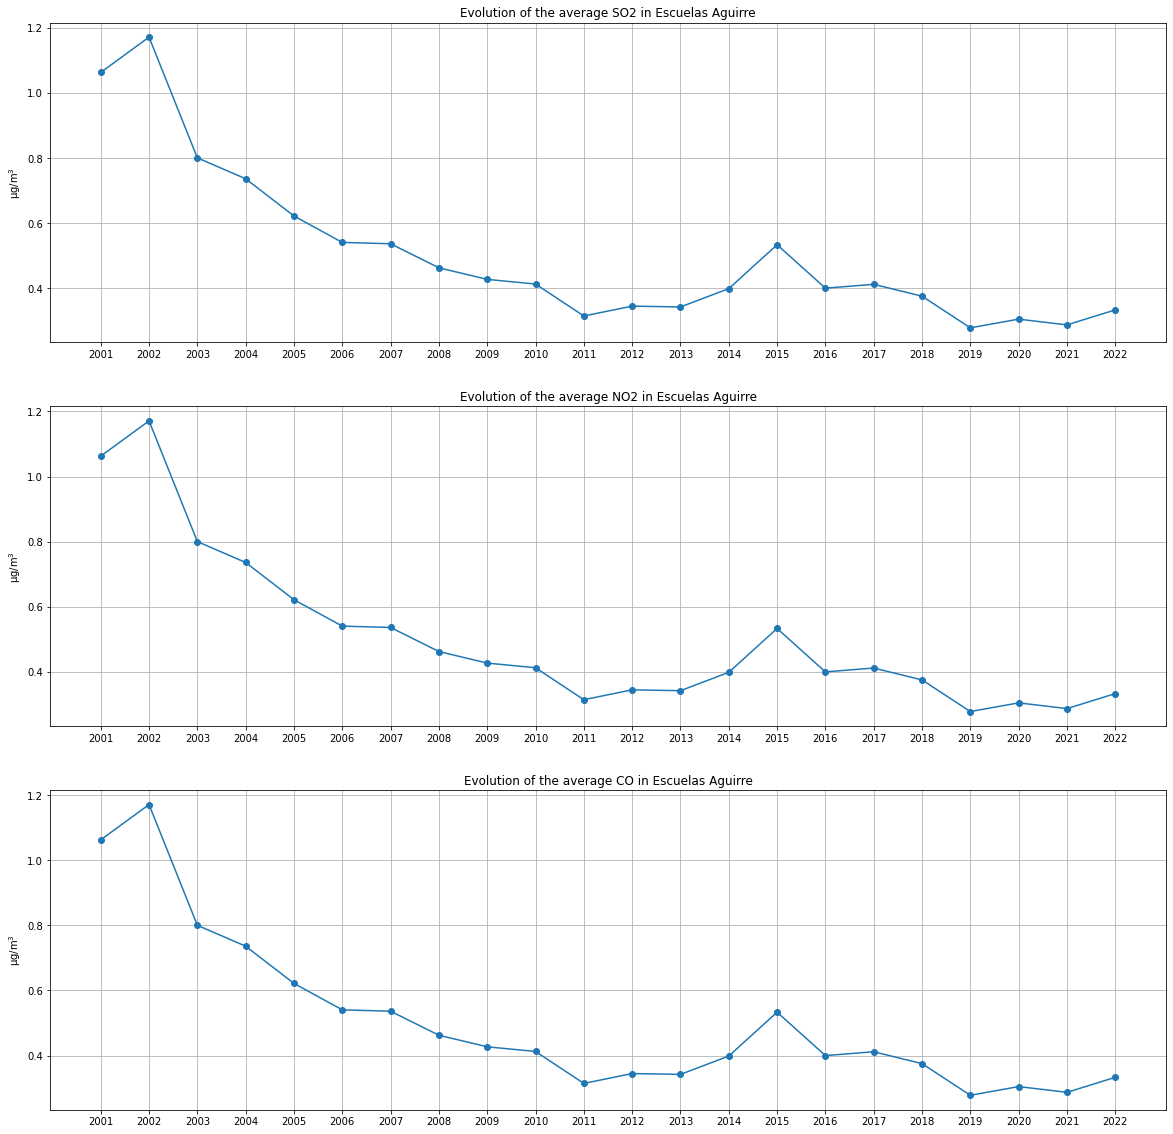

In [121]:
fig, axs = plt.subplots(3, 1)
fig.set_size_inches(20, 20)
axs = axs.ravel()

for idx, g in enumerate([1, 8, 6]):
    axs[idx].plot([gases[(vc, y)].mean() for y in range(2001, 2023)], 'o-')
    axs[idx].set_title('Evolution of the average {} in Escuelas Aguirre'.format(vc_map['{:02}'.format(g)]))
    axs[idx].xaxis.set_major_locator(mticker.FixedLocator(range(0,22)))
    axs[idx].set_xticklabels(range(2001, 2023))
    axs[idx].set_ylabel('μg/m$^3$')
    axs[idx].grid()

plt.savefig('./graphs/madrid_evolution_esAguirre.png', bbox_inches='tight')
plt.show()

It took 00:01:10 in total


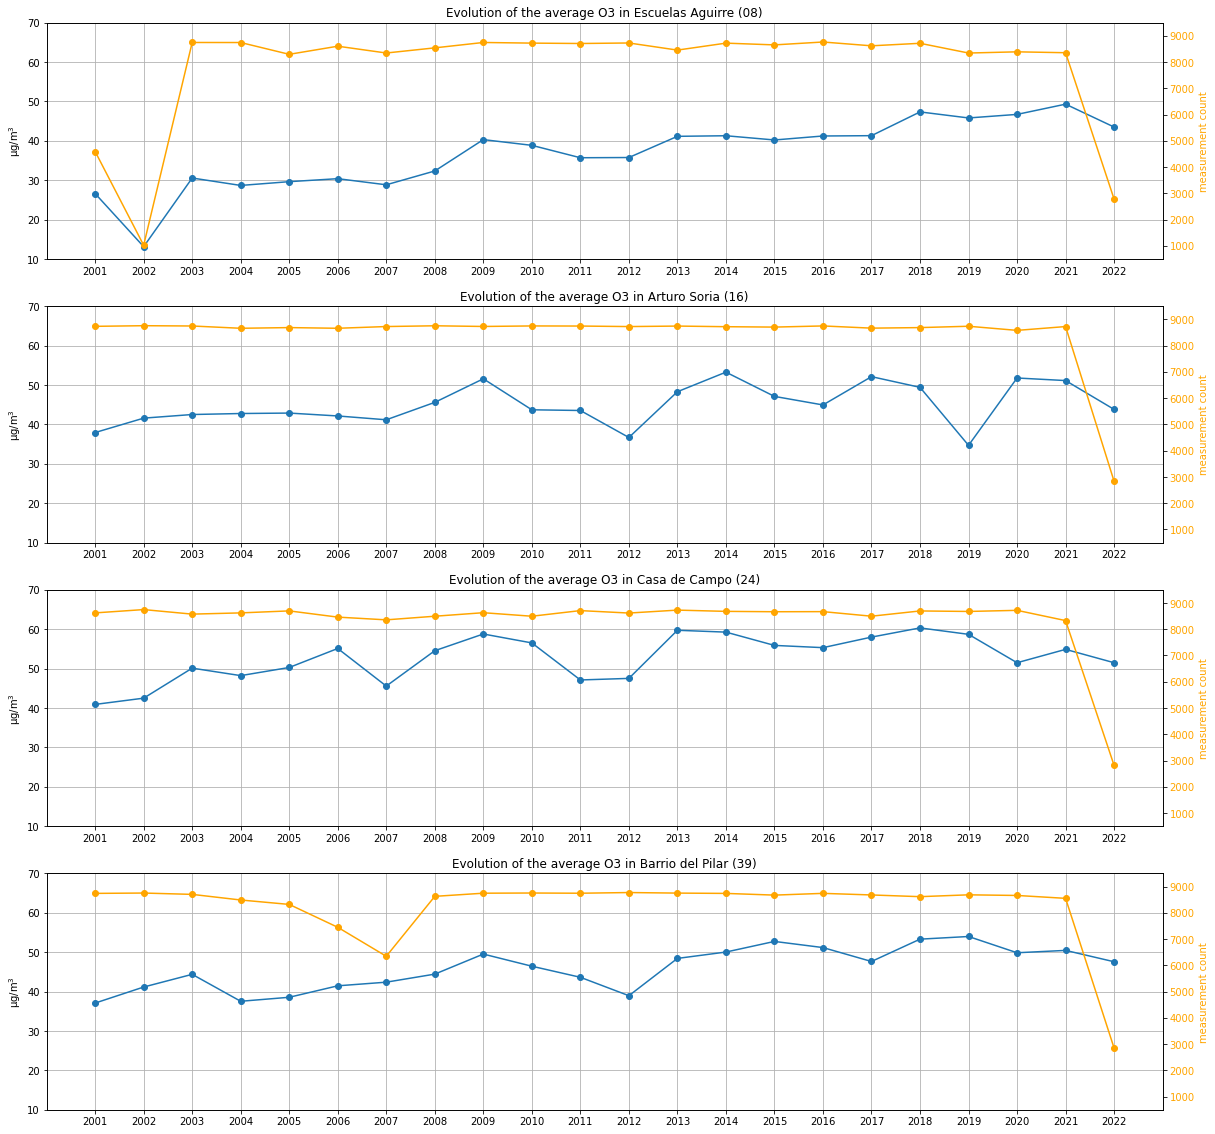

In [132]:
tic = time.time()
tch = {('{:02}'.format(s), y): np.array([]) for s in [8, 16, 24, 39] for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for s in [8, 16, 24, 39]:
        sc = '{:02}'.format(s)
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == 14) & (df.ESTACION == s) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == 14) & (df.ESTACION == s) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            tch[(sc, y)] = np.concatenate((tch[sc, y], aux))

print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(20, 20)
axs = axs.ravel()

for idx, s in enumerate([8, 16, 24, 39]):
    sc = '{:02}'.format(s)
    axs[idx].plot([tch[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
    axs[idx].set_title('Evolution of the average O3 in {} ({})'.format(sc_map[sc], sc))
    axs[idx].xaxis.set_major_locator(mticker.FixedLocator(range(0,22)))
    axs[idx].set_xticklabels(range(2001, 2023))
    axs[idx].set_ylabel('μg/m$^3$')
    axs[idx].set_xlim(-1, 22)
    axs[idx].set_ylim(10, 70)
    axs[idx].grid()
    # Instantiate a second axes that shares the same x-axis
    ax2 = axs[idx].twinx()  
    ax2.set_ylabel('measurement count', color='orange')
    aux = [tch[('{:02}'.format(s), y)].shape[0] for y in range(2001, 2023)]
    ax2.plot([np.nan if i == 0 else i for i in aux], 'o-', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(500, 9500)

plt.savefig('./graphs/madrid_evolution_O3.png', bbox_inches='tight')
plt.show()

Gases that may not be included in the final dataset: TCH, CH4 y NMHC.

It took 00:01:10 in total


<ipython-input-135-c8bfdb13404f>:23: RuntimeWarning: Mean of empty slice.
  axs[idx].plot([tch[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


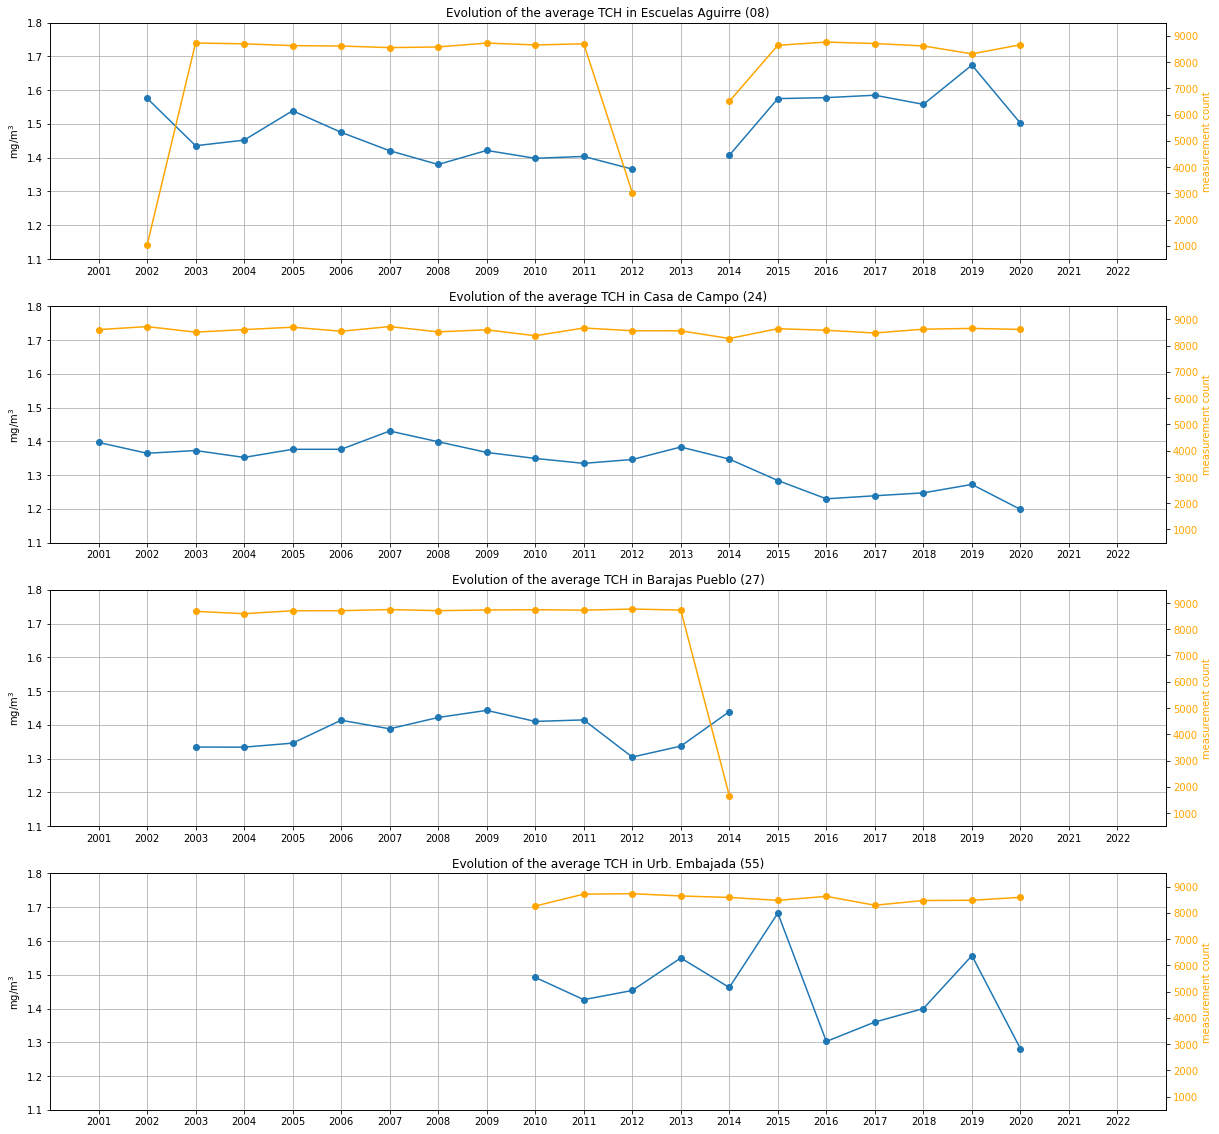

In [135]:
tic = time.time()
tch = {('{:02}'.format(s), y): np.array([]) for s in [8, 24, 27, 55] for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for s in [8, 24, 27, 55]:
        sc = '{:02}'.format(s)
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == 42) & (df.ESTACION == s) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == 42) & (df.ESTACION == s) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            tch[(sc, y)] = np.concatenate((tch[sc, y], aux))

print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(20, 20)
axs = axs.ravel()

for idx, s in enumerate([8, 24, 27, 55]):
    sc = '{:02}'.format(s)
    axs[idx].plot([tch[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
    axs[idx].set_title('Evolution of the average TCH in {} ({})'.format(sc_map[sc], sc))
    axs[idx].xaxis.set_major_locator(mticker.FixedLocator(range(0,22)))
    axs[idx].set_xticklabels(range(2001, 2023))
    axs[idx].set_ylabel('mg/m$^3$')
    axs[idx].set_xlim(-1, 22)
    axs[idx].set_ylim(1.1, 1.8)
    axs[idx].grid()
    # Instantiate a second axes that shares the same x-axis
    ax2 = axs[idx].twinx()  
    ax2.set_ylabel('measurement count', color='orange')
    aux = [tch[(sc, y)].shape[0] for y in range(2001, 2023)]
    ax2.plot([np.nan if i == 0 else i for i in aux], 'o-', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(500, 9500)

plt.savefig('./graphs/madrid_evolution_TCH.png', bbox_inches='tight')
plt.show()

It took 00:01:10 in total


<ipython-input-136-25e4d603feb0>:23: RuntimeWarning: Mean of empty slice.
  axs[idx].plot([ch4[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


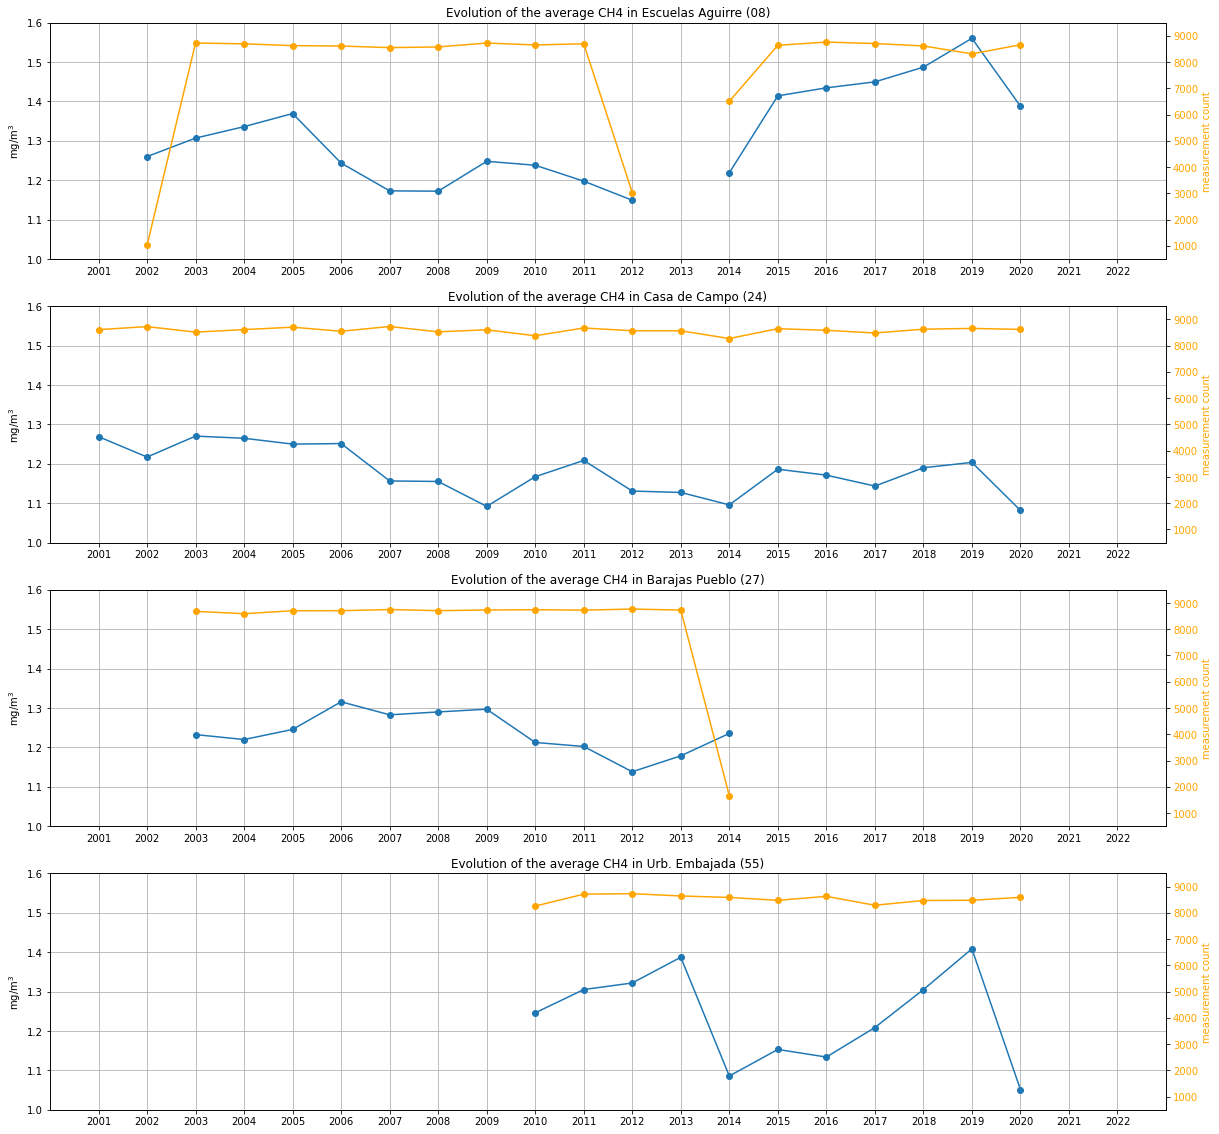

In [136]:
tic = time.time()
ch4 = {('{:02}'.format(s), y): np.array([]) for s in [8, 24, 27, 55] for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for s in [8, 24, 27, 55]:
        sc = '{:02}'.format(s)
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == 43) & (df.ESTACION == s) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == 43) & (df.ESTACION == s) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            ch4[(sc, y)] = np.concatenate((ch4[sc, y], aux))

print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(20, 20)
axs = axs.ravel()

for idx, s in enumerate([8, 24, 27, 55]):
    sc = '{:02}'.format(s)
    axs[idx].plot([ch4[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
    axs[idx].set_title('Evolution of the average CH4 in {} ({})'.format(sc_map[sc], sc))
    axs[idx].xaxis.set_major_locator(mticker.FixedLocator(range(0,22)))
    axs[idx].set_xticklabels(range(2001, 2023))
    axs[idx].set_ylabel('mg/m$^3$')
    axs[idx].set_xlim(-1, 22)
    axs[idx].set_ylim(1, 1.6)
    axs[idx].grid()
    # Instantiate a second axes that shares the same x-axis
    ax2 = axs[idx].twinx()  
    ax2.set_ylabel('measurement count', color='orange')
    aux = [ch4[(sc, y)].shape[0] for y in range(2001, 2023)]
    ax2.plot([np.nan if i == 0 else i for i in aux], 'o-', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(500, 9500)

plt.savefig('./graphs/madrid_evolution_CH4.png', bbox_inches='tight')
plt.show()

It took 00:01:10 in total


<ipython-input-141-08feea49e86e>:23: RuntimeWarning: Mean of empty slice.
  axs[idx].plot([nmhc[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


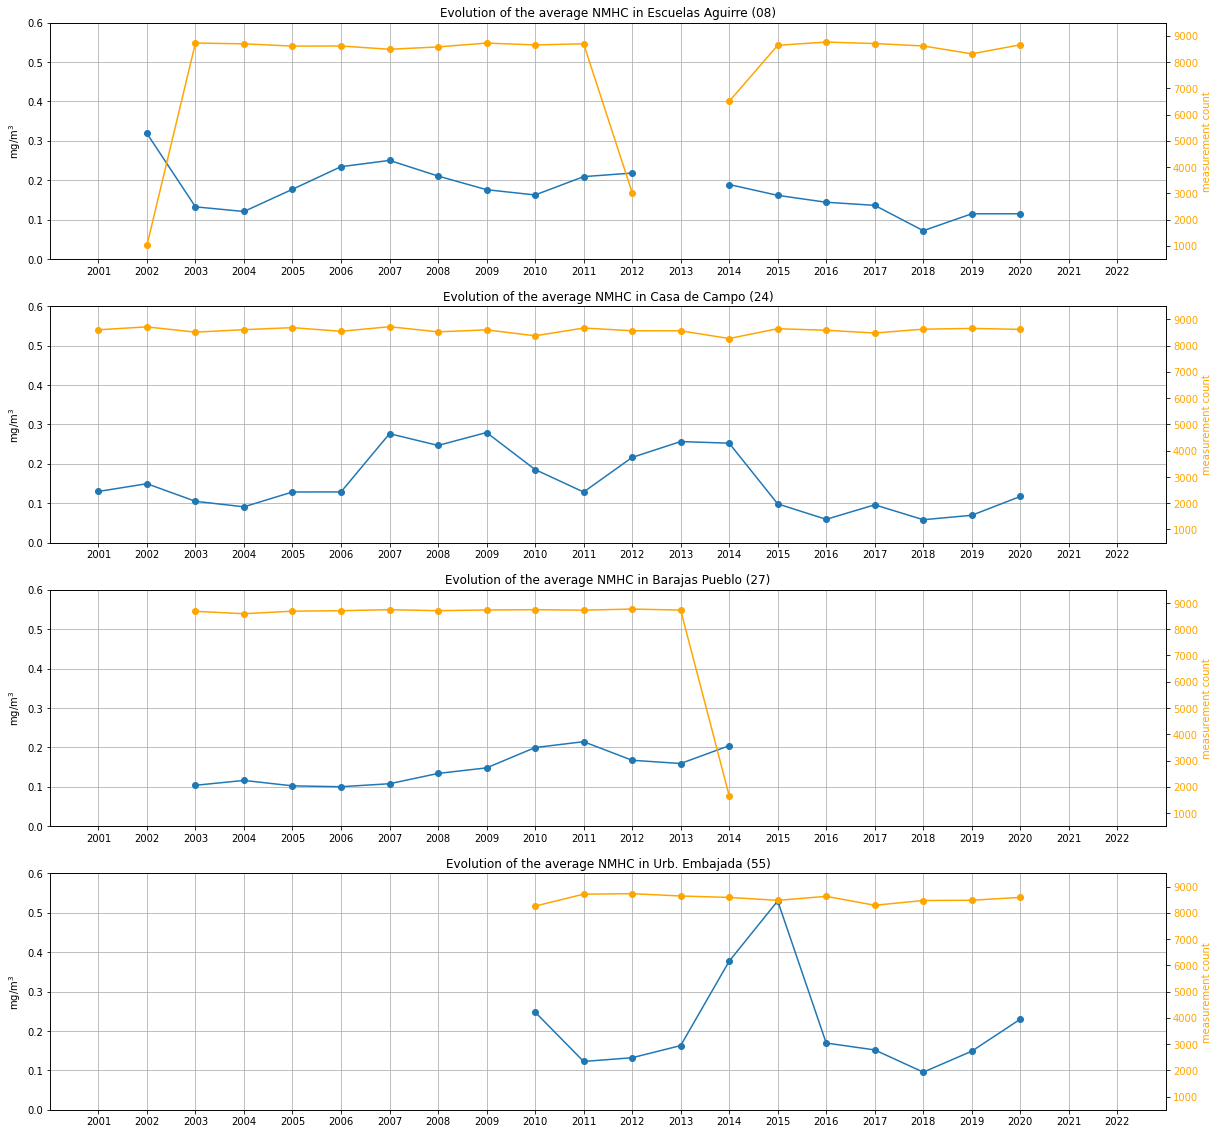

In [141]:
tic = time.time()
nmhc = {('{:02}'.format(s), y): np.array([]) for s in [8, 24, 27, 55] for y in range(2001, 2023)}

for f in df_v.index[:-1]:
    df = pd.read_csv(os.path.join(folder + 'raw/csv', f), sep=';')
    for s in [8, 24, 27, 55]:
        sc = '{:02}'.format(s)
        for y in range(2001, 2023):
            aux = df.loc[(df.MAGNITUD == 44) & (df.ESTACION == s) & (df.ANO == y), 'H01':'H24':2].values.ravel()
            mask = df.loc[(df.MAGNITUD == 44) & (df.ESTACION == s) & (df.ANO == y), 'V01':'V24':2].replace({'N': False, 'V':True}).values.ravel()
            if len(mask) == 0: continue
            aux = aux[mask]
            nmhc[(sc, y)] = np.concatenate((nmhc[sc, y], aux))

print('It took {} in total'.format(time.strftime('%H:%M:%S', time.gmtime(time.time() - tic))))

fig, axs = plt.subplots(4, 1)
fig.set_size_inches(20, 20)
axs = axs.ravel()

for idx, s in enumerate([8, 24, 27, 55]):
    sc = '{:02}'.format(s)
    axs[idx].plot([nmhc[(sc, y)].mean() for y in range(2001, 2023)], 'o-', color='tab:blue')
    axs[idx].set_title('Evolution of the average NMHC in {} ({})'.format(sc_map[sc], sc))
    axs[idx].xaxis.set_major_locator(mticker.FixedLocator(range(0,22)))
    axs[idx].set_xticklabels(range(2001, 2023))
    axs[idx].set_ylabel('mg/m$^3$')
    axs[idx].set_xlim(-1, 22)
    axs[idx].set_ylim(0, 0.6)
    axs[idx].grid()
    # Instantiate a second axes that shares the same x-axis
    ax2 = axs[idx].twinx()  
    ax2.set_ylabel('measurement count', color='orange')
    aux = [nmhc[(sc, y)].shape[0] for y in range(2001, 2023)]
    ax2.plot([np.nan if i == 0 else i for i in aux], 'o-', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(500, 9500)

plt.savefig('./graphs/madrid_evolution_NMHC.png', bbox_inches='tight')
plt.show()

## Spatial and temporal coverage of gases

In [147]:
df_span = pd.DataFrame(index=['{} - {}'.format(k, v) for k, v in sc_map.items()],
                       columns=vn_map.keys())

#a = (calendar.datetime.date(2021, 8, 31) - calendar.datetime.date(2001, 1, 1))
a = (calendar.datetime.date(2022, 4, 30) - calendar.datetime.date(2001, 1, 1))
n_hours = a.days * 24

out_path = '../data/madrid/clean/01h_flat_rawSep.h5'

with tb.open_file(out_path, mode='r') as h5_file:
    for sc in sc_map.keys():
        for vc in vc_map.keys():
            n = '/s{}/v{}'.format(sc, vc)
            if n in h5_file.root:
                r, c = str(sc) + ' - ' + sc_map[sc], vc_map[vc]
                df_span.loc[r, c] = round(h5_file.root[n].shape[0] / n_hours * 100, 1)
df_span.loc['present in', :] = df_span.notna().sum(axis=0)
df_span.loc[:, 'measures'] = df_span.notna().sum(axis=1)
df_span.loc['present in', 'measures'] = 0
df_span

SO2    CO     NO    NO2  PM25  PM10    NOx    O3  \
04 - Pza. de España        96.9  96.9   96.9   96.9   NaN   NaN   96.9   NaN   
08 - Escuelas Aguirre      93.2  93.2   93.2   93.2  58.1  91.5   93.2  93.2   
11 - Avda. Ramón y Cajal    NaN   NaN  100.0  100.0   NaN   NaN  100.0   NaN   
16 - Arturo Soria           NaN  93.8   99.9   99.9   NaN   NaN   99.9  99.9   
17 - Villaverde            73.8   NaN   80.0   80.0   NaN   NaN   80.0  80.0   
18 - Farolillo             94.5  98.8   98.8   98.8   NaN  96.4   98.8  98.8   
24 - Casa de Campo         93.8  93.8   99.6   99.6  87.2  99.6   99.6  99.6   
27 - Barajas Pueblo         NaN   NaN   90.7   90.7   NaN   NaN   90.7  57.8   
35 - Pza. del Carmen       99.5  99.5   99.5   99.5   NaN   NaN   99.5  99.5   
36 - Moratalaz             99.5  93.4   99.6   99.6   NaN  99.6   99.6   NaN   
38 - Cuatro Caminos        93.6   NaN   99.8   99.8  83.2  96.7   99.8   NaN   
39 - Barrio del Pilar       NaN  92.2   98.4   98.4   NaN   NaN   98.4  98.4   
40 - Vallecas              93.7   NaN   99.9   99.9   NaN  99.7   99.9   NaN   
47 - Mendez Alvaro          NaN   NaN   57.8   57.8  57.7  57.7   57.8   NaN   
48 - Castellana             NaN   NaN   55.8   55.8  55.2  55.4   55.8   NaN   
49 - Parque del Retiro      NaN   NaN   57.8   57.8   NaN   NaN   57.8  57.8   
50 - Plaza Castilla         NaN   NaN   56.9   56.9  56.2  56.4   56.9   NaN   
54 - Ensanche de Vallecas   NaN   NaN   58.1   58.1   NaN   NaN   58.1  58.1   
55 - Urb. Embajada          NaN   NaN   57.6   57.6   NaN  57.4   57.6   NaN   
56 - Pza. Elíptica          NaN  57.2   57.4   57.4  12.9  12.9   57.4  53.0   
57 - Sanchinarro           58.1  52.0   58.1   58.1   2.3  58.0   58.1   NaN   
58 - El Pardo               NaN   NaN   58.2   58.2   NaN   NaN   58.2  58.2   
59 - Juan Carlos I          NaN   NaN   57.8   57.8   NaN   NaN   57.8  57.8   
60 - Tres Olivos            NaN   NaN   57.3   57.3   NaN  57.3   57.3  57.3   
present in                   10    10     24     24     8    13     24    14   

                            TOL   BEN   EBE   TCH   CH4  NMHC  measures  
04 - Pza. de España         NaN   NaN   NaN   NaN   NaN   NaN         5  
08 - Escuelas Aguirre      90.7  90.7  90.7  75.8  75.8  75.8        14  
11 - Avda. Ramón y Cajal   58.2  58.2  58.2   NaN   NaN   NaN         6  
16 - Arturo Soria           NaN   NaN   NaN   NaN   NaN   NaN         5  
17 - Villaverde             NaN   NaN   NaN   NaN   NaN   NaN         5  
18 - Farolillo             57.5  57.5  57.5   NaN   NaN   NaN        10  
24 - Casa de Campo         95.1  95.1  92.8  93.6  93.6  93.5        14  
27 - Barajas Pueblo         NaN   NaN   NaN  52.5  52.5  52.5         7  
35 - Pza. del Carmen        NaN   NaN   NaN   NaN   NaN   NaN         6  
36 - Moratalaz              NaN   NaN   NaN   NaN   NaN   NaN         6  
38 - Cuatro Caminos        57.9  57.9  57.9   NaN   NaN   NaN         9  
39 - Barrio del Pilar       NaN   NaN   NaN   NaN   NaN   NaN         5  
40 - Vallecas               NaN   NaN   NaN   NaN   NaN   NaN         5  
47 - Mendez Alvaro          NaN   NaN   NaN   NaN   NaN   NaN         5  
48 - Castellana             NaN   NaN   NaN   NaN   NaN   NaN         5  
49 - Parque del Retiro      NaN   NaN   NaN   NaN   NaN   NaN         4  
50 - Plaza Castilla         NaN   NaN   NaN   NaN   NaN   NaN         5  
54 - Ensanche de Vallecas   NaN   NaN   NaN   NaN   NaN   NaN         4  
55 - Urb. Embajada         55.3  55.3  55.3  51.3  51.3  51.3        10  
56 - Pza. Elíptica          NaN   NaN   NaN   NaN   NaN   NaN         7  
57 - Sanchinarro            NaN   NaN   NaN   NaN   NaN   NaN         7  
58 - El Pardo               NaN   NaN   NaN   NaN   NaN   NaN         4  
59 - Juan Carlos I          NaN   NaN   NaN   NaN   NaN   NaN         4  
60 - Tres Olivos            NaN   NaN   NaN   NaN   NaN   NaN         5  
present in                    6     6     6     4     4     4         0

In [150]:
df_dates = pd.DataFrame(index=vn_map.keys(), columns=['min date in', 'min date', 'max date', 'max date in'])
df_dates.loc[:, 'min date'] = 1e10
df_dates.loc[:, 'max date'] = 1e1

out_path = '../data/madrid/clean/01h_flat_rawSep.h5'

with tb.open_file(out_path, mode='r') as h5_file:
    for sc in sc_map.keys():
        for vc in vc_map.keys():
            n = '/s{}/v{}'.format(sc, vc)
            if n in h5_file.root:
                r, c = str(sc) + ' - ' + sc_map[sc], vc_map[vc]
                m = h5_file.root[n][:, 0].min()
                if m < df_dates.loc[vc_map[vc], 'min date']:
                    df_dates.loc[vc_map[vc], 'min date'] = m
                    df_dates.loc[vc_map[vc], 'min date in'] = '{} - {}'.format(sc, sc_map[sc])
                m = h5_file.root[n][:, 0].max()
                if m > df_dates.loc[vc_map[vc], 'max date']:
                    df_dates.loc[vc_map[vc], 'max date'] = m
                    df_dates.loc[vc_map[vc], 'max date in'] = '{} - {}'.format(sc, sc_map[sc])
df_dates['min date'] = df_dates['min date'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(x)))
df_dates['max date'] = df_dates['max date'].apply(lambda x: time.strftime('%Y-%m-%d', time.localtime(x)))
df_dates

min date in    min date    max date            max date in
SO2     04 - Pza. de España  2001-01-01  2022-05-01    04 - Pza. de España
CO      04 - Pza. de España  2001-01-01  2022-05-01    04 - Pza. de España
NO      04 - Pza. de España  2001-01-01  2022-05-01    04 - Pza. de España
NO2     04 - Pza. de España  2001-01-01  2022-05-01    04 - Pza. de España
PM25     24 - Casa de Campo  2003-01-01  2022-05-01  08 - Escuelas Aguirre
PM10  08 - Escuelas Aguirre  2001-01-01  2022-05-01  08 - Escuelas Aguirre
NOx     04 - Pza. de España  2001-01-01  2022-05-01    04 - Pza. de España
O3    08 - Escuelas Aguirre  2001-01-01  2022-05-01  08 - Escuelas Aguirre
TOL   08 - Escuelas Aguirre  2001-01-01  2022-05-01  08 - Escuelas Aguirre
BEN   08 - Escuelas Aguirre  2001-01-01  2022-05-01  08 - Escuelas Aguirre
EBE   08 - Escuelas Aguirre  2001-01-01  2022-05-01  08 - Escuelas Aguirre
TCH      24 - Casa de Campo  2001-01-01  2021-01-05  08 - Escuelas Aguirre
CH4      24 - Casa de Campo  2001-01-01  2021-01-05  08 - Escuelas Aguirre
NMHC     24 - Casa de Campo  2001-01-01  2021-01-05  08 - Escuelas Aguirre

- PM2.5 was not measured until 2003.
- TCH, CH4 and NMHC stopped being measured in 2020.
- CO stopped being measured in Arturo Soria (E16), Casa de Campo (E24), Moratalaz (E36), Barrio del Pilar (E39) y Sanchinarro (E57) in 2020.
- SO2 stopped being measured in Villaverde (E17), Casa Campo (E24), Cuatro Caminos (E38) y Vallecas (E40)  in 2020.

Taking NaNs into account:

SO2:	no measurements on 34 hours (0.0182%), 13 hours from 2010 on
CO:	no measurements on 34 hours (0.0182%), 13 hours from 2010 on
NO:	no measurements on 34 hours (0.0182%), 13 hours from 2010 on
NO2:	no measurements on 34 hours (0.0182%), 13 hours from 2010 on
PM25:	no measurements on 19119 hours (10.2%), 13 hours from 2010 on
PM10:	no measurements on 66 hours (0.0353%), 15 hours from 2010 on
NOx:	no measurements on 34 hours (0.0182%), 13 hours from 2010 on
O3:	no measurements on 34 hours (0.0182%), 13 hours from 2010 on
TOL:	no measurements on 1339 hours (0.716%), 13 hours from 2010 on
BEN:	no measurements on 1316 hours (0.704%), 13 hours from 2010 on
EBE:	no measurements on 1432 hours (0.766%), 13 hours from 2010 on
TCH:	no measurements on 11837 hours (6.33%), 11632 hours from 2010 on
CH4:	no measurements on 11837 hours (6.33%), 11632 hours from 2010 on
NMHC:	no measurements on 11871 hours (6.35%), 11632 hours from 2010 on


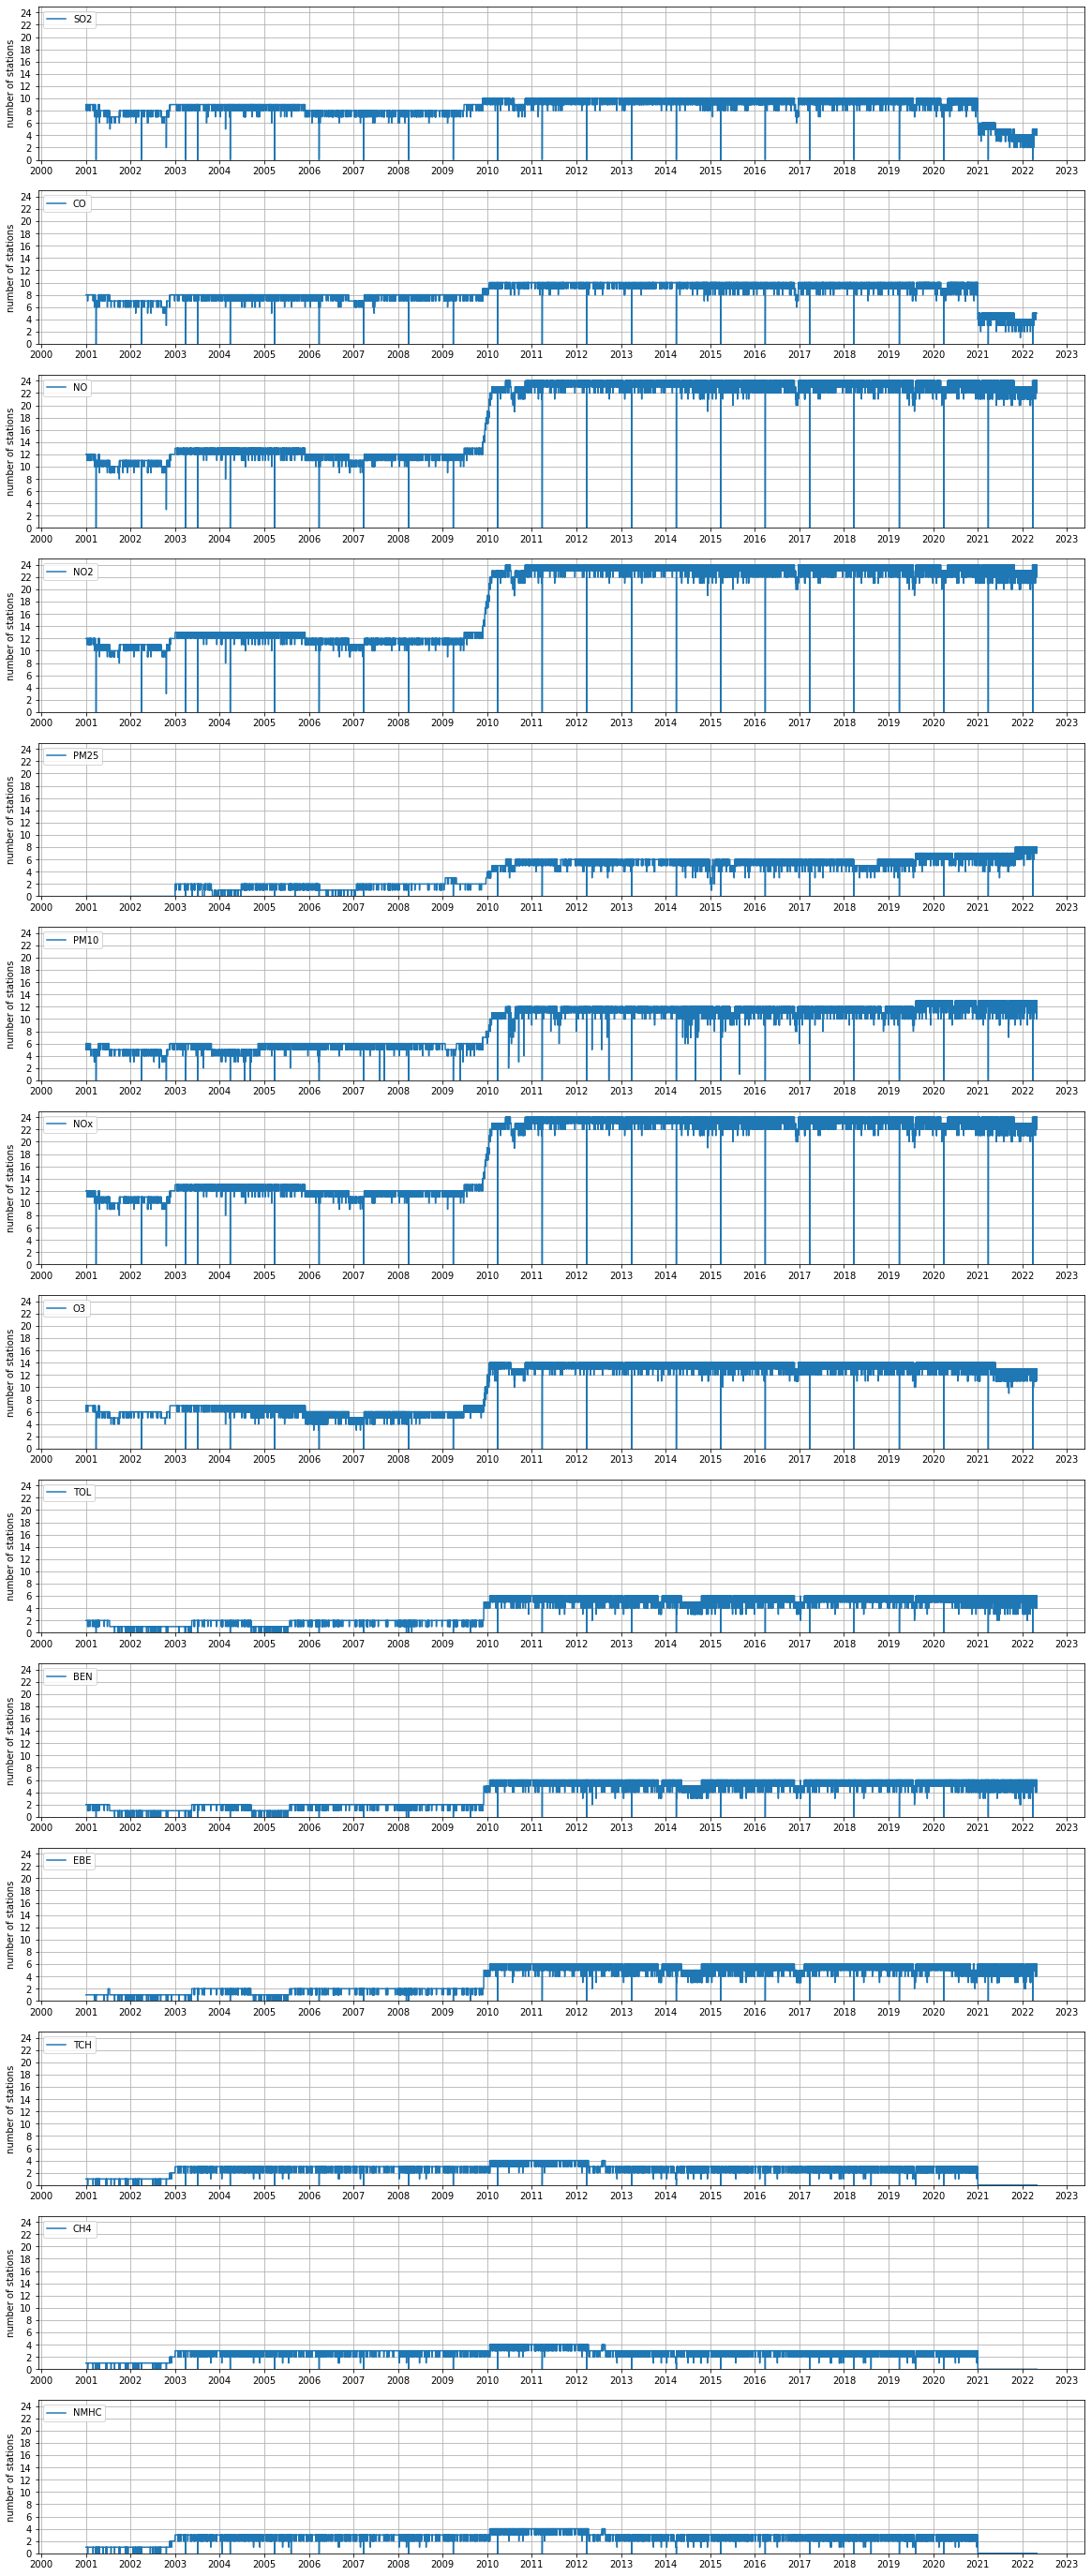

In [152]:
out_path = '../data/madrid/clean/01h_flat_rawSep.h5'

dates = pd.date_range('1-1-2001', '30/04/2022', freq='1h')

fig, axs = plt.subplots(14, 1)
fig.set_size_inches(20, 50)
axs = axs.ravel()

with tb.open_file(out_path, mode='r') as h5_file:
    for idx, vc in enumerate(vc_map.keys()):
        df_g = pd.DataFrame(index=pd.date_range('1-1-2001', '30/04/2022', freq='1h').astype('int64') // 1e9)
        for sc in sc_map.keys():
            n = '/s{}/v{}'.format(sc, vc)
            if n in h5_file.root:
                aux = h5_file.root[n][:]
                aux[~np.isnan(aux[:, 1]), 1] = 1 # dummy value to be summed
                aux = pd.DataFrame(data=aux[:, 1], index=aux[:, 0].astype(int), columns=[sc])
                df_g = pd.merge(df_g, aux, left_index=True, right_index=True, how='left')
        axs[idx].plot(dates, df_g.sum(axis=1), label=vc_map[vc])
        axs[idx].legend(loc='upper left')
        axs[idx].xaxis.set_major_locator(mdates.YearLocator(1))
        axs[idx].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        axs[idx].yaxis.set_major_locator(mticker.FixedLocator(range(0, 26, 2)))
        #axs[idx].set_title(c_map[g])
        axs[idx].set_ylabel('number of stations')
        axs[idx].grid()
        axs[idx].set_ylim(0, 25)
        n_zeros = (df_g.sum(axis=1) == 0).sum()
        n_late_zeros = (df_g.loc[1269720000:].sum(axis=1) == 0).sum() # from 2010 until the end
        print('{}:\tno measurements on {} hours ({:0.3}%), {} hours from 2010 on'.format(
            vc_map[vc], n_zeros, n_zeros / n_hours * 100, n_late_zeros))
plt.savefig('./graphs/madrid_gases_coverage_excluding_nans.pdf', bbox_inches='tight')
plt.show()

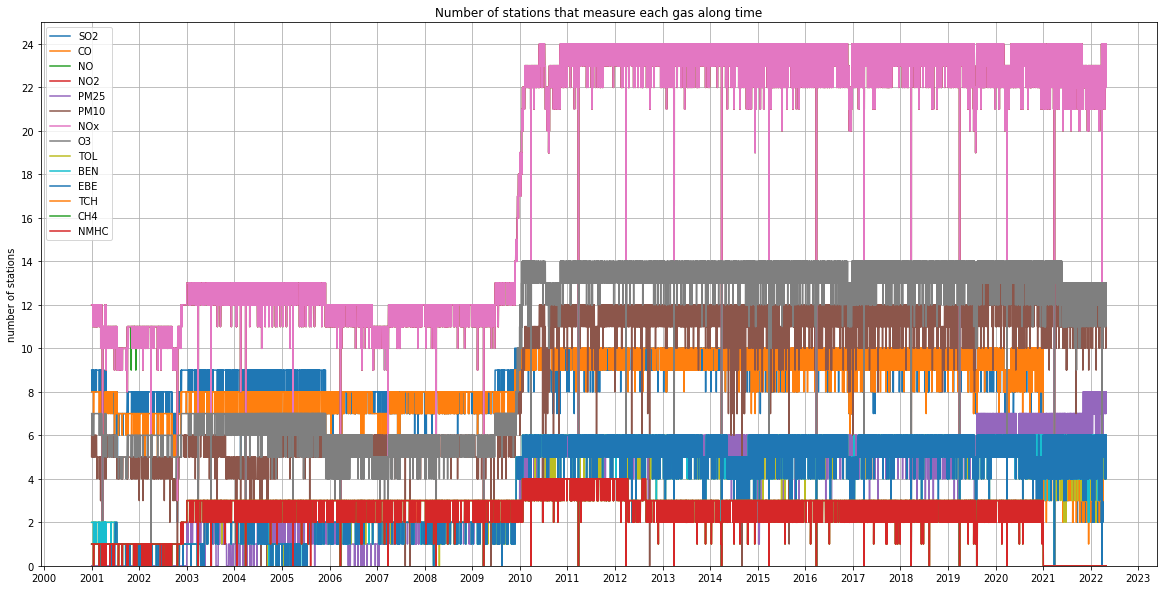

In [155]:
out_path = '../data/madrid/clean/01h_flat_rawSep.h5'

dates = pd.date_range('1-1-2001', '30/04/2022', freq='1h')

fig, ax = plt.subplots()
fig.set_size_inches(20, 10)

with tb.open_file(out_path, mode='r') as h5_file:#, tb.open_file(old, mode='r') as h5_file1:
    for idx, vc in enumerate(vc_map.keys()):
        df_g = pd.DataFrame(index=pd.date_range('1-1-2001', '30/04/2022', freq='1h').astype('int64') // 1e9)
        for sc in sc_map.keys():
            n = '/s{}/v{}'.format(sc, vc)
            if n in h5_file.root:
                aux = h5_file.root[n][:]
                #aux[:, 1] = 1 # dummy value to be summed
                aux[~np.isnan(aux[:, 1]), 1] = 1
                aux = pd.DataFrame(data=aux[:, 1], index=aux[:, 0].astype(int), columns=[sc])
                df_g = pd.merge(df_g, aux, left_index=True, right_index=True, how='left')
        ax.plot(dates, df_g.sum(axis=1), label=vc_map[vc])
ax.legend(loc='upper left')
ax.xaxis.set_major_locator(mdates.YearLocator(1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.yaxis.set_major_locator(mticker.FixedLocator(range(0, 25, 2)))
ax.set_title('Number of stations that measure each gas along time')
ax.set_ylabel('number of stations')
ax.grid()
ax.set_ylim(0, 25)
plt.savefig('./graphs/madrid_gases_coverage_combined_excluding_nans.pdf', bbox_inches='tight')
plt.show()

## Animate grids

In [193]:
def update(frame, ax, arr, I, J, vc, sca, cols, times, vmin, vmax, norm, units, step):
    #if (frame % 100) == 0:
    #    print('Frame:', frame)
    ax.clear()
    ax.set_xlabel(xlabel='Longitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_ylabel(ylabel='Latitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_zlabel(zlabel='{} [{}]'.format(vc_map[vc], units), fontsize=15, labelpad=12)
    ax.set_zlim3d([vmin, vmax])
    # Note: For some reason, I only managed to make the title visible setting y=1 here:
    ax.set_title('{}'.format(times[frame]), fontsize=15, y=1)
    ax.plot_surface(J, I, arr[frame*step], cmap='viridis', alpha=0.6, norm=norm)
    if sca is not None:
        ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], sca[frame, 1:], s=20, c='r')
    return _

def animate(date, n_days, id_v, scaling, method, jacobi, step=1):
    vc = list(vc_map.keys())[id_v]
    path = '../data/madrid/clean/01h_35x30_{}_{}_J{:0.2}.h5'.format(scaling, method, jacobi)
    # Load grid data and prepare time labels
    idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
    times = pd.date_range(date, periods=n_days * 24, freq='1h')
    times = times.format(date_format='%d/%m/%Y %H:%M')
    with tb.open_file(path, mode='r') as h5:
        arr = h5.root.gases[idx:idx+n_days*24][:, :,:, id_v]
        I, J = h5.root._v_attrs['IJ']
    
    # Load flat data
    path_f = '../data/madrid/clean/01h_flat_raw.h5'
    with tb.open_file(path_f, mode='r') as h5:
        sca = h5.root['v{}'.format(vc)][idx:idx+n_days*24]
        cols = h5.root['v{}'.format(vc)]._v_attrs['columns']

    # For the y-axis
    units = 'μg/m³' if g in gases_in_mug else 'mg/m³'
    vmin, vmax = arr.min(), arr.max()

    # Animate!
    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(10, 8)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    anim = animation.FuncAnimation(fig, update, frames=arr.shape[0]//step,
                                   repeat=True, fargs=(ax, arr, I, J, vc, sca, cols,
                                                       times, vmin, vmax, norm, units, step))
    anim.save('./animations/{}_{}_{}_{}.mp4'.format(scaling, method, vc_map[vc],
                                                    ''.join(date.split('/')[::-1])))
    plt.close(fig)

In [197]:
# Starting date
date = '15/03/2010'
# Number of days that the animation lasts
n_days = 7
# Variable index
id_v = 5

scaling = 'raw'
method = 'linear'
jacobi = 0.

animate(date, n_days, id_v, scaling, method, jacobi)

## Jacobi tests

In [1363]:
def read_arr(n, g, dset='30x35_raw', ret_cols=False):
    in_path = '../data/madrid/clean/01h_{}_{}.h5'.format(dset, n)
    with tb.open_file(in_path, mode='r') as h5:
        n = '/g{:02}'.format(g)
        if n in h5.root and ret_cols:
            return h5.root[n][:], h5.root[n]._v_attrs['columns']
        elif n in h5.root:
            return h5.root[n][:]

def jacobi(arr, blacklist=[], eps=0.01, show=True):
    M, N = arr.shape
    w = arr.copy()
    eps, diff = eps, eps
    ite, ite_print = 0, 1
    tic = time.time()
    while eps <= diff:
        # Save the old solution in u
        u = w.copy()
        diff = 0.0
        for i in range(1, M - 1):
            for j in range(1, N - 1):
                if (j, i) not in blacklist:
                    w[i, j] = (u[i-1, j] + u[i+1, j] + u[i, j-1] + u[i, j+1] ) * 0.25
                aux = abs(w[i, j] - u[i, j])
                if diff < aux:
                    diff = aux
        ite += 1
        if ite == ite_print and show:
            print(ite, '\t', diff)
            ite_print = 2 * ite_print
    
    if show:
        print('\nIt took {:0.05}s in total (n_ite = {})'.format(time.time() - tic, ite))
        plt.imshow(w, origin='lower')
        plt.show()
    return w

In [1242]:
xid = np.argmin(np.abs(np.array([xi - xnew for xi in df_locs.lng])), axis=1)
yid = np.argmin(np.abs(np.array([yi - ynew for yi in df_locs.lat])), axis=1)
blacklist = list(zip(xid, yid))

**Nota**: Si un dato originalmente es NaN, debería quitarse de la blacklist, no?

### From nearest neighbors

(35, 30)


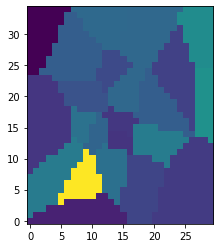

In [1417]:
date = '15/03/2010'
instant = 2 * 24 + 20
n = 'nn'
g = 8

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
arr = read_arr(n=n, g=g)[:][idx + instant]
print(arr.shape)
plt.imshow(arr, origin='lower')
plt.show()

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
sca = sca[idx + instant, 1:]

1 	 140.25
2 	 49.0
4 	 28.375

It took 0.040603s in total (n_ite = 4)


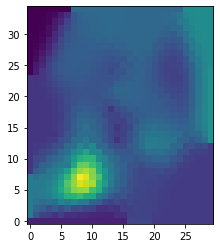

In [1418]:
w = jacobi(arr, blacklist, eps=arr.max() / 10)

1 	 140.25
2 	 49.0
4 	 28.375

It took 0.039227s in total (n_ite = 4)


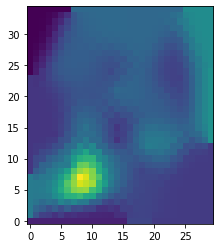

In [1419]:
bl = [blacklist[i] for i in range(len(blacklist)) if i not in np.argwhere(np.isnan(sca))[0]]

w1 = jacobi(arr, bl, eps=arr.max() / 10)

110.26171875 - 92.0 = 18.26171875


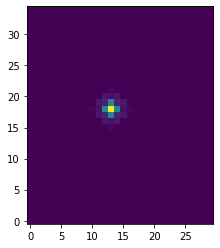

In [1420]:
plt.imshow(w1 - w, origin='lower')
print('{} - {} = {}'.format(w1[18, 13], w[18, 13], (w1 - w).max()))

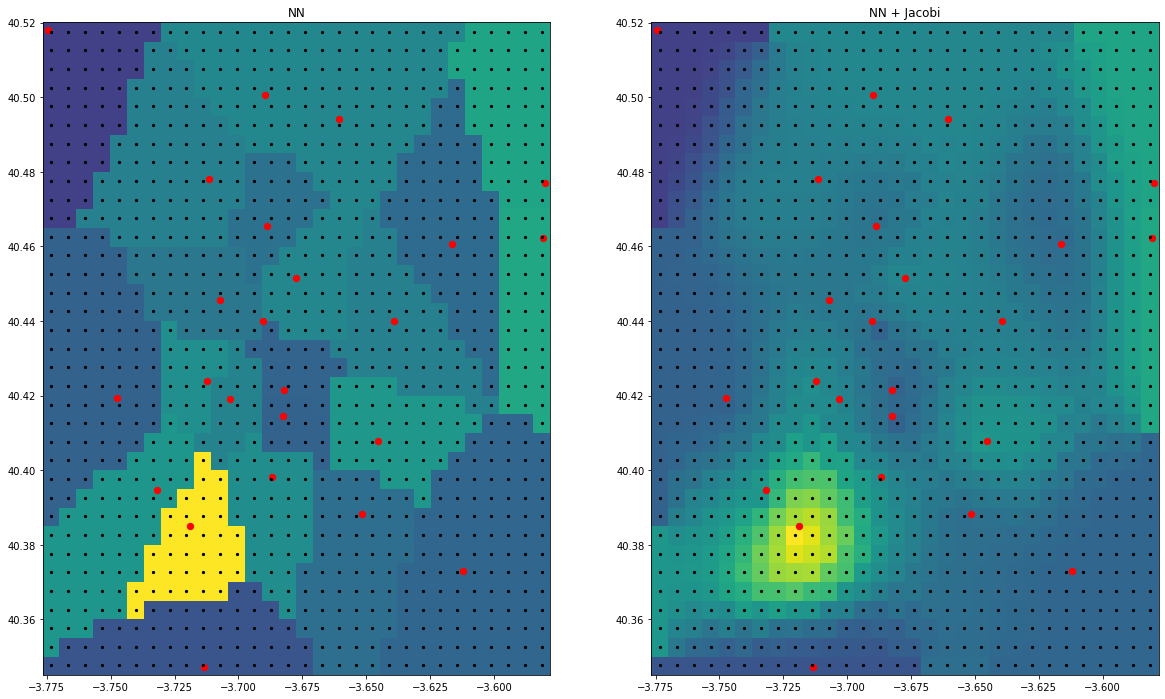

In [1421]:
from scipy.spatial import ConvexHull
hull = ConvexHull(df_locs)

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(20, 12)

axs[0].pcolor(X, Y, arr.T, vmin=0, vmax=288, shading='nearest')
axs[0].scatter(df_locs.loc[:, 'lng'], df_locs.loc[:, 'lat'], s=40, c='r')
axs[0].scatter(X, Y, c='k', s=5)
axs[0].set_title('NN')

#for simplex in hull.simplices:
#    axs[0].plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')

axs[1].pcolor(X, Y, w.T, vmin=0, vmax=288, shading='nearest')
axs[1].scatter(df_locs.loc[:, 'lng'], df_locs.loc[:, 'lat'], s=40, c='r')
axs[1].scatter(X, Y, c='k', s=5)
axs[1].set_title('NN + Jacobi')
#for simplex in hull.simplices:
#    axs[1].plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')

plt.show()

In [1284]:
aux = interp_grid(w.T.ravel(), np.vstack([X.ravel(), Y.ravel()]).T,
            df_locs.loc[:, 'lng'].values, df_locs.loc[:, 'lat'].values,
            method='nearest')#.transpose((1, 0))
print('MAE: {:0.3}'.format(np.nanmean(np.abs((aux - sca)))))

indexed = w[yid, xid]
indexed1 = w1[yid, xid]

pd.DataFrame(np.vstack([sca, aux, sca - aux, indexed, indexed1]),
             index=['real', 'de-interp', 'difference', 'indexed', 'indexed1'],
             columns=df_locs.index.values).round()

MAE: 0.0


4     8      11     16    17     18    24     27     35     36  \
real        142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   
de-interp   142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   
difference    0.0   0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0    0.0   
indexed     142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   
indexed1    142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   

               38     39     40     47     48    49     50    54     55  \
real        114.0  124.0  103.0  140.0    NaN  89.0  107.0  95.0  172.0   
de-interp   114.0  124.0  103.0  140.0   92.0  89.0  107.0  95.0  172.0   
difference    0.0    0.0    0.0    0.0    NaN   0.0    0.0   0.0    0.0   
indexed     114.0  124.0  103.0  140.0   92.0  89.0  107.0  95.0  172.0   
indexed1    114.0  124.0  103.0  140.0  110.0  89.0  107.0  95.0  172.0   

               56     57    58    59     60  
real        288.0  133.0  54.0  99.0  134.0  
de-interp   288.0  133.0  54.0  99.0  134.0  
difference    0.0    0.0   0.0   0.0    0.0  
indexed     288.0  133.0  54.0  99.0  134.0  
indexed1    288.0  133.0  54.0  99.0  134.0

---

(35, 30)


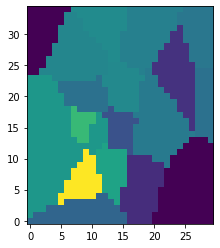

In [1332]:
date = '15/03/2010'
instant = 5 * 24 + 2
n = 'nn'
g = 8

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
arr = read_arr(n=n, g=g)[:][idx + instant]
print(arr.shape)
plt.imshow(arr, origin='lower')
plt.show()

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
sca = sca[idx + instant, 1:]

1 	 37.75
2 	 12.6875
4 	 7.1914062
8 	 4.0269012
16 	 2.0374794
32 	 0.9492531
64 	 0.36367798
128 	 0.074020386

It took 1.8465s in total (n_ite = 215)


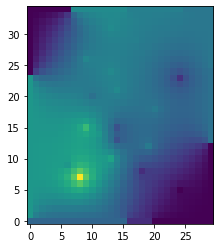

In [1337]:
bl = [blacklist[i] for i in range(len(blacklist)) if i not in np.argwhere(np.isnan(sca))[0]]

w1 = jacobi(arr, bl, eps=arr.max() / 10)

### From mean value

In [1348]:
date = '15/03/2010'
instant = 2 * 24 + 20
g = 8

idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
sca = sca[idx + instant, 1:]
sca_aux = sca.copy()
m = np.nanmean(sca)
sca_aux[np.isnan(sca)] = m

(35, 30)


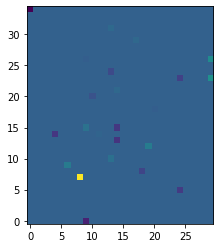

In [1349]:
arr = np.empty((35, 30))
arr[:, :] = m
arr[yid, xid] = sca_aux
print(arr.shape)
plt.imshow(arr, origin='lower')
plt.show()

1 	 40.36956521739131
2 	 23.244565217391283

It took 0.019754s in total (n_ite = 2)


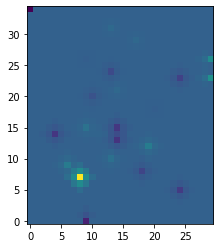

In [1354]:
bl = [blacklist[i] for i in range(len(blacklist)) if i not in np.argwhere(np.isnan(sca))[0]]

w2 = jacobi(arr, bl, eps=arr.max() / 10)

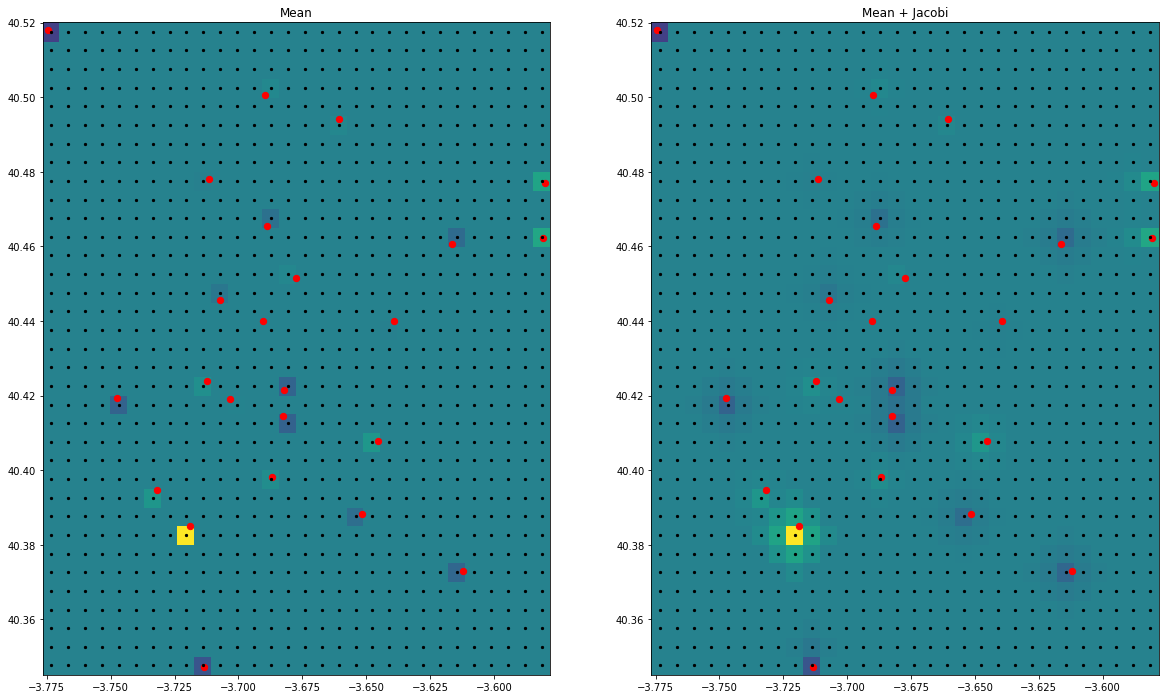

In [1355]:
from scipy.spatial import ConvexHull
hull = ConvexHull(df_locs)

fig, axs = plt.subplots(1, 2)
axs = axs.ravel()
fig.set_size_inches(20, 12)

axs[0].pcolor(X, Y, arr.T, vmin=0, vmax=288, shading='nearest')
axs[0].scatter(df_locs.loc[:, 'lng'], df_locs.loc[:, 'lat'], s=40, c='r')
axs[0].scatter(X, Y, c='k', s=5)
axs[0].set_title('Mean')

#for simplex in hull.simplices:
#    axs[0].plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')

axs[1].pcolor(X, Y, w2.T, vmin=0, vmax=288, shading='nearest')
axs[1].scatter(df_locs.loc[:, 'lng'], df_locs.loc[:, 'lat'], s=40, c='r')
axs[1].scatter(X, Y, c='k', s=5)
axs[1].set_title('Mean + Jacobi')
#for simplex in hull.simplices:
#    axs[1].plot(df_locs.iloc[simplex, 0], df_locs.iloc[simplex, 1], 'r-')

plt.show()

In [1327]:
aux = interp_grid(w2.T.ravel(), np.vstack([X.ravel(), Y.ravel()]).T,
            df_locs.loc[:, 'lng'].values, df_locs.loc[:, 'lat'].values,
            method='nearest')#.transpose((1, 0))
print('MAE: {:0.3}'.format(np.nanmean(np.abs((aux - sca)))))

indexed = w2[yid, xid]

pd.DataFrame(np.vstack([sca, aux, sca - aux, indexed]),
             index=['real', 'de-interp', 'difference', 'indexed'],
             columns=df_locs.index.values).round()

MAE: 0.0


4     8      11     16    17     18    24     27     35     36  \
real        142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   
de-interp   142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   
difference    0.0   0.0    0.0    0.0   0.0    0.0   0.0    0.0    0.0    0.0   
indexed     142.0  92.0  133.0  124.0  76.0  151.0  91.0  168.0  129.0  152.0   

               38     39     40     47     48    49     50    54     55  \
real        114.0  124.0  103.0  140.0    NaN  89.0  107.0  95.0  172.0   
de-interp   114.0  124.0  103.0  140.0  118.0  89.0  107.0  95.0  172.0   
difference    0.0    0.0    0.0    0.0    NaN   0.0    0.0   0.0    0.0   
indexed     114.0  124.0  103.0  140.0  118.0  89.0  107.0  95.0  172.0   

               56     57    58    59     60  
real        288.0  133.0  54.0  99.0  134.0  
de-interp   288.0  133.0  54.0  99.0  134.0  
difference    0.0    0.0   0.0   0.0    0.0  
indexed     288.0  133.0  54.0  99.0  134.0

### From NN in 3D

In [1461]:
%matplotlib notebook

In [1469]:
%matplotlib inline

In [1484]:
def plot3d(date, n_days, g, n, frame):
    idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2010'], dayfirst=True)).days.values[0] * 24
    times = pd.date_range(date, periods=n_days * 24, freq='1h')
    times = times.format(date_format='%d/%m/%Y %H:%M')
    arr = read_arr(n=n, g=g)[idx + frame]

    idx = (pd.DatetimeIndex([date], dayfirst=True) - pd.DatetimeIndex(['1/1/2001'], dayfirst=True)).days.values[0] * 24
    sca, cols = read_arr(dset='flat', n='rawComb', g=g, ret_cols=True)
    sca = sca[idx + frame]

    # Jacobi
    bl = [blacklist[i] for i in range(len(blacklist)) if i not in np.argwhere(np.isnan(sca))[0]]
    arr = jacobi(arr, bl, eps=arr.min(), show=False) # arr.max() / 10


    units = 'μg/m³' if g in gases_in_mug else 'mg/m³'
    vmin, vmax = arr.min(), arr.max()

    fig = plt.figure()
    ax = p3.Axes3D(fig)
    fig.set_size_inches(10, 8)
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    ax.set_xlabel(xlabel='Longitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_ylabel(ylabel='Latitude [$\degree$]', fontsize=15, labelpad=12)
    ax.set_zlabel(zlabel='{} [{}]'.format(gc_map[g], units), fontsize=15, labelpad=12)
    ax.set_zlim3d([vmin, vmax])
    ax.set_title('{}'.format(times[frame]), fontsize=15)
    ax.plot_surface(X, Y, arr.T, cmap='viridis', alpha=0.6, norm=norm)
    ax.scatter(df_locs.loc[cols[1:], 'lng'], df_locs.loc[cols[1:], 'lat'], sca[1:], s=20, c='r')
    plt.show()

In [1446]:
date = '15/03/2010'
instant = 2 * 24 + 20
g = 8
n_days = 7
n = 'nn'

Very big epsilon (54):

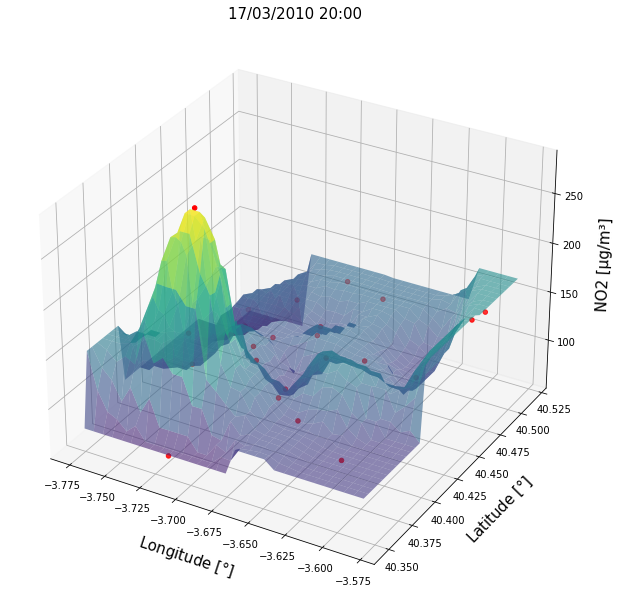

In [1479]:
plot3d(date, n_days, g, n, instant)

Big epsilon (28.8):

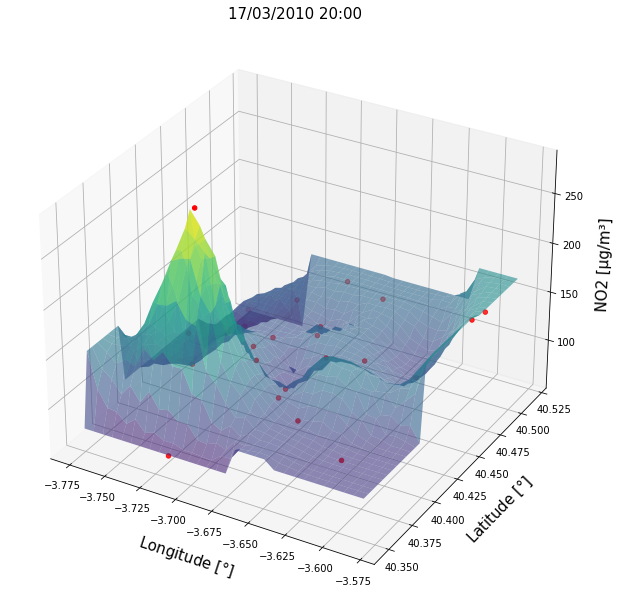

In [1481]:
plot3d(date, n_days, g, n, instant)

Intermediate epsilon (10):

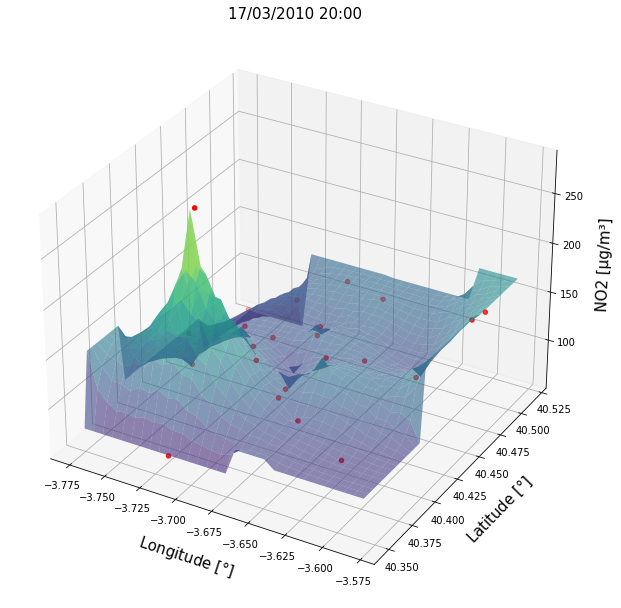

In [1483]:
plot3d(date, n_days, g, n, instant)

Small epsilon (0.01):

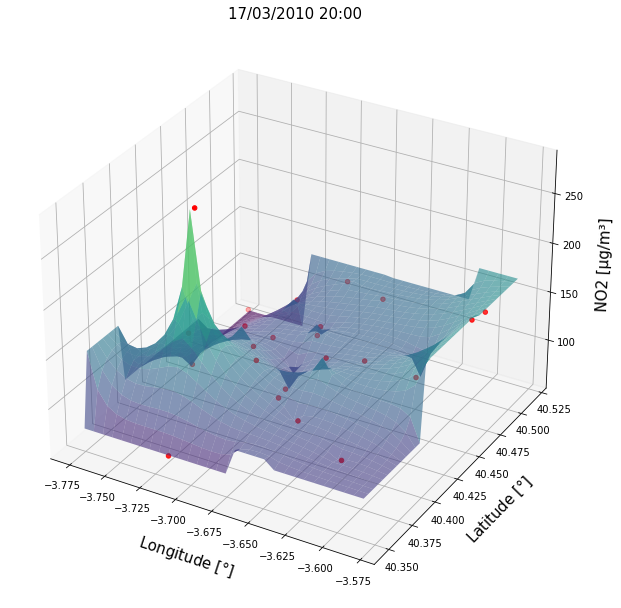

In [1485]:
plot3d(date, n_days, g, n, instant)

---

## AEMET

- Hourly weather data (2010-2020)

In [11]:
folderAemet = os.path.join(folder, 'raw', 'aemet')

### Location of the stations

In [12]:
df_met = pd.read_csv(folder + 'other/stations_aemet_long.csv', sep='\t', encoding='latin')
df_met['lat'] = df_met.LATITUD.astype(str).str[:2].astype(int) + \
                df_met.LATITUD.astype(str).str[2:4].astype(int) / 60 + \
                df_met.LATITUD.astype(str).str[4:].astype(int) / 3600
df_met['lng'] = -(df_met.LONGITUD.astype(str).str[0].astype(int) + \
                  df_met.LONGITUD.astype(str).str[1:3].astype(int) / 60 + \
                  df_met.LONGITUD.astype(str).str[3:5].astype(int) / 3600)
df_met.lat = df_met.lat.round(4)
df_met.lng = df_met.lng.round(4)
df_met.head()

INDICATIVO            NOMBRE NOM_PROV NOM_MUNI  ALTITUD  LATITUD  LONGITUD  \
0      3126Y         El Goloso   MADRID   MADRID      740   403341    342432   
1       3129           Barajas   MADRID   MADRID      609   402800    333202   
2      3194U  C. Universitaria   MADRID   MADRID      664   402706    343272   
3       3195            Retiro   MADRID   MADRID      667   402443    340412   
4       3196    Cuatro Vientos   MADRID   MADRID      690   402232    347102   

      C_X      C_Y   DATUM  IND_SYN        ALTA  BAJA      lat     lng  
0  439729  4490313  ETRS89      NaN  01/11/2003   NaN  40.5614 -3.7119  
1  452902  4479703  ETRS89   8221.0  01/01/1945   NaN  40.4667 -3.5556  
2  438594  4478142  ETRS89   8220.0  01/01/1972   NaN  40.4517 -3.7242  
3  442470  4473702  ETRS89   8222.0  01/03/1893   NaN  40.4119 -3.6781  
4  433267  4469738  ETRS89   8223.0  01/05/1945   NaN  40.3756 -3.7861

In [13]:
aux = df_met[['INDICATIVO', 'NOMBRE', 'lng', 'lat']].copy()
aux.columns = ['id', 'st_name', 'lng', 'lat']
aux.to_csv(folder + 'other/stations_aemet.csv', index=False)

In [14]:
df_met = pd.read_csv(folder + 'other/stations_aemet.csv')

In [74]:
# To calculate the 5km scale
distance.distance((df_met.iloc[5].lat + 0.002, df_met.iloc[1].lng - 0.02353*2.5),
                  (df_met.iloc[5].lat + 0.002, df_met.iloc[1].lng)).km

5.001138273598191

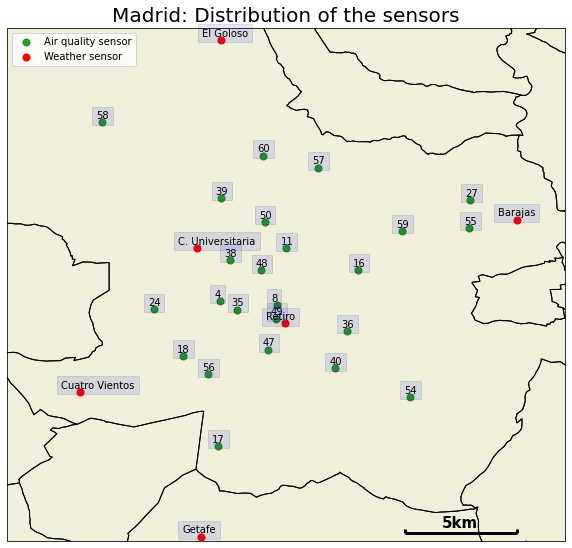

In [78]:
# Define the extent to be shown:
offset = 0.05
lon_lat_ranges = [df_st.LONGITUD.min() - offset, df_st.LONGITUD.max() + offset,
                  df_st.LATITUD.min() - offset, df_st.LATITUD.max() + offset]

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()})
fig.set_size_inches(10, 10)
ax.set_extent(lon_lat_ranges, crs=ccrs.PlateCarree())

fname = folder + 'other/coords/200001692.shp'
df_shp = pd.DataFrame({'poly': Reader(fname).geometries()})
for i in range(df_shp.shape[0]):
    ax.add_geometries([df_shp.iloc[i, 0]], ccrs.PlateCarree(), edgecolor='k', facecolor='none')

# Add frontiers, sea, lakes...
#ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS)
ax.scatter(df_st.LONGITUD, df_st.LATITUD, marker='o', c='g', s=50, alpha=0.8, label='Air quality sensor')
ax.set_title('Madrid: Distribution of the sensors', fontdict={'size': 20})
for s in range(df_st.shape[0]):
    ax.text(df_st.loc[s, 'LONGITUD'] - 0.003, df_st.loc[s, 'LATITUD'] + 0.002,
            df_st.loc[s, 'CODIGO_CORTO'], bbox=dict(facecolor='blue', alpha=0.1))
ax.scatter(df_met.lng, df_met.lat, marker='o', c='r', s=50, label='Weather sensor')
for s in range(df_met.shape[0]):
    ax.text(df_met.iloc[s].lng - 0.01, df_met.iloc[s].lat + 0.002,
            df_met.iloc[s].st_name, bbox=dict(facecolor='blue', alpha=0.1))
ax.hlines(df_met.iloc[s].lat + 0.002, df_met.iloc[1].lng - 0.02353*2.5, df_met.iloc[1].lng,
         color='k', linewidth=3)
ax.vlines((df_met.iloc[1].lng - 0.02353*2.5, df_met.iloc[1].lng),
          df_met.iloc[s].lat + 0.002, df_met.iloc[s].lat + 0.004,
         color='k', linewidth=3)
ax.text(df_met.iloc[1].lng - 0.02353*2.5/2 - 0.01, df_met.iloc[s].lat + 0.005,
        '5km', fontsize=15, weight='bold')
ax.legend(loc='upper left')
plt.savefig('./graphs/madrid_sensor_dist_met_def.pdf', bbox_inches='tight')
plt.show()

In [17]:
m_map = dict(zip(df_met.st_name, df_met.id))
mc_map = dict(zip(df_met.id, df_met.st_name))
mc_map

{'3126Y': 'El Goloso',
 '3129': 'Barajas',
 '3194U': 'C. Universitaria',
 '3195': 'Retiro',
 '3196': 'Cuatro Vientos',
 '3200': 'Getafe'}

### Variables measured

There are 3 types of files for each variable:
- `Descripcion`: Names of the columns, units and special values.
- `Maestro`: Stations that cover that variable, their locations and installation date.The last digit in the longitude is the orientation: 1 for East and 2 for West.
- `Variable`: The actual data.

The available variables are:
- **Temperature [1/10ºC]**: Measured in UTC (24h), at El Goloso, Barajas, C. Universitaria, Retiro, Cuatro Vientos and Getafe (6 stations).
- **Precipitation [1/10mm]**: Measured in UTC (24h), at El Goloso, Barajas, C. Universitaria, Retiro, Cuatro Vientos and Getafe (6 stations).
- **Wind speed [km/h]**: Measured in UTC (24h), at El Goloso, Barajas, C. Universitaria, Retiro, Cuatro Vientos and Getafe (6 stations).
- **Wind direction [10º]**: Measured in UTC (24h), at El Goloso, Barajas, C. Universitaria, Retiro, Cuatro Vientos and Getafe (6 stations).
- **Relative humidity [%]**: Measured in UTC (at 00, 07, 13 and 18), at El Goloso, Barajas, C. Universitaria, Retiro, Cuatro Vientos and Getafe (6 stations).
- **Clouds [eights of sky]**: Measured in UTC (at 00, 07, 13 and 18), at Barajas, Retiro, Cuatro Vientos and Getafe (4 stations).

### Data quality (raw)

Available files:

In [1583]:
!ls ../data/madrid/raw/aemet/

Datos_990211906.zip			MaestroNubes_990211906.csv
DescripcionHumedad_990211906.txt	Maestroprecipitacion_990211906.csv
DescripcionNubes_990211906.txt		Maestrotemperatura_990211906.csv
Descripcionprecipitacion_990211906.txt	MaestroViento_990211906.csv
Descripciontemperatura_990211906.txt	Nubes_990211906.csv
DescripcionViento_990211906.txt		precipitacion_990211906.csv
Humedad_990211906.csv			temperatura_990211906.csv
MaestroHumedad_990211906.csv		Viento_990211906.csv


Sample file:

In [1665]:
!head -n2 '../data/madrid/raw/aemet/temperatura_990211906.csv'

In [1812]:
slices = [
    slice('T00', 'T23'),
    slice('PH01', 'PH24'),
    slice('DIR_00', 'VEL_23'),
    slice('TOT_07', 'TOT_18', 5),
    slice('HU00', 'HU18')
]

for id_var, var in enumerate(['temperatura', 'precipitacion', 'Viento', 'Nubes', 'Humedad']):
    df = pd.read_csv(folderAemet + '/{}_990211906.csv'.format(var), sep=';', encoding='latin-1')
    df.INDICATIVO = df.INDICATIVO.astype(str)
    df['date'] = pd.to_datetime(df.AÑO.astype(str) + '/' + df.MES.astype(str) + '/' + df.DIA.astype(str),
                                format='%Y/%m/%d')
    df.loc[:, slices[id_var]] = df.loc[:, slices[id_var]].replace('N', np.nan)
    df.loc[:, slices[id_var]] = df.loc[:, slices[id_var]].astype(float)
    print('\n{}: {}'.format(var, df.shape))
    n_days = (df.date.max() - df.date.min()).days
    print('\tTemporal coverage \t{} - {}'.format(df.date.min().strftime('%d/%m/%Y'),
                                                 df.date.max().strftime('%d/%m/%Y')))
    print('\tSpatial coverage \t{}'.format(df.NOMBRE.nunique()))
    for st in df_met.id:
        if st in df.INDICATIVO.unique():
            aux = (~df.loc[df.INDICATIVO == st, slices[id_var]].isna()).sum().sum()
            print('\t{:<16} \t[{:0.4}, {:0.4}] \t{:0.4}% of days available \t{:0.4}% of values not NaN'.format(
                mc_map[st],
                df.loc[df.INDICATIVO == st, slices[id_var]].min().min(),
                df.loc[df.INDICATIVO == st, slices[id_var]].max().max(),
                df.loc[df.INDICATIVO == st].shape[0] / n_days * 100,
                aux / (n_days * df.loc[:, slices[id_var]].shape[1]) * 100,
            ))


temperatura: (21657, 42)
	Temporal coverage 	01/01/2010 - 31/01/2020
	Spatial coverage 	6
	El Goloso        	[-90.0, 388.0] 	93.81% of days available 	93.63% of values not NaN
	Barajas          	[-64.0, 409.0] 	100.0% of days available 	100.0% of values not NaN
	C. Universitaria 	[-80.0, 419.0] 	94.27% of days available 	94.19% of values not NaN
	Retiro           	[-36.0, 400.0] 	100.0% of days available 	99.61% of values not NaN
	Cuatro Vientos   	[-59.0, 408.0] 	100.0% of days available 	99.94% of values not NaN
	Getafe           	[-66.0, 406.0] 	100.0% of days available 	100.0% of values not NaN

precipitacion: (21452, 44)
	Temporal coverage 	01/01/2010 - 31/01/2020
	Spatial coverage 	6
	El Goloso        	[0.0, 212.0] 	91.69% of days available 	91.34% of values not NaN
	Barajas          	[-3.0, 277.0] 	100.0% of days available 	99.97% of values not NaN
	C. Universitaria 	[0.0, 430.0] 	90.82% of days available 	89.92% of values not NaN
	Retiro           	[-3.0, 174.0] 	100.0% of day

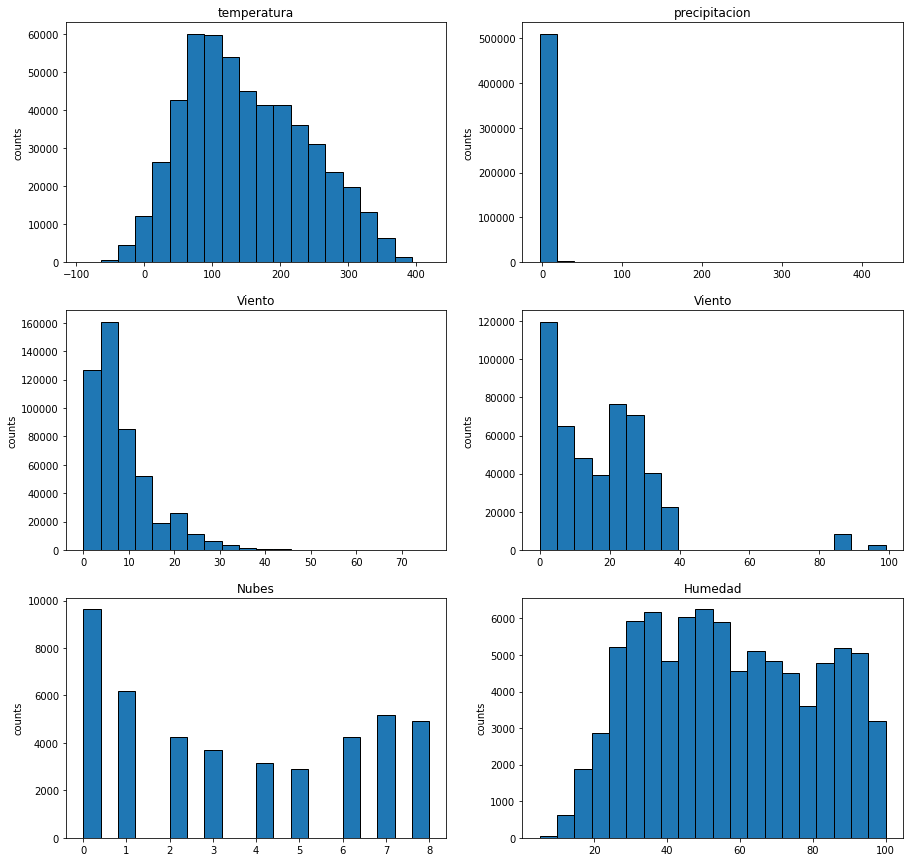

In [1820]:
slices = [
    slice('T00', 'T23'),
    slice('PH01', 'PH24'),
    slice('VEL_00', 'VEL_23', 2),
    slice('DIR_00', 'DIR_23', 2),
    slice('TOT_07', 'TOT_18', 5),
    slice('HU00', 'HU18')
]

fig, axs = plt.subplots(3, 2)
fig.set_size_inches(15, 15)
axs = axs.ravel()

for id_var, var in enumerate(['temperatura', 'precipitacion', 'Viento', 'Viento', 'Nubes', 'Humedad']):
    df = pd.read_csv(folderAemet + '/{}_990211906.csv'.format(var), sep=';', encoding='latin-1')
    df.loc[:, slices[id_var]] = df.loc[:, slices[id_var]].replace('N', np.nan)
    df.loc[:, slices[id_var]] = df.loc[:, slices[id_var]].astype(float)
    axs[id_var].hist(df.loc[:, slices[id_var]].values.ravel(), bins=20, edgecolor='k')
    axs[id_var].set_title(var)
    axs[id_var].set_ylabel('counts')
plt.show()

In [1785]:
df.columns

Index(['INDICATIVO', 'AÑO', 'MES', 'DIA', 'NOMBRE', 'ALTITUD', 'C_X', 'C_Y',
       'NOM_PROV', 'ALTA', 'BAJA', 'LONGITUD', 'LATITUD', 'IND_SYN', 'NOM_EG',
       'DATUM', 'BJ_07', 'MD_07', 'AL_07', 'TOT_BJ_07', 'TOT_07', 'BJ_13',
       'MD_13', 'AL_13', 'TOT_BJ_13', 'TOT_13', 'BJ_18', 'MD_18', 'AL_18',
       'TOT_BJ_18', 'TOT_18', 'OBSERVACIONES'],
      dtype='object')

Precipitación:

In [1789]:
df = pd.read_csv(folderAemet + '/{}_990211906.csv'.format('precipitacion'), sep=';', encoding='latin-1')
df.iloc[:10, 17:-1]

/home/iprado/.py-envs/py-3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


PH01  PH02  PH03  PH04  PH05  PH06  PH07  PH08  PH09  PH10  PH11  PH12  \
0   6.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
1   0.0   0.0   0.0   2.0   2.0   2.0   2.0   0.0   2.0   4.0   0.0   0.0   
2   0.0   0.0   0.0   0.0   0.0   0.0   0.0   2.0   2.0   2.0   0.0   0.0   
3   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
6   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  40.0   0.0   0.0   0.0   
7   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   ...  PH14  PH15  PH16  PH17  PH18  PH19  PH20  PH21  PH22  PH23  PH24  \
0  ...   0.0   0.0   0.0   0.0   0.0   0.0   4.0   0.0   0.0   0.0   2.0   
1  ...   0.0   0.0   0.0   0.0  30.0  20.0   2.0   0.0   0.0   0.0   0.0   
2  ...   8.0   2.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
3  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
4  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
5  ...   0.0   0.0   0.0   0.0   0.0   2.0   0.0   0.0   0.0   0.0   0.0   
6  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  26.0   0.0   0.0   
7  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
8  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   
9  ...   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0   

   FORMA  
0  500.0  
1  500.0  
2  500.0  
3  500.0  
4  500.0  
5  500.0  
6  500.0  
7  500.0  
8  500.0  
9  500.0  

[10 rows x 25 columns]

Nubes:

In [1809]:
df = pd.read_csv(folderAemet + '/{}_990211906.csv'.format('Nubes'), sep=';', encoding='latin-1')
df.loc[:, 'TOT_18'].unique()

array(['6', '8', '3', '5', '2', '4', '7', '1', '0', nan, 'N'],
      dtype=object)

In [1787]:
df = pd.read_csv(folderAemet + '/{}_990211906.csv'.format('Nubes'), sep=';', encoding='latin-1')
df.iloc[:10, 16:-1]

BJ_07 MD_07 AL_07  TOT_BJ_07  TOT_07 BJ_13 MD_13 AL_13  TOT_BJ_13  TOT_13  \
0    SC   NaN   NaN        3.0     3.0  CUSC  ACAS   NaN        5.0     7.0   
1    ST   NaN    CI        5.0     7.0    FS    AC   NaN        7.0     8.0   
2    SC    AC   NaN        5.0     6.0    SC    AS    CI        7.0     8.0   
3    ST   NaN   NaN        8.0     8.0    CU    AS    CS        6.0     8.0   
4  FSFC   NaN   NaN        8.0     8.0  CUSC    AS   NaN        6.0     7.0   
5    SC   NaN   NaN        5.0     5.0  CUSC  ACAS    CI        7.0     7.0   
6  FSFC  ASAC   NaN        7.0     8.0  FSFC  ACAS   NaN        7.0     8.0   
7   NaN   NaN    CI        0.0     2.0    CU   NaN    CI        1.0     1.0   
8    SC   NaN   NaN        3.0     3.0    SC   NaN   NaN        6.0     6.0   
9   NaN   NaN    CI        0.0     3.0   NaN   NaN    CS        0.0     7.0   

  BJ_18 MD_18 AL_18 TOT_BJ_18 TOT_18  
0  CUSC  ACAS    CI         3      6  
1    FS  ACAS   NaN         7      8  
2    SC    AC    CI         7      8  
3    ST    AS    CI         5      6  
4  CUSC   NaN   NaN         6      6  
5    SC  ACAS    CS         1      8  
6  FCFS  ACAS   NaN         7      8  
7    CU   NaN   NaN         3      3  
8  CUSC   NaN   NaN         5      5  
9  STSC   NaN   NaN         8      8

### Data quality (raw h5)

In [175]:
def read_variable(v):
    out_path = '../data/madrid/clean/01h_weather_raw.h5'
    
    with tb.open_file(out_path, mode='r') as h5:
        st = list(h5.root._v_attrs['m_map'].keys())
        df = pd.DataFrame(data=h5.root[v][:], columns=h5.root._v_attrs['columns'])
    df.columns = ['date'] + st
    df.date = df.date.apply(dt.datetime.utcfromtimestamp)
    
    return df.set_index('date')

In [176]:
def rawdesc(df):
    descs = df.describe(percentiles=[], include='all').T

    nans = df.isnull().sum(); nans.name = 'NaNs'
    nansP = round(df.isnull().sum() / df.shape[0] * 100, 2); nansP.name = 'NaNs [%]'
    zeros = (df == 0).sum(); zeros.name = 'ZEROs'
    types = df.dtypes; types.name = 'TYPEs'
    
    nansC = df.isna() # https://stackoverflow.com/a/45965003
    nansC = nansC.cumsum() - nansC.cumsum().where(~nansC).ffill().fillna(0).astype(int)
    nansC = nansC.max(); nansC.name = 'max cons NaNs'

    return pd.concat((types, descs.round(2), nans, nansP, nansC, zeros), axis=1)

TYPEs    count    mean    std   min    50%    max  NaNs  \
El Goloso         float64  82738.0  141.73  87.98 -90.0  132.0  388.0  5654   
Barajas           float64  88381.0  151.41  92.69 -64.0  139.0  409.0    11   
C. Universitaria  float64  83237.0  146.40  90.91 -80.0  134.0  419.0  5155   
Retiro            float64  88027.0  154.66  85.15 -36.0  142.0  400.0   365   
Cuatro Vientos    float64  88316.0  153.87  87.75 -59.0  141.0  408.0    76   
Getafe            float64  88371.0  157.84  88.83 -66.0  146.0  406.0    21   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso             6.40           2544    108  
Barajas               0.01              2    220  
C. Universitaria      5.83           1296    181  
Retiro                0.41             15     61  
Cuatro Vientos        0.09              5    102  
Getafe                0.02              5    141

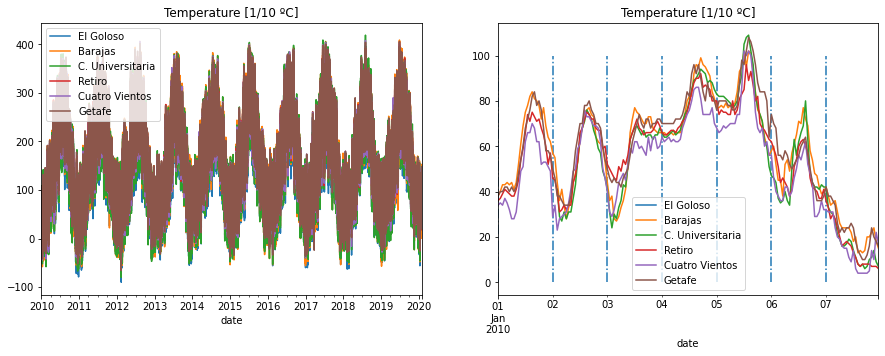

In [177]:
v = 'temperature'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Temperature [1/10 ºC]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [100], linestyles='-.')
ax[1].set_title('Temperature [1/10 ºC]')
plt.show()

TYPEs    count  mean   std  min  50%    max  NaNs  \
El Goloso         float64  80712.0  0.46  3.59  0.0  0.0  212.0  7680   
Barajas           float64  88344.0  0.41  3.70  0.0  0.0  277.0    48   
C. Universitaria  float64  79464.0  0.42  3.67  0.0  0.0  430.0  8928   
Retiro            float64  88272.0  0.46  3.54  0.0  0.0  174.0   120   
Cuatro Vientos    float64  87816.0  0.44  3.57  0.0  0.0  204.0   576   
Getafe            float64  87912.0  0.40  3.52  0.0  0.0  229.0   480   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso             8.69           2520  76917  
Barajas               0.05             24  84270  
C. Universitaria     10.10            792  75039  
Retiro                0.14             24  83640  
Cuatro Vientos        0.65             24  83526  
Getafe                0.54             24  84100

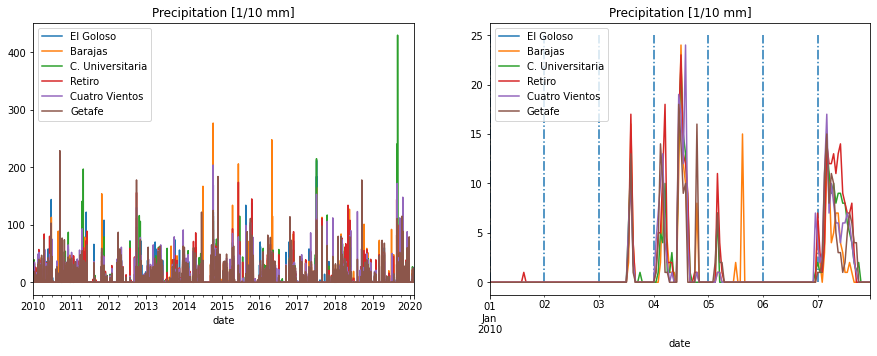

In [178]:
v = 'precipitation'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Precipitation [1/10 mm]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [25], linestyles='-.')
ax[1].set_title('Precipitation [1/10 mm]')
plt.show()

TYPEs    count  mean    std   min  50%   max   NaNs  \
El Goloso         float64  82455.0 -0.18   3.53 -25.0  0.0  32.0   5937   
Barajas           float64  88346.0 -0.11  10.28 -53.2  0.0  54.0     46   
C. Universitaria  float64  50272.0  0.13   4.31 -22.5  0.0  33.7  38120   
Retiro            float64  87175.0  0.65   5.03 -22.7  0.0  35.2   1217   
Cuatro Vientos    float64  87900.0 -1.27   7.76 -46.8  0.0  37.0    492   
Getafe            float64  86215.0  0.33   8.58 -59.0 -0.0  58.0   2177   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso             6.72           2520  23254  
Barajas               0.05             24   5997  
C. Universitaria     43.13          12444  12176  
Retiro                1.38            270  15710  
Cuatro Vientos        0.56              7  15248  
Getafe                2.46              7  18142

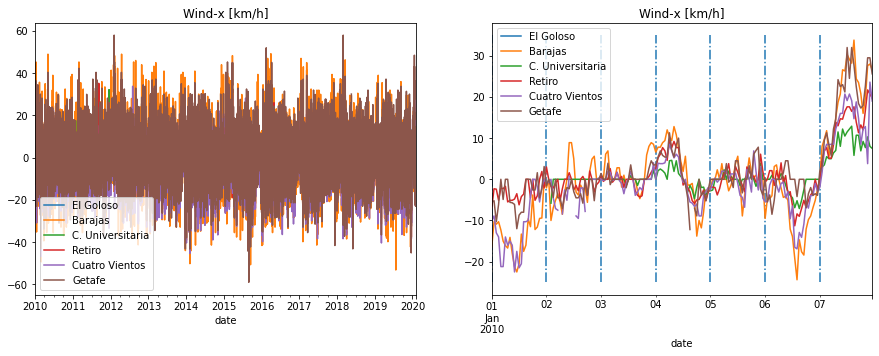

In [179]:
v = 'wind-x'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Wind-x [km/h]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [-25], [35], linestyles='-.')
ax[1].set_title('Wind-x [km/h]')
plt.show()

TYPEs    count  mean    std   min  50%   max   NaNs  \
El Goloso         float64  82455.0  0.09   4.49 -29.1  0.0  26.3   5937   
Barajas           float64  88346.0 -2.41   8.38 -54.2 -0.5  32.2     46   
C. Universitaria  float64  50272.0 -0.26   7.14 -37.4  0.0  29.0  38120   
Retiro            float64  87175.0 -0.28   6.26 -29.1  0.0  29.6   1217   
Cuatro Vientos    float64  87900.0 -2.52   9.03 -57.1  0.0  38.5    492   
Getafe            float64  86215.0 -2.57  10.89 -59.2  0.0  74.8   2177   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso             6.72           2520  20890  
Barajas               0.05             24  12534  
C. Universitaria     43.13          12444  10854  
Retiro                1.38            270  11921  
Cuatro Vientos        0.56              7  15432  
Getafe                2.46              7  14826

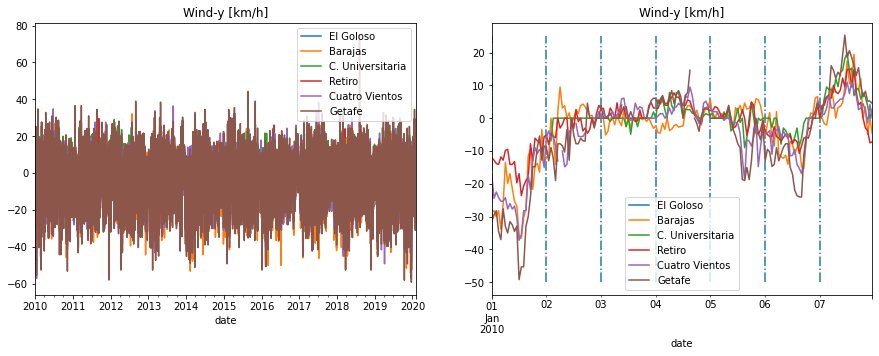

In [180]:
v = 'wind-y'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Wind-y [km/h]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [-50], [25], linestyles='-.')
ax[1].set_title('Wind-y [km/h]')
plt.show()

TYPEs    count   mean    std   min   50%    max   NaNs  \
El Goloso         float64  13777.0  59.47  24.60   7.0  59.0  100.0  74615   
Barajas           float64  14730.0  55.97  24.62   5.0  56.0  100.0  73662   
C. Universitaria  float64  13880.0  53.76  21.30  13.0  50.0   96.0  74512   
Retiro            float64  14718.0  58.14  20.44  10.0  57.0  100.0  73674   
Cuatro Vientos    float64  14730.0  57.71  23.55   5.0  56.0  100.0  73662   
Getafe            float64  14727.0  56.87  23.41   7.0  55.0  100.0  73665   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso            84.41           2544      0  
Barajas              83.34             12      0  
C. Universitaria     84.30            701      0  
Retiro               83.35             23      0  
Cuatro Vientos       83.34             12      0  
Getafe               83.34             12      0

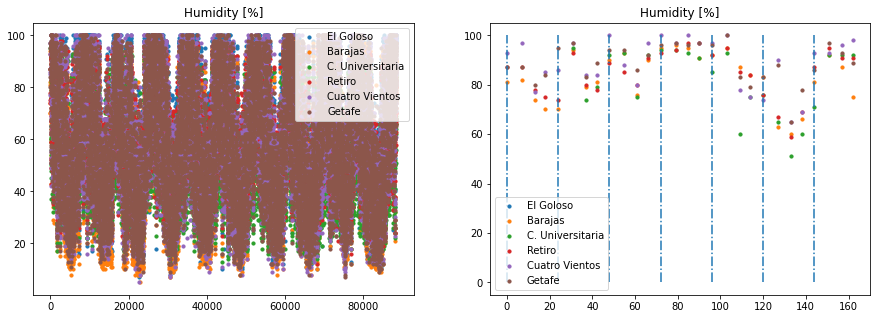

In [181]:
v = 'humidity'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

for i in range(6):
    ax[0].scatter(np.arange(df.shape[0]), df.iloc[:, i], s=10, label=df.columns[i])
ax[0].legend(loc='upper right')
ax[0].set_title('Humidity [%]')

for i in range(6):
    ax[1].scatter(np.arange(df.iloc[:24*7, :].shape[0]), df.iloc[:24*7, i], s=10, label=df.columns[i])
ax[1].legend()
ax[1].vlines(np.arange(0, 24*7, 24), [0], [100], linestyles='-.')
ax[1].set_title('Humidity [%]')
plt.show()

TYPEs    count  mean   std  min  50%  max   NaNs  \
El Goloso         float64      0.0   NaN   NaN  NaN  NaN  NaN  88392   
Barajas           float64  11046.0  3.44  2.90  0.0  3.0  8.0  77346   
C. Universitaria  float64      0.0   NaN   NaN  NaN  NaN  NaN  88392   
Retiro            float64  11019.0  3.40  3.00  0.0  3.0  8.0  77373   
Cuatro Vientos    float64  11049.0  3.62  2.86  0.0  3.0  8.0  77343   
Getafe            float64  11049.0  3.49  2.72  0.0  3.0  8.0  77343   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso           100.00          88392      0  
Barajas              87.50             36   2455  
C. Universitaria    100.00          88392      0  
Retiro               87.53             84   3247  
Cuatro Vientos       87.50             12   2235  
Getafe               87.50             12   1692

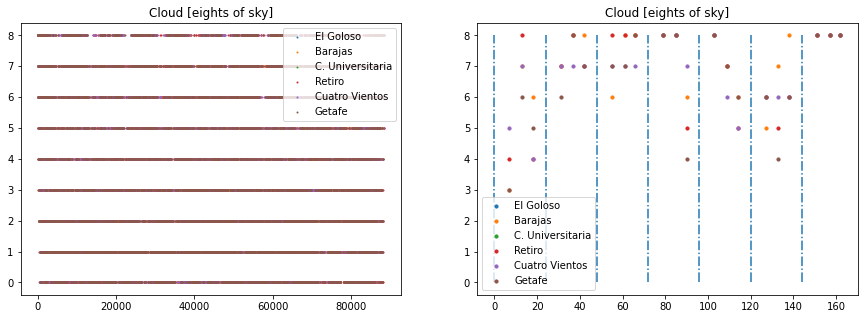

In [182]:
v = 'cloud'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

for i in range(6):
    ax[0].scatter(np.arange(df.shape[0]), df.iloc[:, i], s=1, label=df.columns[i])
ax[0].legend(loc='upper right')
ax[0].set_title('Cloud [eights of sky]')

for i in range(6):
    ax[1].scatter(np.arange(df.iloc[:24*7, :].shape[0]), df.iloc[:24*7, i], s=10, label=df.columns[i])
ax[1].legend()
ax[1].vlines(np.arange(0, 24*7, 24), [0], [8], linestyles='-.')
ax[1].set_title('Cloud [eights of sky]')
plt.show()

### Data quality (filled)

In [205]:
def read_variable(v):
    out_path = '../data/madrid/clean/01h_weather_filled.h5'
    
    with tb.open_file(out_path, mode='r') as h5:
        st = list(h5.root._v_attrs['m_map'].keys())
        df = pd.DataFrame(data=h5.root[v][:], columns=h5.root._v_attrs['columns'])
    df.columns = ['date'] + st
    df.date = df.date.apply(dt.datetime.utcfromtimestamp)
    
    return df.set_index('date')

TYPEs    count    mean    std   min    50%    max  NaNs  \
El Goloso         float64  88392.0  138.78  87.67 -90.0  128.0  388.0     0   
Barajas           float64  88392.0  151.42  92.69 -64.0  139.0  409.0     0   
C. Universitaria  float64  88392.0  147.67  91.12 -80.0  136.0  419.0     0   
Retiro            float64  88392.0  154.71  85.19 -46.0  142.0  400.0     0   
Cuatro Vientos    float64  88392.0  153.86  87.73 -59.0  141.0  408.0     0   
Getafe            float64  88392.0  157.85  88.83 -66.0  146.0  406.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0    126  
Barajas                0.0              0    220  
C. Universitaria       0.0              0    195  
Retiro                 0.0              0     62  
Cuatro Vientos         0.0              0    102  
Getafe                 0.0              0    141

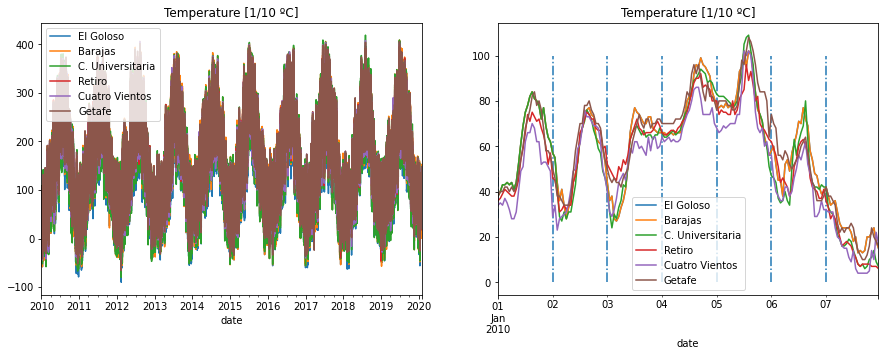

In [206]:
v = 'temperature'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Temperature [1/10 ºC]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [100], linestyles='-.')
ax[1].set_title('Temperature [1/10 ºC]')
plt.show()

TYPEs    count  mean   std  min  50%    max  NaNs  \
El Goloso         float64  88392.0  0.47  3.63  0.0  0.0  212.0     0   
Barajas           float64  88392.0  0.41  3.70  0.0  0.0  277.0     0   
C. Universitaria  float64  88392.0  0.43  3.82  0.0  0.0  430.0     0   
Retiro            float64  88392.0  0.46  3.55  0.0  0.0  174.0     0   
Cuatro Vientos    float64  88392.0  0.44  3.57  0.0  0.0  204.0     0   
Getafe            float64  88392.0  0.40  3.52  0.0  0.0  229.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0  84026  
Barajas                0.0              0  84302  
C. Universitaria       0.0              0  83523  
Retiro                 0.0              0  83742  
Cuatro Vientos         0.0              0  84075  
Getafe                 0.0              0  84541

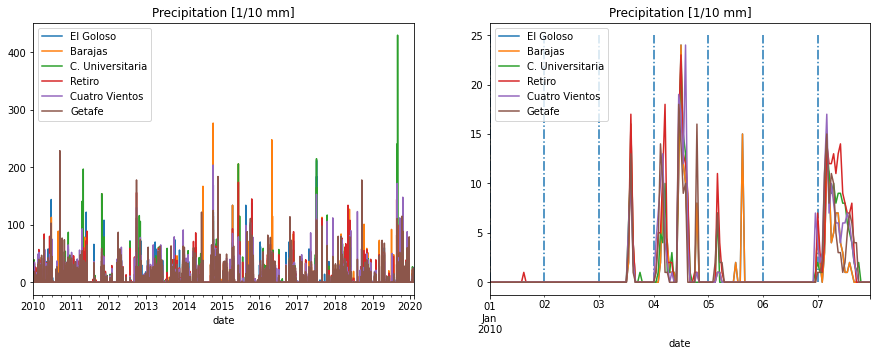

In [207]:
v = 'precipitation'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Precipitation [1/10 mm]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [25], linestyles='-.')
ax[1].set_title('Precipitation [1/10 mm]')
plt.show()

TYPEs    count  mean    std   min  50%   max  NaNs  \
El Goloso         float64  88392.0 -0.17   4.44 -49.4  0.0  47.3     0   
Barajas           float64  88392.0 -0.11  10.28 -53.2  0.0  54.0     0   
C. Universitaria  float64  88392.0 -0.01   7.45 -50.2  0.0  48.3     0   
Retiro            float64  88392.0  0.63   5.20 -33.8  0.0  46.3     0   
Cuatro Vientos    float64  88392.0 -1.26   7.76 -46.8  0.0  39.4     0   
Getafe            float64  88392.0  0.30   8.55 -59.0  0.0  58.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0  23710  
Barajas                0.0              0   6001  
C. Universitaria       0.0              0  14945  
Retiro                 0.0              0  15787  
Cuatro Vientos         0.0              0  15281  
Getafe                 0.0              0  18279

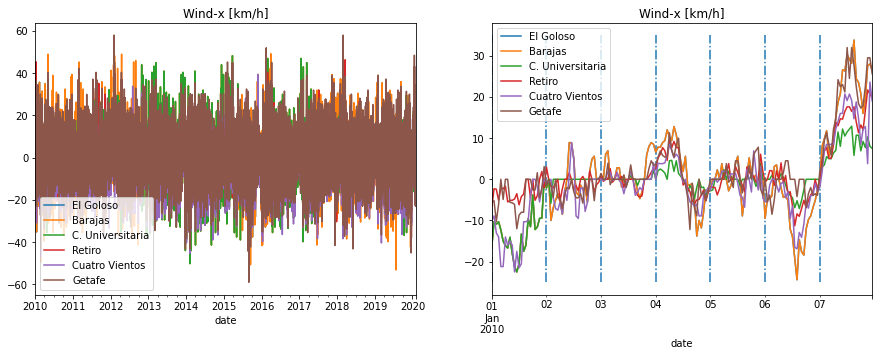

In [208]:
v = 'wind-x'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Wind-x [km/h]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [-25], [35], linestyles='-.')
ax[1].set_title('Wind-x [km/h]')
plt.show()

TYPEs    count  mean    std   min  50%   max  NaNs  \
El Goloso         float64  88392.0 -0.13   5.02 -47.3  0.0  27.6     0   
Barajas           float64  88392.0 -2.40   8.38 -54.2 -0.5  32.2     0   
C. Universitaria  float64  88392.0 -1.22   7.81 -53.2  0.0  29.0     0   
Retiro            float64  88392.0 -0.34   6.32 -45.0  0.0  29.6     0   
Cuatro Vientos    float64  88392.0 -2.51   9.01 -57.1  0.0  38.5     0   
Getafe            float64  88392.0 -2.52  10.79 -59.2  0.0  74.8     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0  21711  
Barajas                0.0              0  12538  
C. Universitaria       0.0              0  16487  
Retiro                 0.0              0  12070  
Cuatro Vientos         0.0              0  15505  
Getafe                 0.0              0  15133

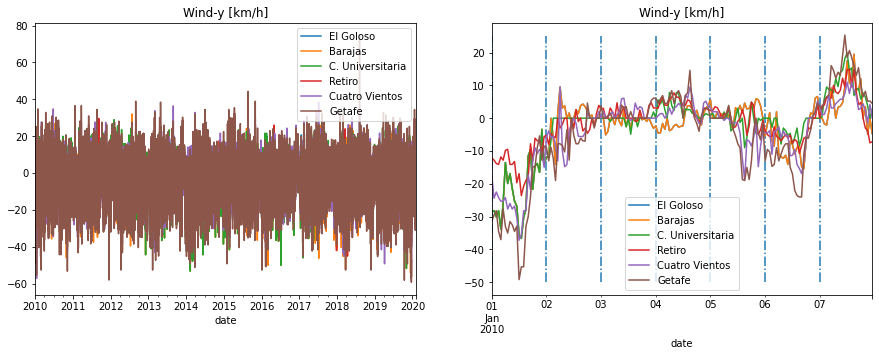

In [209]:
v = 'wind-y'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Wind-y [km/h]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [-50], [25], linestyles='-.')
ax[1].set_title('Wind-y [km/h]')
plt.show()

TYPEs    count   mean    std   min   50%    max  NaNs  \
El Goloso         float64  88392.0  60.81  24.32   7.0  61.0  100.0     0   
Barajas           float64  88392.0  56.87  24.53   5.0  57.0  100.0     0   
C. Universitaria  float64  88392.0  54.32  21.50   8.0  51.0   99.0     0   
Retiro            float64  88392.0  58.78  20.35  10.0  57.0  100.0     0   
Cuatro Vientos    float64  88392.0  58.44  23.52   5.0  57.0  100.0     0   
Getafe            float64  88392.0  57.58  23.40   7.0  56.0  100.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0      0  
Barajas                0.0              0      0  
C. Universitaria       0.0              0      0  
Retiro                 0.0              0      0  
Cuatro Vientos         0.0              0      0  
Getafe                 0.0              0      0

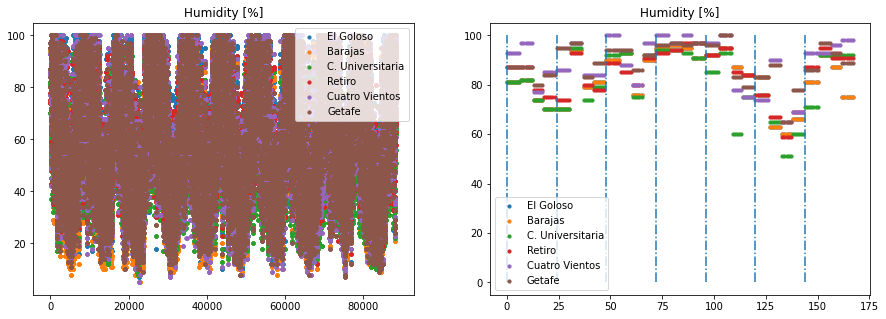

In [210]:
v = 'humidity'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

for i in range(6):
    ax[0].scatter(np.arange(df.shape[0]), df.iloc[:, i], s=10, label=df.columns[i])
ax[0].legend(loc='upper right')
ax[0].set_title('Humidity [%]')

for i in range(6):
    ax[1].scatter(np.arange(df.iloc[:24*7, :].shape[0]), df.iloc[:24*7, i], s=10, label=df.columns[i])
ax[1].legend()
ax[1].vlines(np.arange(0, 24*7, 24), [0], [100], linestyles='-.')
ax[1].set_title('Humidity [%]')
plt.show()

TYPEs    count  mean   std  min  50%  max  NaNs  NaNs [%]  \
El Goloso         float64  88392.0  3.47  2.88  0.0  3.0  8.0     0       0.0   
Barajas           float64  88392.0  3.47  2.88  0.0  3.0  8.0     0       0.0   
C. Universitaria  float64  88392.0  3.47  2.88  0.0  3.0  8.0     0       0.0   
Retiro            float64  88392.0  3.45  2.98  0.0  3.0  8.0     0       0.0   
Cuatro Vientos    float64  88392.0  3.66  2.83  0.0  3.0  8.0     0       0.0   
Getafe            float64  88392.0  3.51  2.70  0.0  3.0  8.0     0       0.0   

                  max cons NaNs  ZEROs  
El Goloso                     0  19061  
Barajas                       0  19061  
C. Universitaria              0  19061  
Retiro                        0  25065  
Cuatro Vientos                0  17035  
Getafe                        0  12946

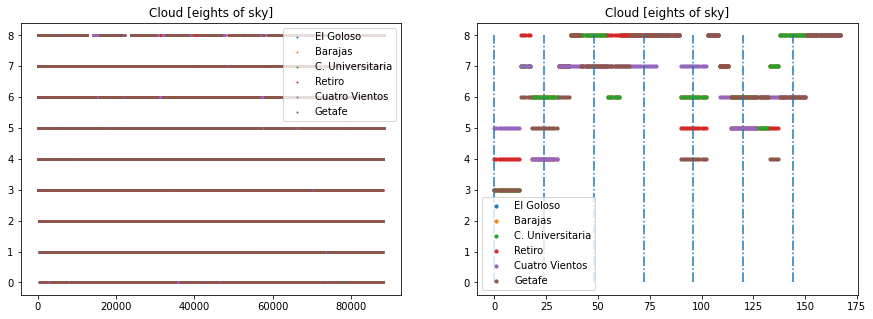

In [215]:
v = 'cloud'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

for i in range(6):
    ax[0].scatter(np.arange(df.shape[0]), df.iloc[:, i], s=1, label=df.columns[i])
ax[0].legend(loc='upper right')
ax[0].set_title('Cloud [eights of sky]')

for i in range(6):
    ax[1].scatter(np.arange(df.iloc[:24*7, :].shape[0]), df.iloc[:24*7, i], s=10, label=df.columns[i])
ax[1].legend()
ax[1].vlines(np.arange(0, 24*7, 24), [0], [8], linestyles='-.')
ax[1].set_title('Cloud [eights of sky]')
plt.show()

### Data quality (fillNorm)

In [224]:
def read_variable(v):
    out_path = '../data/madrid/clean/01h_weather_filledNorm.h5'
    
    with tb.open_file(out_path, mode='r') as h5:
        st = list(h5.root._v_attrs['m_map'].keys())
        df = pd.DataFrame(data=h5.root[v][:], columns=h5.root._v_attrs['columns'])
    df.columns = ['date'] + st
    df.date = df.date.apply(dt.datetime.utcfromtimestamp)
    
    return df.set_index('date')

TYPEs    count  mean   std  min   50%  max  NaNs  \
El Goloso         float64  88392.0  0.48  0.18  0.0  0.46  1.0     0   
Barajas           float64  88392.0  0.46  0.20  0.0  0.43  1.0     0   
C. Universitaria  float64  88392.0  0.46  0.18  0.0  0.43  1.0     0   
Retiro            float64  88392.0  0.45  0.19  0.0  0.42  1.0     0   
Cuatro Vientos    float64  88392.0  0.46  0.19  0.0  0.43  1.0     0   
Getafe            float64  88392.0  0.47  0.19  0.0  0.45  1.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0      1  
Barajas                0.0              0      2  
C. Universitaria       0.0              0      1  
Retiro                 0.0              0      1  
Cuatro Vientos         0.0              0      2  
Getafe                 0.0              0      1

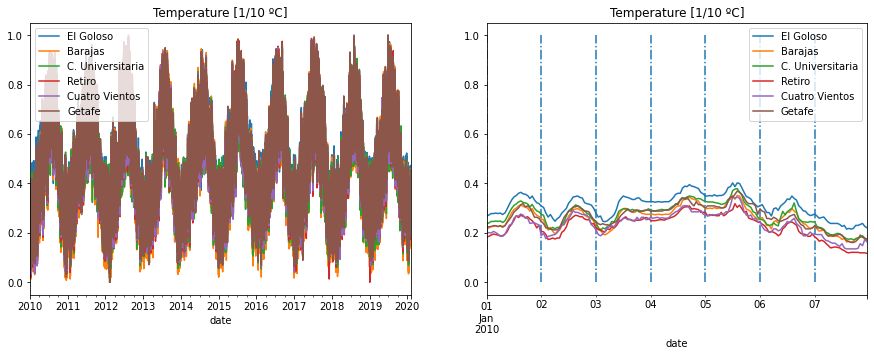

In [238]:
v = 'temperature'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Temperature [1/10 ºC]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [1], linestyles='-.')
ax[1].set_title('Temperature [1/10 ºC]')
plt.show()

TYPEs    count  mean   std  min  50%  max  NaNs  NaNs [%]  \
El Goloso         float64  88392.0   0.0  0.02  0.0  0.0  1.0     0       0.0   
Barajas           float64  88392.0   0.0  0.01  0.0  0.0  1.0     0       0.0   
C. Universitaria  float64  88392.0   0.0  0.01  0.0  0.0  1.0     0       0.0   
Retiro            float64  88392.0   0.0  0.02  0.0  0.0  1.0     0       0.0   
Cuatro Vientos    float64  88392.0   0.0  0.02  0.0  0.0  1.0     0       0.0   
Getafe            float64  88392.0   0.0  0.02  0.0  0.0  1.0     0       0.0   

                  max cons NaNs  ZEROs  
El Goloso                     0  84026  
Barajas                       0  84302  
C. Universitaria              0  83523  
Retiro                        0  83742  
Cuatro Vientos                0  84075  
Getafe                        0  84541

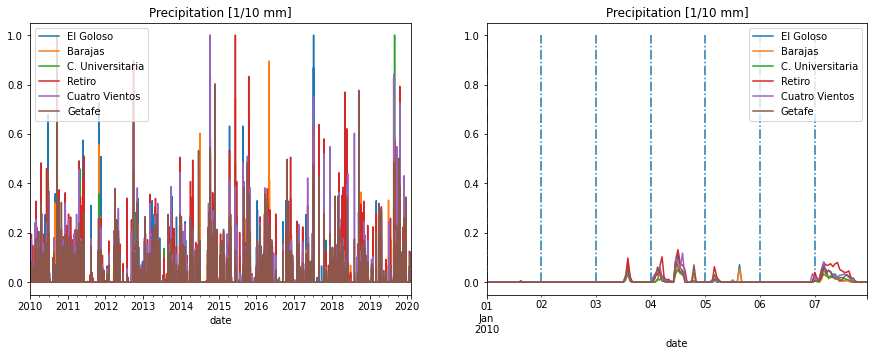

In [240]:
v = 'precipitation'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Precipitation [1/10 mm]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [1], linestyles='-.')
ax[1].set_title('Precipitation [1/10 mm]')
plt.show()

TYPEs    count  mean   std  min   50%  max  NaNs  \
El Goloso         float64  88392.0  0.51  0.05  0.0  0.51  1.0     0   
Barajas           float64  88392.0  0.50  0.10  0.0  0.50  1.0     0   
C. Universitaria  float64  88392.0  0.51  0.08  0.0  0.51  1.0     0   
Retiro            float64  88392.0  0.43  0.06  0.0  0.42  1.0     0   
Cuatro Vientos    float64  88392.0  0.53  0.09  0.0  0.54  1.0     0   
Getafe            float64  88392.0  0.51  0.07  0.0  0.50  1.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0      1  
Barajas                0.0              0      1  
C. Universitaria       0.0              0      1  
Retiro                 0.0              0      1  
Cuatro Vientos         0.0              0      1  
Getafe                 0.0              0      1

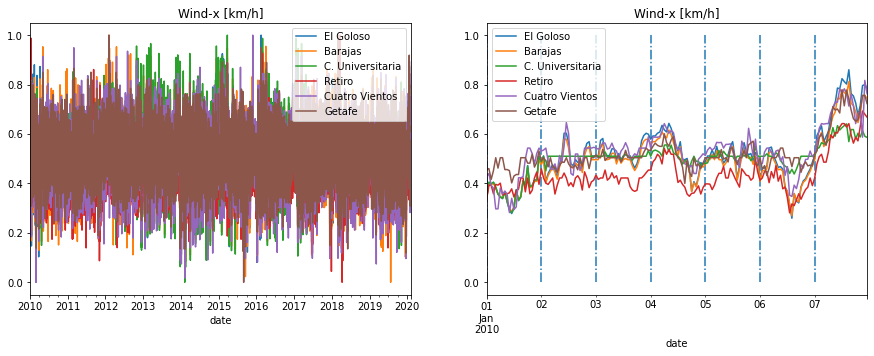

In [241]:
v = 'wind-x'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Wind-x [km/h]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [1], linestyles='-.')
ax[1].set_title('Wind-x [km/h]')
plt.show()

TYPEs    count  mean   std  min   50%  max  NaNs  \
El Goloso         float64  88392.0  0.63  0.07  0.0  0.63  1.0     0   
Barajas           float64  88392.0  0.60  0.10  0.0  0.62  1.0     0   
C. Universitaria  float64  88392.0  0.63  0.10  0.0  0.65  1.0     0   
Retiro            float64  88392.0  0.60  0.08  0.0  0.60  1.0     0   
Cuatro Vientos    float64  88392.0  0.57  0.09  0.0  0.60  1.0     0   
Getafe            float64  88392.0  0.42  0.08  0.0  0.44  1.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0      1  
Barajas                0.0              0      1  
C. Universitaria       0.0              0      1  
Retiro                 0.0              0      1  
Cuatro Vientos         0.0              0      1  
Getafe                 0.0              0      1

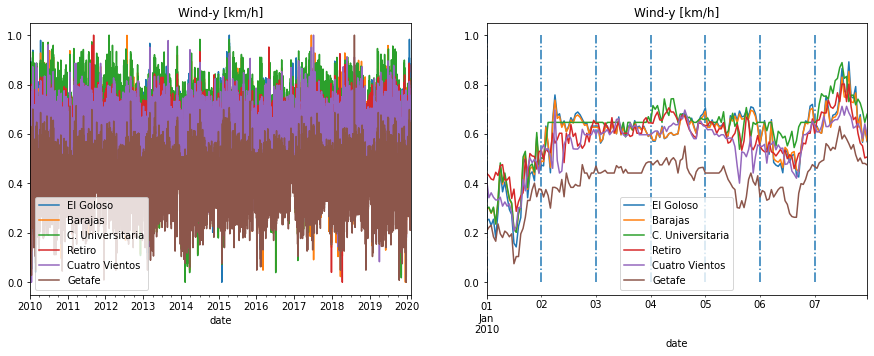

In [242]:
v = 'wind-y'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

df.plot(ax=ax[0])
ax[0].set_title('Wind-y [km/h]')

df.iloc[:24*7, :].plot(ax=ax[1])
ax[1].vlines(df.iloc[:24*7:24, :].index, [0], [1], linestyles='-.')
ax[1].set_title('Wind-y [km/h]')
plt.show()

TYPEs    count  mean   std  min   50%  max  NaNs  \
El Goloso         float64  88392.0  0.58  0.26  0.0  0.58  1.0     0   
Barajas           float64  88392.0  0.55  0.26  0.0  0.55  1.0     0   
C. Universitaria  float64  88392.0  0.51  0.24  0.0  0.47  1.0     0   
Retiro            float64  88392.0  0.54  0.23  0.0  0.52  1.0     0   
Cuatro Vientos    float64  88392.0  0.56  0.25  0.0  0.55  1.0     0   
Getafe            float64  88392.0  0.54  0.25  0.0  0.53  1.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0      6  
Barajas                0.0              0      5  
C. Universitaria       0.0              0      6  
Retiro                 0.0              0      6  
Cuatro Vientos         0.0              0      6  
Getafe                 0.0              0      6

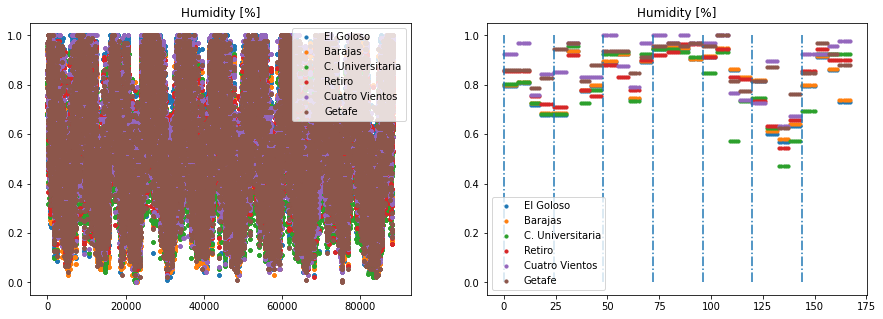

In [243]:
v = 'humidity'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

for i in range(6):
    ax[0].scatter(np.arange(df.shape[0]), df.iloc[:, i], s=10, label=df.columns[i])
ax[0].legend(loc='upper right')
ax[0].set_title('Humidity [%]')

for i in range(6):
    ax[1].scatter(np.arange(df.iloc[:24*7, :].shape[0]), df.iloc[:24*7, i], s=10, label=df.columns[i])
ax[1].legend()
ax[1].vlines(np.arange(0, 24*7, 24), [0], [1], linestyles='-.')
ax[1].set_title('Humidity [%]')
plt.show()

TYPEs    count  mean   std  min   50%  max  NaNs  \
El Goloso         float64  88392.0  0.43  0.36  0.0  0.38  1.0     0   
Barajas           float64  88392.0  0.43  0.36  0.0  0.38  1.0     0   
C. Universitaria  float64  88392.0  0.43  0.36  0.0  0.38  1.0     0   
Retiro            float64  88392.0  0.43  0.37  0.0  0.38  1.0     0   
Cuatro Vientos    float64  88392.0  0.46  0.35  0.0  0.38  1.0     0   
Getafe            float64  88392.0  0.44  0.34  0.0  0.38  1.0     0   

                  NaNs [%]  max cons NaNs  ZEROs  
El Goloso              0.0              0  19061  
Barajas                0.0              0  19061  
C. Universitaria       0.0              0  19061  
Retiro                 0.0              0  25065  
Cuatro Vientos         0.0              0  17035  
Getafe                 0.0              0  12946

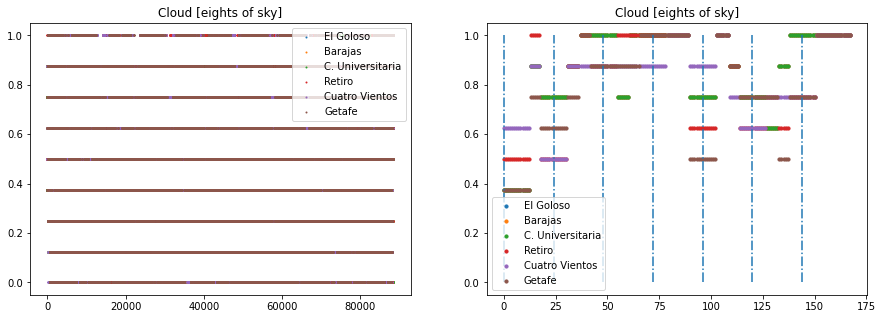

In [244]:
v = 'cloud'
df = read_variable(v)
display(rawdesc(df))

fig, ax = plt.subplots(1, 2)
fig.set_size_inches(15, 5)

for i in range(6):
    ax[0].scatter(np.arange(df.shape[0]), df.iloc[:, i], s=1, label=df.columns[i])
ax[0].legend(loc='upper right')
ax[0].set_title('Cloud [eights of sky]')

for i in range(6):
    ax[1].scatter(np.arange(df.iloc[:24*7, :].shape[0]), df.iloc[:24*7, i], s=10, label=df.columns[i])
ax[1].legend()
ax[1].vlines(np.arange(0, 24*7, 24), [0], [1], linestyles='-.')
ax[1].set_title('Cloud [eights of sky]')
plt.show()

### Stats table (2010-2019)

In [83]:
fin = l._DeepLearner__datetime_to_idx(dt.datetime(2020, 1, 1))

In [221]:
out_path = '../data/madrid/clean/01h_weather_raw.h5'

varss = ['cloud', 'humidity', 'precipitation', 'temperature', 'wind-x', 'wind-y']

df = pd.DataFrame(columns=['count', 'min sensors', 'median sensors', 'max sensors', 'mean', 'std',
                           'min', '25%', '50%', '75%', 'max'], index=varss)
df.index.set_names(['variable'], inplace=True)

with tb.open_file(out_path, mode='r') as h5_file:
    for idx, v in enumerate(varss):
        n = '/{}'.format(v)
        if n not in h5_file.root:
            continue
        li = []
        arr_or = h5_file.root[n][:fin, 1:]
        if v == 'humidity':
            arr_or = np.concatenate([arr_or[0::24], arr_or[7::24], arr_or[13::24], arr_or[18::24]])
        arr = arr_or[~np.isnan(arr_or)].ravel().copy()
        # add to table
        df.loc[v, 'count'] = arr.shape[0]
        df.loc[v, 'min sensors'] = (~np.isnan(arr_or)).sum(axis=1).min()
        df.loc[v, 'median sensors'] = int(np.median((~np.isnan(arr_or)).sum(axis=1)))
        df.loc[v, 'max sensors'] = (~np.isnan(arr_or)).sum(axis=1).max()
        df.loc[v, 'mean'] = arr.mean().round(2)
        df.loc[v, 'std'] = arr.std().round(2)
        df.loc[v, 'min'] = arr.min()
        df.loc[v, '25%'] = np.percentile(arr, 25)
        df.loc[v, '50%'] = np.percentile(arr, 50)
        df.loc[v, '75%'] = np.percentile(arr, 75)
        df.loc[v, 'max'] = arr.max()
df = df.loc[['temperature', 'precipitation', 'wind-x', 'wind-y', 'humidity', 'cloud'], :]
df.reset_index(inplace=True)
df.to_csv('./variables-stats/weather_stats_2010_2019.csv', index=False)
df

variable   count min sensors median sensors max sensors    mean  \
0    temperature  514606           3              6           6  151.92   
1  precipitation  508128           4              6           6    0.43   
2         wind-x  478661           3              5           6   -0.10   
3         wind-y  478661           3              5           6   -1.44   
4       humidity   85818           4              6           6   56.84   
5          cloud   43800           0              0           4    3.48   

     std   min   25%    50%    75%    max  
0  88.97 -90.0  82.0  140.0  218.0  419.0  
1   3.61   0.0   0.0    0.0    0.0  430.0  
2   7.24 -59.0  -3.5    0.0    3.8   58.0  
3   8.13 -59.2  -4.8    0.0    3.5   74.8  
4  23.09   5.0  38.0   55.0   76.0  100.0  
5   2.87   0.0   1.0    3.0    6.0    8.0

## Next